# Initial data processing (ETL)

In [168]:
# ipython
%matplotlib inline

from IPython.display import display as d
from IPython.display import Image

import pandas as pd
import pingouin as pg
import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import ruptures as rpt
sns.set(rc={'figure.figsize':(5,5)})
sns.set(font_scale=0.9)
sns.set_style("white")
pd.set_option('display.max_columns', None)
import re
import glob
import json
import os
import sys
import json

from IPython.display import display as d
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.metrics import roc_curve, auc
from scipy.stats import pearsonr
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multitest import multipletests

# R stuff
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

def save_fig(ax, title, pdfname):
    ax.set_title(title)
    ax.get_figure().savefig(pdfname, bbox_inches="tight", dpi=300)

palette = sns.color_palette("deep")
sns.set_palette(palette)

In [169]:
# avrateNG - Pre Simulator Sickness Questionnaire (SSQ) and Weinstein Noise Sensitivity Scale (WNSS)
test_ids = ["1", "2", "3"]
test_names = ["360_diotic", "360_binaural", "cgi_binaural"]
pre_ssq_df = pd.DataFrame()
weinstein_df = pd.DataFrame()

for test_id, test_name in zip(test_ids, test_names):
    df = pd.read_csv("../subjective_data/{}/avrateNG/_info.csv".format(test_name), index_col=0)

    info_df = pd.json_normalize(df['info_json'].apply(json.loads))
    info_df['subject_number'] = range(1, len(info_df) + 1)
    info_df['test_id'] = test_id
    columns_to_keep = ['subject_number', 'test_id', 'radio_allgemeines_unbehagen_bzw_unwohlsein', 'radio_ermuedung', 'radio_kopfschmerzen', 'radio_ueberanstrengte_augen', 'radio_schwierigkeiten_mit_sehschaerfe', 'radio_erhoehte_speichelbildung', 'radio_schwitzen', 'radio_uebelkeit__erbrechen_konzentrationsschwierigkeiten', 'radio_druckgefuehl_im_kopfbereich', 'radio_verschwommene_sicht', 'radio_schwindelgefuehl__bei_geoeffneten_augen_', 'radio_schwindelgefuehl__bei_geschlossenen_augen_', 'radio_gleichgewichtsstoerungen', 'radio_magenbeschwerden', 'radio_aufstossen']
    pre_ssq_df_tmp = info_df[columns_to_keep]
    pre_ssq_df_tmp = pre_ssq_df_tmp.rename(columns=lambda x: x.replace('radio_', ''))
    N_columns = ['allgemeines_unbehagen_bzw_unwohlsein', 'erhoehte_speichelbildung', 'schwitzen', 'uebelkeit__erbrechen_konzentrationsschwierigkeiten', 'uebelkeit__erbrechen_konzentrationsschwierigkeiten', 'magenbeschwerden', 'aufstossen']
    O_columns = ['allgemeines_unbehagen_bzw_unwohlsein', 'ermuedung', 'kopfschmerzen', 'ueberanstrengte_augen', 'schwierigkeiten_mit_sehschaerfe', 'uebelkeit__erbrechen_konzentrationsschwierigkeiten', 'verschwommene_sicht']
    D_columns = ['uebelkeit__erbrechen_konzentrationsschwierigkeiten', 'kopfschmerzen', 'druckgefuehl_im_kopfbereich', 'verschwommene_sicht', 'schwindelgefuehl__bei_geoeffneten_augen_', 'schwindelgefuehl__bei_geschlossenen_augen_', 'gleichgewichtsstoerungen']
    pre_ssq_df_tmp['N'] = pre_ssq_df_tmp[N_columns].astype(int).sum(axis=1) * 9.54
    pre_ssq_df_tmp['O'] = pre_ssq_df_tmp[O_columns].astype(int).sum(axis=1) * 7.58
    pre_ssq_df_tmp['D'] = pre_ssq_df_tmp[D_columns].astype(int).sum(axis=1) * 13.92
    pre_ssq_df_tmp['TS'] = (pre_ssq_df_tmp[N_columns].astype(int).sum(axis=1) + pre_ssq_df_tmp[O_columns].astype(int).sum(axis=1) + pre_ssq_df_tmp[D_columns].astype(int).sum(axis=1)) * 3.74
    pre_ssq_df_tmp['test'] = 'before'
    pre_ssq_df = pd.concat([pre_ssq_df, pre_ssq_df_tmp])

    columns_to_keep = ['subject_number', 'test_id', 'radio_es_wuerde_mir_nichts_ausmachen__an_einer_lauten_strasse_zu_wohnen__wenn_meine_wohnung_schoen_waere', 'radio_mir_fallt_laerm_heutzutage_mehr_auf_als_frueher', 'radio_es_sollte_niemanden_gross_stoeren__wenn_ein_anderer_ab_und_zu_seine_stereoanlage_voll_aufdreht', 'radio_im_kino_stoert_mich_fluestern_und_rascheln_von_bonbonpapier', 'radio_ich_werde_leicht_durch_laerm_geweckt', 'radio_wenn_es_an_meinem_arbeitsplatz_iaut_ist__dann_versuche_ich__tuer_oder_fenster_zu_schliessen_oder_anderswo_weiterzuarbeiten', 'radio_es_aergert_mich__wenn_meine_nachbarn_laut_werden', 'radio_an_die_meisten_geraeusche_gewoehne_ich_mich_ohne_grosse_schwierigkeiten', 'radio_es_wuerde_mir_etwas_ausmachen__wenn_eine_wohnung__die_ich_gerne_mieten_wuerde__gegenueber_der_feuerwache_laege', 'radio_manchmal_gehen_mir_geraeusche_auf_die_nerven_und_aergern_mich', 'radio_sogar_musik__die_ich_eigentlich_mag__stoert_mich__wenn_ich_mich_konzentrieren_moechte', 'radio_es_wuerde_mich_nicht_stoeren__die_alltagsgeraeusche_meiner_nachbarn__zb_schritte__wasserrauschen__zu_hoeren', 'radio_wenn_ich_allein_sein_moechte__stoeren_mich_geraeusche_von_ausserhalb', 'radio_ich_kann_mich_gut_konzentrieren__egal_was_um_mich_herum_geschieht', 'radio_in_der_bibliothek_macht_es_mir_nichts_aus__wenn_sich_leute_unterhalten__solange_dies_leise_geschieht', 'radio_oft_wuensche_ich_mir_voellige_stille', 'radio_motorraeder_sollten_besser_schallgedaempft_sein', 'radio_es_faellt_mir_schwer__mich_an_einem_lauten_ort_zu_entspannen', 'radio_ich_werde_wuetend_auf_leute__die_laerm_machen__der_mich_vom_einschlafen_oder_vom_fortkommen_in_der_arbeit_abhaelt', 'radio_es_wuerde_mir_nichts_ausmachen__in_einer_wohnung_mit_duennen_waenden_zu_leben', 'radio_ich_bin_geraeuschempfindlich']
    weinstein_df_tmp = info_df[columns_to_keep]
    weinstein_df_tmp = weinstein_df_tmp.rename(columns=lambda x: x.replace('radio_', ''))
    columns_to_invert = ['es_wuerde_mir_nichts_ausmachen__an_einer_lauten_strasse_zu_wohnen__wenn_meine_wohnung_schoen_waere', 'es_sollte_niemanden_gross_stoeren__wenn_ein_anderer_ab_und_zu_seine_stereoanlage_voll_aufdreht', 'an_die_meisten_geraeusche_gewoehne_ich_mich_ohne_grosse_schwierigkeiten', 'es_wuerde_mich_nicht_stoeren__die_alltagsgeraeusche_meiner_nachbarn__zb_schritte__wasserrauschen__zu_hoeren', 'ich_kann_mich_gut_konzentrieren__egal_was_um_mich_herum_geschieht', 'in_der_bibliothek_macht_es_mir_nichts_aus__wenn_sich_leute_unterhalten__solange_dies_leise_geschieht', 'es_wuerde_mir_nichts_ausmachen__in_einer_wohnung_mit_duennen_waenden_zu_leben']
    for col in columns_to_invert:
        weinstein_df_tmp[col] = weinstein_df_tmp[col].astype(int).apply(lambda x: 4 - x)
    weinstein_df = pd.concat([weinstein_df, weinstein_df_tmp])

d(weinstein_df)
d(pre_ssq_df)

# avrateNG - Post Simulator Sickness Questionnaire (SSQ)
post_ssq_df = pd.DataFrame()

for test_id, test_name in zip(test_ids, test_names):
    df = pd.read_csv("../subjective_data/{}/avrateNG/_post_info.csv".format(test_name), index_col=0)

    info_df = pd.json_normalize(df['info_json'].apply(json.loads))
    info_df['subject_number'] = range(1, len(info_df) + 1)
    info_df['test_id'] = test_id
    columns_to_keep = ['subject_number', 'test_id', 'radio_allgemeines_unbehagen_bzw_unwohlsein', 'radio_ermuedung', 'radio_kopfschmerzen', 'radio_ueberanstrengte_augen', 'radio_schwierigkeiten_mit_sehschaerfe', 'radio_erhoehte_speichelbildung', 'radio_schwitzen', 'radio_uebelkeit__erbrechen_konzentrationsschwierigkeiten', 'radio_druckgefuehl_im_kopfbereich', 'radio_verschwommene_sicht', 'radio_schwindelgefuehl__bei_geoeffneten_augen_', 'radio_schwindelgefuehl__bei_geschlossenen_augen_', 'radio_gleichgewichtsstoerungen', 'radio_magenbeschwerden', 'radio_aufstossen']
    post_ssq_df_tmp = info_df[columns_to_keep]
    post_ssq_df_tmp = post_ssq_df_tmp.rename(columns=lambda x: x.replace('radio_', ''))
    N_columns = ['allgemeines_unbehagen_bzw_unwohlsein', 'erhoehte_speichelbildung', 'schwitzen', 'uebelkeit__erbrechen_konzentrationsschwierigkeiten', 'uebelkeit__erbrechen_konzentrationsschwierigkeiten', 'magenbeschwerden', 'aufstossen']
    O_columns = ['allgemeines_unbehagen_bzw_unwohlsein', 'ermuedung', 'kopfschmerzen', 'ueberanstrengte_augen', 'schwierigkeiten_mit_sehschaerfe', 'uebelkeit__erbrechen_konzentrationsschwierigkeiten', 'verschwommene_sicht']
    D_columns = ['uebelkeit__erbrechen_konzentrationsschwierigkeiten', 'kopfschmerzen', 'druckgefuehl_im_kopfbereich', 'verschwommene_sicht', 'schwindelgefuehl__bei_geoeffneten_augen_', 'schwindelgefuehl__bei_geschlossenen_augen_', 'gleichgewichtsstoerungen']
    post_ssq_df_tmp['N'] = post_ssq_df_tmp[N_columns].astype(int).sum(axis=1) * 9.54
    post_ssq_df_tmp['O'] = post_ssq_df_tmp[O_columns].astype(int).sum(axis=1) * 7.58
    post_ssq_df_tmp['D'] = post_ssq_df_tmp[D_columns].astype(int).sum(axis=1) * 13.92
    post_ssq_df_tmp['TS'] = (post_ssq_df_tmp[N_columns].astype(int).sum(axis=1) + post_ssq_df_tmp[O_columns].astype(int).sum(axis=1) + post_ssq_df_tmp[D_columns].astype(int).sum(axis=1)) * 3.74
    post_ssq_df_tmp['test'] = 'after'
    post_ssq_df = pd.concat([post_ssq_df, post_ssq_df_tmp])

d(post_ssq_df)

# avrageNG - IPQ
ipq_df = pd.DataFrame()

for test_id, test_name in zip(test_ids, test_names):
    df = pd.read_csv("../subjective_data/{}/avrateNG/_post_info.csv".format(test_name), index_col=0)

    info_df = pd.json_normalize(df['info_json'].apply(json.loads))
    info_df['subject_number'] = range(1, len(info_df) + 1)
    info_df['test_id'] = test_id
    columns_to_keep = ["subject_number",
                       "test_id", 
                       "radio_in_der_computererzeugten_welt_hatte_ich_den_eindruck__dort_gewesen_zu_sein",
                       "radio_ich_hatte_das_gefuehl__dass_die_virtuelle_umgebung_hinter_mir_weitergeht",
                       "radio_ich_hatte_das_gefuehl__nur_bilder_zu_sehen",
                       "radio_ich_hatte_nicht_das_gefuehl__in_dem_virtuellen_raum_zu_sein",
                       "radio_ich_hatte_das_gefuehl__in_dem_virtuellen_raum_zu_handeln_statt_etwas_von_aussen_zu_bedienen",
                       "radio_ich_fuehlte_mich_im_virtuellen_raum_anwesend",
                       "radio_wie_bewusst_war_ihnen_die_reale_welt__waehrend_sie_sich_durch_die_virtuelle_welt_bewegten__zb_geraeusche__raumtemperatur__andere_personen_etc_",
                       "radio_meine_reale_umgebung_war_mir_nicht_mehr_bewusst",
                       "radio_ich_achtete_noch_auf_die_reale_umgebung",
                       "radio_meine_aufmerksamkeit_war_von_der_virtuellen_welt_voellig_in_bann_gezogen",
                       "radio_wie_real_erschien_ihnen_die_virtuelle_umgebung",
                       "radio_wie_sehr_glich_ihr_erleben_der_virtuellen_umgebung_dem_erleben_einer_realen_umgebung",
                       "radio_wie_real_erschien_ihnen_die_virtuelle_welt",
                       "radio_die_virtuelle_welt_erschien_mir_wirklicher_als_die_reale_welt"]
    ipq_df_tmp = info_df[columns_to_keep]
    ipq_df_tmp.rename(columns={'radio_in_der_computererzeugten_welt_hatte_ich_den_eindruck__dort_gewesen_zu_sein':'G1'}, inplace=True)
    ipq_df_tmp.rename(columns={'radio_ich_hatte_das_gefuehl__dass_die_virtuelle_umgebung_hinter_mir_weitergeht':'SP1'}, inplace=True)
    ipq_df_tmp.rename(columns={'radio_ich_hatte_das_gefuehl__nur_bilder_zu_sehen':'SP2'}, inplace=True)
    ipq_df_tmp.rename(columns={'radio_ich_hatte_nicht_das_gefuehl__in_dem_virtuellen_raum_zu_sein':'SP3'}, inplace=True)
    ipq_df_tmp.rename(columns={'radio_ich_hatte_das_gefuehl__in_dem_virtuellen_raum_zu_handeln_statt_etwas_von_aussen_zu_bedienen':'SP4'}, inplace=True)
    ipq_df_tmp.rename(columns={'radio_ich_fuehlte_mich_im_virtuellen_raum_anwesend':'SP5'}, inplace=True)
    ipq_df_tmp.rename(columns={'radio_wie_bewusst_war_ihnen_die_reale_welt__waehrend_sie_sich_durch_die_virtuelle_welt_bewegten__zb_geraeusche__raumtemperatur__andere_personen_etc_':'INV1'}, inplace=True)
    ipq_df_tmp.rename(columns={'radio_meine_reale_umgebung_war_mir_nicht_mehr_bewusst':'INV2'}, inplace=True)
    ipq_df_tmp.rename(columns={'radio_ich_achtete_noch_auf_die_reale_umgebung':'INV3'}, inplace=True)
    ipq_df_tmp.rename(columns={'radio_meine_aufmerksamkeit_war_von_der_virtuellen_welt_voellig_in_bann_gezogen':'INV4'}, inplace=True)
    ipq_df_tmp.rename(columns={'radio_wie_real_erschien_ihnen_die_virtuelle_umgebung':'REAL1'}, inplace=True)
    ipq_df_tmp.rename(columns={'radio_wie_sehr_glich_ihr_erleben_der_virtuellen_umgebung_dem_erleben_einer_realen_umgebung':'REAL2'}, inplace=True)
    ipq_df_tmp.rename(columns={'radio_wie_real_erschien_ihnen_die_virtuelle_welt':'REAL3'}, inplace=True)
    ipq_df_tmp.rename(columns={'radio_die_virtuelle_welt_erschien_mir_wirklicher_als_die_reale_welt':'REAL4'}, inplace=True)
    ipq_df_tmp = ipq_df_tmp.apply(pd.to_numeric)
    ipq_df_tmp["SP2U"] = -1 * ipq_df_tmp["SP2"] + 6
    ipq_df_tmp["INV3U"] = -1 * ipq_df_tmp["INV3"] + 6
    ipq_df_tmp["REAL1U"] = -1 * ipq_df_tmp["REAL1"] + 6
    ipq_df_tmp["SP"] = ipq_df_tmp[["SP1", "SP2U", "SP3", "SP4", "SP5"]].mean(axis=1)
    ipq_df_tmp["INV"] = ipq_df_tmp[["INV1", "INV2", "INV3U", "INV4"]].mean(axis=1)
    ipq_df_tmp["REAL"] = ipq_df_tmp[["REAL1U", "REAL2", "REAL3", "REAL4"]].mean(axis=1)
    ipq_df = pd.concat([ipq_df, ipq_df_tmp])
d(ipq_df)

# avrateNG - 5 questions from NASA TLX & 1 question from Schmutz et al.
nasatlx_df = pd.DataFrame()

for test_id, test_name in zip(test_ids, test_names):
    df = pd.read_csv('../subjective_data/{}/avrateNG/_ratings.csv'.format(test_name), index_col=False)
    
    df_filtered = df[df['rating_type'].str.startswith('range_')].copy()
    df_filtered['test_id'] = test_id
    
    unique_user_ids = df_filtered['user_ID'].unique()
    new_user_ids = {old_id: new_id+1 for new_id, old_id in enumerate(unique_user_ids)}
    df_filtered.loc[:, 'subject_number'] = df_filtered['user_ID'].map(new_user_ids)
    
    unique_stimuli_files = df_filtered['stimuli_file'].unique()
    new_stimuli_ids = {old_file: new_id+5 for new_id, old_file in enumerate(unique_stimuli_files)}
    df_filtered.loc[:, 'scene'] = df_filtered['stimuli_file'].map(new_stimuli_ids)

    rating_type_mapping = {
        "range_wie_anspruchsvoll_war_die_durchfuehrung_der_aufgabe_fuer_sie": "nasatlx_mental_demand",
        "range_wie_viel_zeitdruck_hatten_sie_bei_der_durchfuehrung_der_aufgabe": "nasatlx_temporal_demand",
        "range_wie_hoch_war_ihr_erfolgserlebnis_bei_der_durchfuehrung_der_aufgabe": "nasatlx_performance",
        "range_wie_hart_mussten_sie_arbeiten__um_ihr_leistungsniveau_zu_erreichen": "nasatlx_effort",
        "range_wie_unsicher__entmutigt__gestresst_und_genervt_haben_sie_sich_waehrend_der_aufgabe_gefuehlt": "nasatlx_frustration",
        "range_wie_hoch_war_die_von_ihnen_empfundene_anstrengung_beim_zuhoeren": "listening_effort"
    }
    df_filtered.loc[:, 'rating_type'] = df_filtered['rating_type'].map(rating_type_mapping)

    df_filtered = df_filtered[['subject_number', 'test_id', 'scene', 'rating_type', 'rating']]
    
    df_pivoted = df_filtered.pivot(index=['subject_number', 'test_id', 'scene'], columns='rating_type', values='rating').reset_index()
    df_pivoted = df_pivoted.apply(pd.to_numeric)
    df_pivoted['nasatlx_performance'] = 100 - df_pivoted['nasatlx_performance']  # Invert performance column because of question style
    df_pivoted['nasatlx_mental_workload_score'] = df_pivoted[['nasatlx_mental_demand', 'nasatlx_temporal_demand', 'nasatlx_performance', 'nasatlx_effort', 'nasatlx_frustration']].mean(axis=1)

    df_melted = pd.melt(df_pivoted, id_vars=['subject_number', 'test_id', 'scene'], 
                        value_vars=['nasatlx_effort', 'nasatlx_frustration', 'nasatlx_mental_demand', 'nasatlx_performance', 'nasatlx_temporal_demand', 'nasatlx_mental_workload_score', 'listening_effort'],
                        var_name='rating_type', value_name='rating')

    nasatlx_df = pd.concat([nasatlx_df, df_melted])
d(nasatlx_df)

# Unity - behaviour CSV (timestamp, controller interaction, head rotation, etc.)
headrotation_df = pd.DataFrame()

for test_id, test_name in zip(test_ids, test_names):
    for file in glob.glob('../subjective_data/{}/Unity/*.csv'.format(test_name)):
        if not "training" in file:
            subject = Path(file).stem.split('_')[0]
            total_stories = Path(file).stem.split('_')[1]
            df = pd.read_csv(file, index_col=False)

            # Compute total time needed
            total_time_s = (pd.to_datetime(df['TimeStamp'].iloc[-1], format='%d.%m.%Y %H:%M:%S') - pd.to_datetime(df['TimeStamp'].iloc[0], format='%d.%m.%Y %H:%M:%S')).total_seconds()
            if total_time_s > 120:  # for some reason, some are 121s
                total_time_s = 120

            # Compute degrees explored
            pitch_explored = df['VRCameraPitch'].diff().abs().sum()
            def adjusted_diff(yaw_series):
                diff = yaw_series.diff().dropna()
                adjusted = diff.apply(lambda x: x if abs(x) <= 180 else (x - 360 if x > 180 else x + 360))
                return adjusted.abs().sum()
            yaw_explored = adjusted_diff(df['VRCameraYaw'])
            degrees_explored = pitch_explored + yaw_explored
            # minyaw = abs(df['VRCameraYaw'].min())
            # maxyaw = abs(df['VRCameraYaw'].max())
            # d(f'Subject: {subject}, Test: {test_id}, Stories: {total_stories}, MinYaw: {minyaw}, MaxYaw: {maxyaw}')

            # Compute delta(max-min)
            delta_minmax_pitch = abs(df['VRCameraPitch'].min()) + abs(df['VRCameraPitch'].max())
            delta_minmax_yaw = abs(df['VRCameraYaw'].min()) + abs(df['VRCameraYaw'].max())
            if delta_minmax_yaw > 360:  # Somehow this sometimes happens, as positive yaw values can be up to 184.99999 degrees for whatever f****** reason
                delta_minmax_yaw = 360

            # Compute number of direction changes for yaw
            def compute_number_yaw_direction_changes(yaw_series, test_id):
                test_id = int(test_id)
                # if test_id in [1, 2]:
                #     yaw_series = yaw_series.iloc[::2]
                diff = yaw_series.diff().dropna()
                if test_id in [1, 2]:  # to compensate for recording at 90 Hz for tests 1 and 2 and 45 Hz for test 3
                    threshold = 0.1
                    signs = diff.apply(lambda x: 1 if x > threshold else (-1 if x < -threshold else 0))
                else:
                    threshold = 0.2
                    signs = diff.apply(lambda x: 1 if x > threshold else (-1 if x < -threshold else 0))
                count = 0
                prev_sign = 0
                for current_sign in signs:
                    if current_sign != 0 and current_sign != prev_sign:
                        count += 1
                        prev_sign = current_sign
                return count
            number_yaw_direction_changes = compute_number_yaw_direction_changes(df['VRCameraYaw'], test_id)
            # Compute number of direction changes per second
            number_yaw_direction_changes_per_s = number_yaw_direction_changes / total_time_s

            tmp_dict = {
                'subject_number': [subject],
                'test_id': [test_id],
                'total_stories_count': [total_stories],
                'total_time_s': [total_time_s],
                'total_pitch_explored': [pitch_explored],
                'total_yaw_explored': [yaw_explored],
                'total_degrees_explored': [degrees_explored],
                'delta_minmax_pitch': delta_minmax_pitch,
                'delta_minmax_yaw': delta_minmax_yaw,
                'number_yaw_direction_changes': number_yaw_direction_changes,
                'number_yaw_direction_changes_per_s': number_yaw_direction_changes_per_s
            }
            tmp_df = pd.DataFrame(tmp_dict)
            headrotation_df = pd.concat([headrotation_df, tmp_df], ignore_index=True)
headrotation_df = headrotation_df.apply(pd.to_numeric)
d(headrotation_df)

,subject_number,test_id,es_wuerde_mir_nichts_ausmachen__an_einer_lauten_strasse_zu_wohnen__wenn_meine_wohnung_schoen_waere,mir_fallt_laerm_heutzutage_mehr_auf_als_frueher,es_sollte_niemanden_gross_stoeren__wenn_ein_anderer_ab_und_zu_seine_stereoanlage_voll_aufdreht,im_kino_stoert_mich_fluestern_und_rascheln_von_bonbonpapier,ich_werde_leicht_durch_laerm_geweckt,wenn_es_an_meinem_arbeitsplatz_iaut_ist__dann_versuche_ich__tuer_oder_fenster_zu_schliessen_oder_anderswo_weiterzuarbeiten,es_aergert_mich__wenn_meine_nachbarn_laut_werden,an_die_meisten_geraeusche_gewoehne_ich_mich_ohne_grosse_schwierigkeiten,es_wuerde_mir_etwas_ausmachen__wenn_eine_wohnung__die_ich_gerne_mieten_wuerde__gegenueber_der_feuerwache_laege,manchmal_gehen_mir_geraeusche_auf_die_nerven_und_aergern_mich,sogar_musik__die_ich_eigentlich_mag__stoert_mich__wenn_ich_mich_konzentrieren_moechte,es_wuerde_mich_nicht_stoeren__die_alltagsgeraeusche_meiner_nachbarn__zb_schritte__wasserrauschen__zu_hoeren,wenn_ich_allein_sein_moechte__stoeren_mich_geraeusche_von_ausserhalb,ich_kann_mich_gut_konzentrieren__egal_was_um_mich_herum_geschieht,in_der_bibliothek_macht_es_mir_nichts_aus__wenn_sich_leute_unterhalten__solange_dies_leise_geschieht,oft_wuensche_ich_mir_voellige_stille,motorraeder_sollten_besser_schallgedaempft_sein,es_faellt_mir_schwer__mich_an_einem_lauten_ort_zu_entspannen,ich_werde_wuetend_auf_leute__die_laerm_machen__der_mich_vom_einschlafen_oder_vom_fortkommen_in_der_arbeit_abhaelt,es_wuerde_mir_nichts_ausmachen__in_einer_wohnung_mit_duennen_waenden_zu_leben,ich_bin_geraeuschempfindlich
0,1,1,4,3,4,2,4,4,3,4,4,4,3,1,4,3,3,4,4,3,2,4,4
1,2,1,3,1,3,0,2,2,2,2,3,2,2,1,2,3,0,2,4,2,3,3,2
2,3,1,1,2,3,3,3,2,3,1,3,3,4,1,1,3,1,1,2,3,2,4,3
3,4,1,4,2,2,1,3,3,2,3,1,3,1,2,2,3,3,2,3,3,2,3,2
4,5,1,1,1,4,3,1,3,2,1,2,3,1,0,2,1,1,0,2,1,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,30,3,3,3,2,1,3,3,2,3,3,4,3,1,2,3,1,3,2,3,3,4,3
30,31,3,4,4,4,4,4,4,4,3,4,4,3,3,3,4,3,3,4,4,3,4,4
31,32,3,3,2,4,2,3,4,3,2,2,4,0,1,2,3,2,1,3,2,4,3,3
32,33,3,4,4,2,2,1,4,3,3,4,3,4,4,4,4,1,4,2,4,2,4,4


,subject_number,test_id,allgemeines_unbehagen_bzw_unwohlsein,ermuedung,kopfschmerzen,ueberanstrengte_augen,schwierigkeiten_mit_sehschaerfe,erhoehte_speichelbildung,schwitzen,uebelkeit__erbrechen_konzentrationsschwierigkeiten,druckgefuehl_im_kopfbereich,verschwommene_sicht,schwindelgefuehl__bei_geoeffneten_augen_,schwindelgefuehl__bei_geschlossenen_augen_,gleichgewichtsstoerungen,magenbeschwerden,aufstossen,N,O,D,TS,test
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,9.54,22.74,27.84,22.44,before
1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,before
2,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,7.58,0.00,3.74,before
3,4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,7.58,0.00,3.74,before
4,5,1,0,1,1,1,1,0,1,0,1,0,0,1,1,0,0,9.54,30.32,55.68,33.66,before
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,30,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0.00,15.16,0.00,7.48,before
30,31,3,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,19.08,22.74,0.00,18.70,before
31,32,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,before
32,33,3,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.00,7.58,13.92,7.48,before


,subject_number,test_id,allgemeines_unbehagen_bzw_unwohlsein,ermuedung,kopfschmerzen,ueberanstrengte_augen,schwierigkeiten_mit_sehschaerfe,erhoehte_speichelbildung,schwitzen,uebelkeit__erbrechen_konzentrationsschwierigkeiten,druckgefuehl_im_kopfbereich,verschwommene_sicht,schwindelgefuehl__bei_geoeffneten_augen_,schwindelgefuehl__bei_geschlossenen_augen_,gleichgewichtsstoerungen,magenbeschwerden,aufstossen,N,O,D,TS,test
0,1,1,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0.00,37.90,27.84,26.18,after
1,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,7.58,0.00,3.74,after
2,3,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,28.62,30.32,13.92,29.92,after
3,4,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0.00,0.00,27.84,7.48,after
4,5,1,1,1,0,1,1,0,0,0,1,0,0,1,0,0,0,9.54,30.32,27.84,26.18,after
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,30,3,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0.00,22.74,0.00,11.22,after
30,31,3,1,2,0,2,1,1,1,0,1,2,0,1,0,0,0,28.62,60.64,55.68,56.10,after
31,32,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,after
32,33,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,after


C:\Users\sfremerey\AppData\Local\Temp\ipykernel_19644\226409875.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ipq_df_tmp.rename(columns={'radio_in_der_computererzeugten_welt_hatte_ich_den_eindruck__dort_gewesen_zu_sein':'G1'}, inplace=True)
C:\Users\sfremerey\AppData\Local\Temp\ipykernel_19644\226409875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ipq_df_tmp.rename(columns={'radio_ich_hatte_das_gefuehl__dass_die_virtuelle_umgebung_hinter_mir_weitergeht':'SP1'}, inplace=True)
C:\Users\sfremerey\AppData\Local\Temp\ipykernel_19644\226409875.py:89: SettingWithCopyWarning: 
A value is trying to be set on a co

,subject_number,test_id,G1,SP1,SP2,SP3,SP4,SP5,INV1,INV2,INV3,INV4,REAL1,REAL2,REAL3,REAL4,SP2U,INV3U,REAL1U,SP,INV,REAL
0,1,1,3,2,5,1,1,2,2,3,1,4,3,4,2,2,1,5,3,1.4,3.50,2.75
1,2,1,5,3,3,4,3,4,4,4,4,4,1,3,4,2,3,2,5,3.4,3.50,3.50
2,3,1,3,1,0,2,3,3,1,0,1,5,3,3,5,1,6,5,3,3.0,2.75,3.00
3,4,1,6,6,0,0,5,6,3,2,3,4,1,5,5,0,6,3,5,4.6,3.00,3.75
4,5,1,4,5,1,0,3,4,2,2,1,4,2,3,1,0,5,5,4,3.4,3.25,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,30,3,3,5,4,4,2,4,5,1,3,4,4,2,2,2,2,3,2,3.4,3.25,2.00
30,31,3,6,4,0,0,6,5,1,1,2,5,1,4,1,1,6,4,5,4.2,2.75,2.75
31,32,3,4,6,1,5,5,5,2,0,1,5,4,2,2,0,5,5,2,5.2,3.00,1.50
32,33,3,0,0,2,4,0,1,2,2,5,0,5,1,1,0,4,1,1,1.8,1.25,0.75


,subject_number,test_id,scene,rating_type,rating
0,1,1,5,nasatlx_effort,20.0
1,1,1,6,nasatlx_effort,99.0
2,1,1,7,nasatlx_effort,40.0
3,1,1,8,nasatlx_effort,90.0
4,1,1,9,nasatlx_effort,98.0
...,...,...,...,...,...
2137,34,3,9,listening_effort,11.0
2138,34,3,10,listening_effort,2.0
2139,34,3,11,listening_effort,53.0
2140,34,3,12,listening_effort,90.0


,subject_number,test_id,total_stories_count,total_time_s,total_pitch_explored,total_yaw_explored,total_degrees_explored,delta_minmax_pitch,delta_minmax_yaw,number_yaw_direction_changes,number_yaw_direction_changes_per_s
0,10,1,10,120.0,407.095176,2492.906113,2900.001289,48.162250,360.0000,59,0.491667
1,10,1,2,30.0,290.117333,1529.519737,1819.637070,45.980766,360.0000,26,0.866667
2,10,1,3,43.0,444.227190,1514.937271,1959.164461,58.791070,360.0000,49,1.139535
3,10,1,4,67.0,336.393080,1458.437674,1794.830754,42.789051,360.0000,24,0.358209
4,10,1,5,120.0,670.065976,2464.669624,3134.735600,47.265210,360.0000,75,0.625000
...,...,...,...,...,...,...,...,...,...,...,...
850,9,3,5,120.0,451.618628,2149.432621,2601.051250,34.295810,358.8708,63,0.525000
851,9,3,6,120.0,666.251841,2316.035590,2982.287431,32.611570,359.9743,90,0.750000
852,9,3,7,120.0,363.714789,1562.933264,1926.648053,32.019825,359.6326,50,0.416667
853,9,3,8,120.0,414.388384,1710.020308,2124.408693,34.098290,359.7290,51,0.425000


# SSQ

C:\Users\sfremerey\AppData\Local\Temp\ipykernel_19644\2418098400.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Nausea (N)", "Oculomotor (O)", "Disorientation (D)", "Total score (TS)"])


<Axes: xlabel='Simulator Sickness Questionnaire score', ylabel='Simulator Sickness Questionnaire score value'>

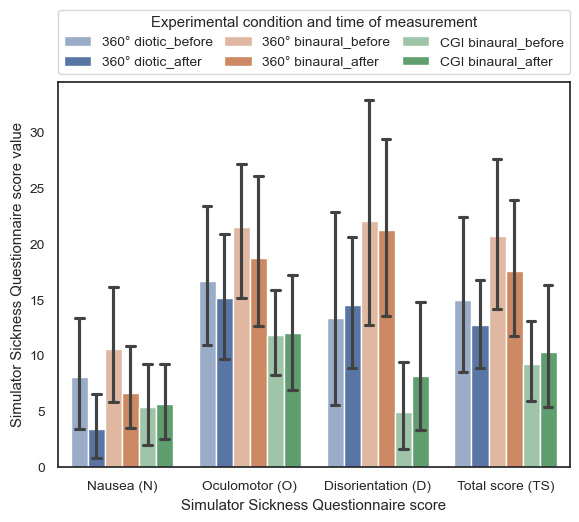

In [170]:
deep_palette = sns.color_palette("deep", 3)

def lighten_color(color, amount=0.5):
    try:
        c = mcolors.cnames[color]
    except:
        c = mcolors.to_rgb(color)
    white = mcolors.to_rgb('white')
    lightened_color = mcolors.to_rgb(tuple([(1 - amount) * c[i] + amount * white[i] for i in range(3)]))
    return lightened_color

paired_palette = []
for color in deep_palette:
    before_color = lighten_color(color, 0.4)
    after_color = lighten_color(color, 0)
    paired_palette.append(before_color)
    paired_palette.append(after_color)

ssq_combined_df = pd.concat([pre_ssq_df, post_ssq_df])
ssq_combined_df["test_combined"] = ssq_combined_df["test_id"] + "_" + ssq_combined_df["test"]

melted_df = pd.melt(ssq_combined_df, id_vars='test_combined', value_vars=['N', 'O', 'D', 'TS'], var_name='category', value_name='mean_ssq_value')
hue_order = ['1_before', '1_after', '2_before', '2_after', '3_before', '3_after']
plt.figure(figsize=(6.6, 5))
ax = sns.barplot(x='category', y='mean_ssq_value', hue='test_combined', palette=paired_palette, data=melted_df, hue_order=hue_order, errorbar=('ci', 95), capsize=.4)
ax.set_xlabel("Simulator Sickness Questionnaire score")
ax.set_xticklabels(["Nausea (N)", "Oculomotor (O)", "Disorientation (D)", "Total score (TS)"])
ax.set_ylabel("Simulator Sickness Questionnaire score value")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, title='Experimental condition and time of measurement', labels=['360° diotic_before', '360° diotic_after', '360° binaural_before', '360° binaural_after', 'CGI binaural_before', 'CGI binaural_after'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)

# ax = sns.barplot(x='category', y='mean_ssq_value', hue='test_combined', data=pd.melt(ssq_combined_df, id_vars='test_combined', value_vars=['N', 'O', 'D', 'TS'], var_name='category', value_name='mean_ssq_value'), errorbar=('ci', 95))
d(ax)
save_fig(ax, "", "plots/mean_ssq_before_after_test.pdf")
save_fig(ax, "", "plots/mean_ssq_before_after_test.png")

In [171]:
ssq_combined_df_aov_mod = ssq_combined_df
subject_numbers = (
    list(np.tile(np.arange(1, 26), 2)) +
    list(np.tile(np.arange(26, 62), 2)) +
    list(np.tile(np.arange(63, 97), 2))
)
ssq_combined_df_aov_mod['subject_number'] = subject_numbers
d(ssq_combined_df_aov_mod)

ssq_combined_df_aov_mod_reduced = ssq_combined_df_aov_mod[["test_id", "test", "test_combined", "subject_number", "N", "O", "D", "TS"]]
ssq_combined_df_aov_mod_reduced = ssq_combined_df_aov_mod_reduced.reset_index(drop=True)
d(ssq_combined_df_aov_mod_reduced)

d("Nausea (N) ART:")
pandas2ri.activate()
r_df = pandas2ri.py2rpy(ssq_combined_df_aov_mod_reduced)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
# Change the following to mixed somehow
ro.r('''
df$test_id <- factor(df$test_id)
df$test <- factor(df$test)
library(ARTool)
m <- art(N ~ test_id * test + (1|subject_number), data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
post_hoc_res = ro.r('''
res <- art.con(m, "test_id:test", adjust="none")
df_res <- as.data.frame(res)
df_filtered <- subset(df_res, contrast %in% c("1,after - 1,before", "2,after - 2,before", "3,after - 3,before"))
df_filtered$p.value_corr <- pmin(df_filtered$p.value * 3, 1)
df_filtered
''')
d(pandas2ri.rpy2py(post_hoc_res))

d("Nausea (N) Old:")
aov = pg.rm_anova(data=ssq_combined_df_aov_mod_reduced, dv="N", within="test", subject="subject_number", correction='auto', effsize="np2")
d(aov)
posthoc = pg.pairwise_tukey(data=ssq_combined_df_aov_mod_reduced, dv="N", between="test_combined")
d(posthoc)



d("Oculumotor (O) ART:")
pandas2ri.activate()
r_df = pandas2ri.py2rpy(ssq_combined_df_aov_mod_reduced)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
ro.r('''
df$test_id <- factor(df$test_id)
df$test <- factor(df$test)
library(ARTool)
m <- art(O ~ test_id * test + (1|subject_number), data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
post_hoc_res = ro.r('''
res <- art.con(m, "test_id:test", adjust="none")
df_res <- as.data.frame(res)
df_filtered <- subset(df_res, contrast %in% c("1,after - 1,before", "2,after - 2,before", "3,after - 3,before"))
df_filtered$p.value_corr <- pmin(df_filtered$p.value * 3, 1)
df_filtered
''')
d(pandas2ri.rpy2py(post_hoc_res))

d("Oculumotor (O) Old:")
aov = pg.rm_anova(data=ssq_combined_df_aov_mod_reduced, dv="O", within="test", subject="subject_number", correction='auto', detailed=True, effsize="np2")
d(aov)
posthoc = pg.pairwise_tukey(data=ssq_combined_df_aov_mod_reduced, dv="O", between="test_combined")
d(posthoc)


d("Disorientation (D) ART:")
pandas2ri.activate()
r_df = pandas2ri.py2rpy(ssq_combined_df_aov_mod_reduced)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
ro.r('''
df$test_id <- factor(df$test_id)
df$test <- factor(df$test)
library(ARTool)
m <- art(D ~ test_id * test + (1|subject_number), data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
post_hoc_res = ro.r('''
res <- art.con(m, "test_id:test", adjust="none")
df_res <- as.data.frame(res)
df_filtered <- subset(df_res, contrast %in% c("1,after - 1,before", "2,after - 2,before", "3,after - 3,before"))
df_filtered$p.value_corr <- pmin(df_filtered$p.value * 3, 1)
df_filtered
''')
d(pandas2ri.rpy2py(post_hoc_res))

d("Disorientation (D) Old:")
aov = pg.rm_anova(data=ssq_combined_df_aov_mod_reduced, dv="D", within="test", subject="subject_number", correction='auto', detailed=True, effsize="np2")
d(aov)
posthoc = pg.pairwise_tukey(data=ssq_combined_df_aov_mod_reduced, dv="D", between="test_combined")
d(posthoc)



d("Total Score (TS) ART:")
pandas2ri.activate()
r_df = pandas2ri.py2rpy(ssq_combined_df_aov_mod_reduced)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
ro.r('''
df$test_id <- factor(df$test_id)
df$test <- factor(df$test)
library(ARTool)
m <- art(TS ~ test_id * test + (1|subject_number), data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
post_hoc_res = ro.r('''
res <- art.con(m, "test_id:test", adjust="none")
df_res <- as.data.frame(res)
df_filtered <- subset(df_res, contrast %in% c("1,after - 1,before", "2,after - 2,before", "3,after - 3,before"))
df_filtered$p.value_corr <- pmin(df_filtered$p.value * 3, 1)
df_filtered
''')
d(pandas2ri.rpy2py(post_hoc_res))

d("Total Score (TS) Old:")
aov = pg.rm_anova(data=ssq_combined_df_aov_mod_reduced, dv="TS", within="test", subject="subject_number", correction='auto', detailed=True, effsize="np2")
d(aov)
posthoc = pg.pairwise_tukey(data=ssq_combined_df_aov_mod_reduced, dv="TS", between="test_combined")
d(posthoc)

,subject_number,test_id,allgemeines_unbehagen_bzw_unwohlsein,ermuedung,kopfschmerzen,ueberanstrengte_augen,schwierigkeiten_mit_sehschaerfe,erhoehte_speichelbildung,schwitzen,uebelkeit__erbrechen_konzentrationsschwierigkeiten,druckgefuehl_im_kopfbereich,verschwommene_sicht,schwindelgefuehl__bei_geoeffneten_augen_,schwindelgefuehl__bei_geschlossenen_augen_,gleichgewichtsstoerungen,magenbeschwerden,aufstossen,N,O,D,TS,test,test_combined
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,9.54,22.74,27.84,22.44,before,1_before
1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,before,1_before
2,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,7.58,0.00,3.74,before,1_before
3,4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,7.58,0.00,3.74,before,1_before
4,5,1,0,1,1,1,1,0,1,0,1,0,0,1,1,0,0,9.54,30.32,55.68,33.66,before,1_before
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,92,3,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0.00,22.74,0.00,11.22,after,3_after
30,93,3,1,2,0,2,1,1,1,0,1,2,0,1,0,0,0,28.62,60.64,55.68,56.10,after,3_after
31,94,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,after,3_after
32,95,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,after,3_after


,test_id,test,test_combined,subject_number,N,O,D,TS
0,1,before,1_before,1,9.54,22.74,27.84,22.44
1,1,before,1_before,2,0.00,0.00,0.00,0.00
2,1,before,1_before,3,0.00,7.58,0.00,3.74
3,1,before,1_before,4,0.00,7.58,0.00,3.74
4,1,before,1_before,5,9.54,30.32,55.68,33.66
...,...,...,...,...,...,...,...,...
185,3,after,3_after,92,0.00,22.74,0.00,11.22
186,3,after,3_after,93,28.62,60.64,55.68,56.10
187,3,after,3_after,94,0.00,0.00,0.00,0.00
188,3,after,3_after,95,0.00,0.00,0.00,0.00


'Nausea (N) ART:'

,Term,F,Df,Df.res,Pr(>F)
test_id,test_id,1.247761,2.0,146.370448,0.290183
test,test,4.274723,1.0,164.806576,0.040246
test_id:test,test_id:test,2.474225,2.0,149.032960,0.087682


,contrast,estimate,SE,df,t.ratio,p.value,p.value_corr
1,"1,after - 1,before",-17.175966,13.074211,183.998074,-1.313729,0.190573,0.571719
10,"2,after - 2,before",-14.132959,10.866535,183.976845,-1.300595,0.195024,0.585072
15,"3,after - 3,before",2.528905,11.191083,183.986400,0.225975,0.821472,1.000000


'Nausea (N) Old:'

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,test,1,26,0.138298,0.712993,0.005291,1.0


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1_after,1_before,3.434400,8.013600,-4.579200,3.369566,-1.358988,0.751342,-0.425715
1,1_after,2_after,3.434400,6.625000,-3.190600,3.101506,-1.028726,0.907762,-0.300140
2,1_after,2_before,3.434400,10.600000,-7.165600,3.101506,-2.310361,0.195184,-0.539849
3,1_after,3_after,3.434400,5.611765,-2.177365,3.138669,-0.693722,0.982466,-0.235809
4,1_after,3_before,3.434400,5.331176,-1.896776,3.138669,-0.604325,0.990622,-0.197689
5,1_before,2_after,8.013600,6.625000,1.388600,3.101506,0.447718,0.997705,0.110933
6,1_before,2_before,8.013600,10.600000,-2.586400,3.101506,-0.833917,0.960835,-0.174429
7,1_before,3_after,8.013600,5.611765,2.401835,3.138669,0.765240,0.972951,0.210238
8,1_before,3_before,8.013600,5.331176,2.682424,3.138669,0.854637,0.956549,0.228911
9,2_after,2_before,6.625000,10.600000,-3.975000,2.807972,-1.415612,0.717547,-0.280462


'Oculumotor (O) ART:'

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: boundary (singular) fit: see help('isSingular')



,Term,F,Df,Df.res,Pr(>F)
test_id,test_id,4.490738,2.0,145.692938,0.012807
test,test,1.019832,1.0,165.892437,0.314030
test_id:test,test_id:test,0.167140,2.0,148.982978,0.846240


R[write to console]: boundary (singular) fit: see help('isSingular')



,contrast,estimate,SE,df,t.ratio,p.value,p.value_corr
1,"1,after - 1,before",-3.000000,15.074289,184.0,-0.199014,0.842471,1.000000
10,"2,after - 2,before",-12.500000,12.529601,184.0,-0.997637,0.319765,0.959296
15,"3,after - 3,before",-8.705882,12.903978,184.0,-0.674667,0.500734,1.000000


'Oculumotor (O) Old:'

,Source,SS,DF,MS,F,p-unc,np2,eps
0,test,208.545452,1,208.545452,1.204159,0.282551,0.044264,1.0
1,Error,4502.879348,26,173.187667,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1_after,1_before,15.160000,16.676000,-1.516000,4.805957,-0.315442,0.999578,-0.091953
1,1_after,2_after,15.160000,18.739444,-3.579444,4.423627,-0.809165,0.965563,-0.188476
2,1_after,2_before,15.160000,21.476667,-6.316667,4.423627,-1.427938,0.709996,-0.369174
3,1_after,3_after,15.160000,12.038824,3.121176,4.476632,0.697215,0.982068,0.194705
4,1_after,3_before,15.160000,11.815882,3.344118,4.476632,0.747016,0.975659,0.257930
5,1_before,2_after,16.676000,18.739444,-2.063444,4.423627,-0.466460,0.997210,-0.103089
6,1_before,2_before,16.676000,21.476667,-4.800667,4.423627,-1.085233,0.886772,-0.263182
7,1_before,3_after,16.676000,12.038824,4.637176,4.476632,1.035863,0.905252,0.268454
8,1_before,3_before,16.676000,11.815882,4.860118,4.476632,1.085664,0.886602,0.335777
9,2_after,2_before,18.739444,21.476667,-2.737222,4.004964,-0.683457,0.983599,-0.137283


'Disorientation (D) ART:'

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: boundary (singular) fit: see help('isSingular')



,Term,F,Df,Df.res,Pr(>F)
test_id,test_id,8.413924,2.0,145.692938,0.000348
test,test,0.204739,1.0,165.892437,0.651513
test_id:test,test_id:test,0.383511,2.0,148.982978,0.682136


R[write to console]: boundary (singular) fit: see help('isSingular')



,contrast,estimate,SE,df,t.ratio,p.value,p.value_corr
1,"1,after - 1,before",9.580000,13.594171,184.0,0.704714,0.481879,1.0
10,"2,after - 2,before",8.375000,11.299342,184.0,0.741194,0.459521,1.0
15,"3,after - 3,before",7.705882,11.636959,184.0,0.662190,0.508678,1.0


'Disorientation (D) Old:'

,Source,SS,DF,MS,F,p-unc,np2,eps
0,test,1736.721067,1,1736.721067,12.919918,0.001333,0.331962,1.0
1,Error,3494.971733,26,134.421990,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1_after,1_before,14.476800,13.363200,1.113600,6.303499,0.176664,0.999976,0.059553
1,1_after,2_after,14.476800,21.266667,-6.789867,5.802035,-1.170256,0.850435,-0.294329
2,1_after,2_before,14.476800,22.040000,-7.563200,5.802035,-1.303543,0.782809,-0.284514
3,1_after,3_after,14.476800,8.188235,6.288565,5.871556,1.071022,0.892291,0.364640
4,1_after,3_before,14.476800,4.912941,9.563859,5.871556,1.628846,0.580574,0.667949
5,1_before,2_after,13.363200,21.266667,-7.903467,5.802035,-1.362189,0.749474,-0.320974
6,1_before,2_before,13.363200,22.040000,-8.676800,5.802035,-1.495475,0.667607,-0.310523
7,1_before,3_after,13.363200,8.188235,5.174965,5.871556,0.881362,0.950566,0.267510
8,1_before,3_before,13.363200,4.912941,8.450259,5.871556,1.439186,0.703052,0.503370
9,2_after,2_before,21.266667,22.040000,-0.773333,5.252915,-0.147220,0.999990,-0.026298


'Total Score (TS) ART:'

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: boundary (singular) fit: see help('isSingular')



,Term,F,Df,Df.res,Pr(>F)
test_id,test_id,6.880982,2.0,145.692938,0.001395
test,test,0.655833,1.0,165.892437,0.419195
test_id:test,test_id:test,0.406260,2.0,148.982978,0.666873


R[write to console]: boundary (singular) fit: see help('isSingular')



,contrast,estimate,SE,df,t.ratio,p.value,p.value_corr
1,"1,after - 1,before",1.800000,15.111485,184.0,0.119115,0.905314,1.0
10,"2,after - 2,before",-3.055556,12.560518,184.0,-0.243267,0.808070,1.0
15,"3,after - 3,before",-4.676471,12.935819,184.0,-0.361513,0.718131,1.0


'Total Score (TS) Old:'

,Source,SS,DF,MS,F,p-unc,np2,eps
0,test,299.438252,1,299.438252,3.796867,0.062218,0.127425,1.0
1,Error,2050.478548,26,78.864560,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1_after,1_before,12.716000,14.960000,-2.244000,4.623626,-0.485333,0.996632,-0.150006
1,1_after,2_after,12.716000,17.557222,-4.841222,4.255801,-1.137558,0.865073,-0.302977
2,1_after,2_before,12.716000,20.673889,-7.957889,4.255801,-1.869892,0.424041,-0.452946
3,1_after,3_after,12.716000,10.340000,2.376000,4.306795,0.551686,0.993849,0.170331
4,1_after,3_before,12.716000,9.240000,3.476000,4.306795,0.807097,0.965939,0.310757
5,1_before,2_after,14.960000,17.557222,-2.597222,4.255801,-0.610278,0.990190,-0.141468
6,1_before,2_before,14.960000,20.673889,-5.713889,4.255801,-1.342612,0.760816,-0.289183
7,1_before,3_after,14.960000,10.340000,4.620000,4.306795,1.072723,0.891639,0.276463
8,1_before,3_before,14.960000,9.240000,5.720000,4.306795,1.328134,0.769068,0.394911
9,2_after,2_before,17.557222,20.673889,-3.116667,3.853021,-0.808889,0.965614,-0.157793


In [172]:
ssq_combined_df_aov_mod2 = ssq_combined_df
ssq_combined_df_aov_mod_before = ssq_combined_df_aov_mod2.loc[ssq_combined_df_aov_mod["test"] == "before"]
ssq_combined_df_aov_mod_before['subject_number'] = list(np.arange(1, 96))
d(ssq_combined_df_aov_mod_before)
ssq_combined_df_aov_mod_after = ssq_combined_df_aov_mod2.loc[ssq_combined_df_aov_mod["test"] == "after"]
ssq_combined_df_aov_mod_after['subject_number'] = list(np.arange(1, 96))
d(ssq_combined_df_aov_mod_after)

shapiro = pg.normality(ssq_combined_df_aov_mod_before, dv="TS", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(ssq_combined_df_aov_mod_before, dv="TS", group="test_id", method='levene', alpha=0.05)
d(levene)

aov = pg.anova(data=ssq_combined_df_aov_mod_before, dv="N", between="test_id", detailed=True)
d(aov)
aov.to_csv("data_eval/anova_ssq_N_before.csv")

aov = pg.anova(data=ssq_combined_df_aov_mod_before, dv="O", between="test_id", detailed=True)
d(aov)
aov.to_csv("data_eval/anova_ssq_O_before.csv")

posthoc = pg.pairwise_tukey(data=ssq_combined_df_aov_mod_before, dv="O", between="test_id")
d(posthoc)
posthoc.to_csv("data_eval/posthoc_ssq_O_before_per_test.csv")

aov = pg.anova(data=ssq_combined_df_aov_mod_before, dv="D", between="test_id", detailed=True)
d(aov)
aov.to_csv("data_eval/anova_ssq_D_before.csv")

aov = pg.anova(data=ssq_combined_df_aov_mod_before, dv="TS", between="test_id", detailed=True)
d(aov)
aov.to_csv("data_eval/anova_ssq_TS_before.csv")


shapiro = pg.normality(ssq_combined_df_aov_mod_after, dv="TS", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(ssq_combined_df_aov_mod_after, dv="TS", group="test_id", method='levene', alpha=0.05)
d(levene)

aov = pg.anova(data=ssq_combined_df_aov_mod_after, dv="TS", between="test_id", detailed=True)
d(aov)
aov.to_csv("data_eval/anova_ssq_TS_after.csv")

C:\Users\sfremerey\AppData\Local\Temp\ipykernel_19644\1647941764.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssq_combined_df_aov_mod_before['subject_number'] = list(np.arange(1, 96))


,subject_number,test_id,allgemeines_unbehagen_bzw_unwohlsein,ermuedung,kopfschmerzen,ueberanstrengte_augen,schwierigkeiten_mit_sehschaerfe,erhoehte_speichelbildung,schwitzen,uebelkeit__erbrechen_konzentrationsschwierigkeiten,druckgefuehl_im_kopfbereich,verschwommene_sicht,schwindelgefuehl__bei_geoeffneten_augen_,schwindelgefuehl__bei_geschlossenen_augen_,gleichgewichtsstoerungen,magenbeschwerden,aufstossen,N,O,D,TS,test,test_combined
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,9.54,22.74,27.84,22.44,before,1_before
1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,before,1_before
2,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,7.58,0.00,3.74,before,1_before
3,4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,7.58,0.00,3.74,before,1_before
4,5,1,0,1,1,1,1,0,1,0,1,0,0,1,1,0,0,9.54,30.32,55.68,33.66,before,1_before
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,91,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0.00,15.16,0.00,7.48,before,3_before
30,92,3,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,19.08,22.74,0.00,18.70,before,3_before
31,93,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,before,3_before
32,94,3,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.00,7.58,13.92,7.48,before,3_before


C:\Users\sfremerey\AppData\Local\Temp\ipykernel_19644\1647941764.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssq_combined_df_aov_mod_after['subject_number'] = list(np.arange(1, 96))


,subject_number,test_id,allgemeines_unbehagen_bzw_unwohlsein,ermuedung,kopfschmerzen,ueberanstrengte_augen,schwierigkeiten_mit_sehschaerfe,erhoehte_speichelbildung,schwitzen,uebelkeit__erbrechen_konzentrationsschwierigkeiten,druckgefuehl_im_kopfbereich,verschwommene_sicht,schwindelgefuehl__bei_geoeffneten_augen_,schwindelgefuehl__bei_geschlossenen_augen_,gleichgewichtsstoerungen,magenbeschwerden,aufstossen,N,O,D,TS,test,test_combined
0,1,1,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0.00,37.90,27.84,26.18,after,1_after
1,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,7.58,0.00,3.74,after,1_after
2,3,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,28.62,30.32,13.92,29.92,after,1_after
3,4,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0.00,0.00,27.84,7.48,after,1_after
4,5,1,1,1,0,1,1,0,0,0,1,0,0,1,0,0,0,9.54,30.32,27.84,26.18,after,1_after
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,91,3,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0.00,22.74,0.00,11.22,after,3_after
30,92,3,1,2,0,2,1,1,1,0,1,2,0,1,0,0,0,28.62,60.64,55.68,56.10,after,3_after
31,93,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,after,3_after
32,94,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,after,3_after


,W,pval,normal
test_id,,,
1,0.778902,0.000103,False
2,0.858817,0.000306,False
3,0.743500,0.000002,False


,W,pval,equal_var
levene,4.069671,0.02025,False


,Source,SS,DF,MS,F,p-unc,np2
0,test_id,485.425882,2,242.712941,1.368387,0.259648,0.028888
1,Within,16318.189529,92,177.371625,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,test_id,1632.170892,2,816.085446,3.223445,0.044356,0.065486
1,Within,23291.810624,92,253.171855,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1,2,16.676000,21.476667,-4.800667,4.142394,-1.158911,0.480689,-0.263182
1,1,3,16.676000,11.815882,4.860118,4.192029,1.159371,0.480412,0.335777
2,2,3,21.476667,11.815882,9.660784,3.805100,2.538904,0.033911,0.626318


,Source,SS,DF,MS,F,p-unc,np2
0,test_id,5131.552165,2,2565.776082,4.694973,0.011441,0.092612
1,Within,50277.479650,92,546.494344,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,test_id,2286.447403,2,1143.223702,3.962846,0.02234,0.079316
1,Within,26540.671056,92,288.485555,NaN,NaN,NaN


,W,pval,normal
test_id,,,
1,0.838323,1.065709e-03,False
2,0.799569,1.596883e-05,False
3,0.691427,3.645809e-07,False


,W,pval,equal_var
levene,0.726014,0.486585,True


,Source,SS,DF,MS,F,p-unc,np2
0,test_id,943.666674,2,471.833337,1.918316,0.152682,0.040033
1,Within,22628.531322,92,245.962297,NaN,NaN,NaN


# Weinstein score

,subject_number,test_id,es_wuerde_mir_nichts_ausmachen__an_einer_lauten_strasse_zu_wohnen__wenn_meine_wohnung_schoen_waere,mir_fallt_laerm_heutzutage_mehr_auf_als_frueher,es_sollte_niemanden_gross_stoeren__wenn_ein_anderer_ab_und_zu_seine_stereoanlage_voll_aufdreht,im_kino_stoert_mich_fluestern_und_rascheln_von_bonbonpapier,ich_werde_leicht_durch_laerm_geweckt,wenn_es_an_meinem_arbeitsplatz_iaut_ist__dann_versuche_ich__tuer_oder_fenster_zu_schliessen_oder_anderswo_weiterzuarbeiten,es_aergert_mich__wenn_meine_nachbarn_laut_werden,an_die_meisten_geraeusche_gewoehne_ich_mich_ohne_grosse_schwierigkeiten,es_wuerde_mir_etwas_ausmachen__wenn_eine_wohnung__die_ich_gerne_mieten_wuerde__gegenueber_der_feuerwache_laege,manchmal_gehen_mir_geraeusche_auf_die_nerven_und_aergern_mich,sogar_musik__die_ich_eigentlich_mag__stoert_mich__wenn_ich_mich_konzentrieren_moechte,es_wuerde_mich_nicht_stoeren__die_alltagsgeraeusche_meiner_nachbarn__zb_schritte__wasserrauschen__zu_hoeren,wenn_ich_allein_sein_moechte__stoeren_mich_geraeusche_von_ausserhalb,ich_kann_mich_gut_konzentrieren__egal_was_um_mich_herum_geschieht,in_der_bibliothek_macht_es_mir_nichts_aus__wenn_sich_leute_unterhalten__solange_dies_leise_geschieht,oft_wuensche_ich_mir_voellige_stille,motorraeder_sollten_besser_schallgedaempft_sein,es_faellt_mir_schwer__mich_an_einem_lauten_ort_zu_entspannen,ich_werde_wuetend_auf_leute__die_laerm_machen__der_mich_vom_einschlafen_oder_vom_fortkommen_in_der_arbeit_abhaelt,es_wuerde_mir_nichts_ausmachen__in_einer_wohnung_mit_duennen_waenden_zu_leben,ich_bin_geraeuschempfindlich,mean_weinstein_score
0,1,1,4,3,4,2,4,4,3,4,4,4,3,1,4,3,3,4,4,3,2,4,4,3.380952
1,2,1,3,1,3,0,2,2,2,2,3,2,2,1,2,3,0,2,4,2,3,3,2,2.095238
2,3,1,1,2,3,3,3,2,3,1,3,3,4,1,1,3,1,1,2,3,2,4,3,2.333333
3,4,1,4,2,2,1,3,3,2,3,1,3,1,2,2,3,3,2,3,3,2,3,2,2.380952
4,5,1,1,1,4,3,1,3,2,1,2,3,1,0,2,1,1,0,2,1,2,2,1,1.619048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,30,3,3,3,2,1,3,3,2,3,3,4,3,1,2,3,1,3,2,3,3,4,3,2.619048
30,31,3,4,4,4,4,4,4,4,3,4,4,3,3,3,4,3,3,4,4,3,4,4,3.666667
31,32,3,3,2,4,2,3,4,3,2,2,4,0,1,2,3,2,1,3,2,4,3,3,2.523810
32,33,3,4,4,2,2,1,4,3,3,4,3,4,4,4,4,1,4,2,4,2,4,4,3.190476


C:\Users\sfremerey\AppData\Local\Temp\ipykernel_19644\3413855649.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['360° diotic', '360° binaural', 'CGI binaural'])


<Axes: xlabel='Experimental condition', ylabel='Weinstein score'>

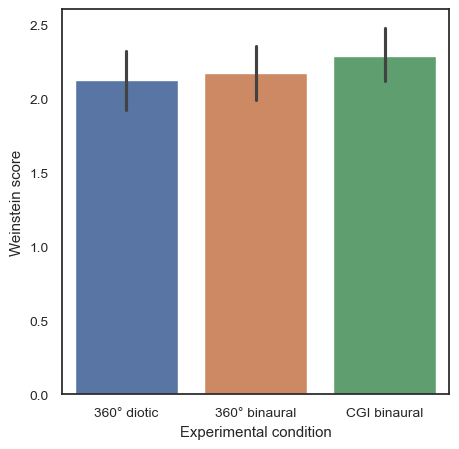

In [173]:
# Plot Weinstein Noise Sensitivity Scale (WNSS)
palette = sns.color_palette("deep")
sns.set_palette(palette)

columns_for_mean = ['es_wuerde_mir_nichts_ausmachen__an_einer_lauten_strasse_zu_wohnen__wenn_meine_wohnung_schoen_waere', 'mir_fallt_laerm_heutzutage_mehr_auf_als_frueher', 'es_sollte_niemanden_gross_stoeren__wenn_ein_anderer_ab_und_zu_seine_stereoanlage_voll_aufdreht', 'im_kino_stoert_mich_fluestern_und_rascheln_von_bonbonpapier', 'ich_werde_leicht_durch_laerm_geweckt', 'wenn_es_an_meinem_arbeitsplatz_iaut_ist__dann_versuche_ich__tuer_oder_fenster_zu_schliessen_oder_anderswo_weiterzuarbeiten', 'es_aergert_mich__wenn_meine_nachbarn_laut_werden', 'an_die_meisten_geraeusche_gewoehne_ich_mich_ohne_grosse_schwierigkeiten', 'es_wuerde_mir_etwas_ausmachen__wenn_eine_wohnung__die_ich_gerne_mieten_wuerde__gegenueber_der_feuerwache_laege', 'manchmal_gehen_mir_geraeusche_auf_die_nerven_und_aergern_mich', 'sogar_musik__die_ich_eigentlich_mag__stoert_mich__wenn_ich_mich_konzentrieren_moechte', 'es_wuerde_mich_nicht_stoeren__die_alltagsgeraeusche_meiner_nachbarn__zb_schritte__wasserrauschen__zu_hoeren', 'wenn_ich_allein_sein_moechte__stoeren_mich_geraeusche_von_ausserhalb', 'ich_kann_mich_gut_konzentrieren__egal_was_um_mich_herum_geschieht', 'in_der_bibliothek_macht_es_mir_nichts_aus__wenn_sich_leute_unterhalten__solange_dies_leise_geschieht', 'oft_wuensche_ich_mir_voellige_stille', 'motorraeder_sollten_besser_schallgedaempft_sein', 'es_faellt_mir_schwer__mich_an_einem_lauten_ort_zu_entspannen', 'ich_werde_wuetend_auf_leute__die_laerm_machen__der_mich_vom_einschlafen_oder_vom_fortkommen_in_der_arbeit_abhaelt', 'es_wuerde_mir_nichts_ausmachen__in_einer_wohnung_mit_duennen_waenden_zu_leben', 'ich_bin_geraeuschempfindlich']
weinstein_df = weinstein_df.apply(pd.to_numeric)
weinstein_df['mean_weinstein_score'] = weinstein_df[columns_for_mean].mean(axis=1)
d(weinstein_df)
# std_error = weinstein_df[columns_for_mean].std(axis=1) / np.sqrt(len(columns_for_mean))
ax = sns.barplot(x='test_id', y='mean_weinstein_score', hue="test_id", legend=False, palette="deep", data=weinstein_df)
ax.set_xlabel("Experimental condition")
ax.set_xticklabels(['360° diotic', '360° binaural', 'CGI binaural'])
ax.set_ylabel("Weinstein score")
# mean_weinstein_all_subjects = weinstein_df['mean_weinstein_score'].mean()
# plt.axhline(y=mean_weinstein_all_subjects, color='r', linestyle='--', label=f'Mean: {mean_percentage:.2f}%', linewidth=2)
d(ax)
save_fig(ax, "", "plots/barplot_weinstein_score_per_test.pdf")
save_fig(ax, "", "plots/barplot_weinstein_score_per_test.png")

C:\Users\sfremerey\AppData\Local\Temp\ipykernel_19644\2595031189.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['360° diotic', '360° binaural', 'CGI binaural'])


<Axes: xlabel='Experimental condition', ylabel='Weinstein score'>

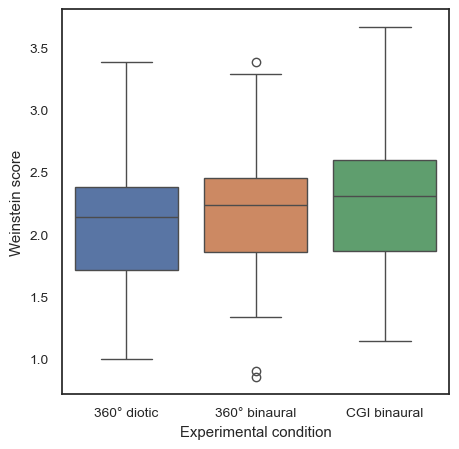

In [174]:
ax = sns.boxplot(x='test_id', y='mean_weinstein_score', hue="test_id", legend=False, palette="deep", data=weinstein_df)
ax.set_xlabel("Experimental condition")
ax.set_xticklabels(['360° diotic', '360° binaural', 'CGI binaural'])
ax.set_ylabel("Weinstein score")
d(ax)
save_fig(ax, "", "plots/boxplot_weinstein_score_per_test.pdf")
save_fig(ax, "", "plots/boxplot_weinstein_score_per_test.png")

In [175]:
weinstein_min = weinstein_df.groupby("test_id").mean_weinstein_score.min().sort_values(ascending=False)
weinstein_max = weinstein_df.groupby("test_id").mean_weinstein_score.max().sort_values(ascending=False)
weinstein_mean = weinstein_df.groupby("test_id").mean_weinstein_score.mean().sort_values(ascending=False)
weinstein_median = weinstein_df.groupby("test_id").mean_weinstein_score.median().sort_values(ascending=False)
weinstein_std = weinstein_df.groupby("test_id").mean_weinstein_score.std().sort_values(ascending=False)
weinstein_eval = pd.DataFrame({
    'Min': weinstein_min,
    'Max': weinstein_max,
    'Mean': weinstein_mean,
    'Median': weinstein_median,
    'SD': weinstein_std
})
weinstein_eval = weinstein_eval.T.applymap(lambda x: f"{x:.3f}")
d(weinstein_eval)
d(weinstein_eval.style.to_latex())

test_id,1,2,3
Min,1.000,0.857,1.143
Max,3.381,3.381,3.667
Mean,2.122,2.169,2.287
Median,2.143,2.238,2.310
SD,0.522,0.574,0.588


'\\begin{tabular}{llll}\ntest_id & 1 & 2 & 3 \\\\\nMin & 1.000 & 0.857 & 1.143 \\\\\nMax & 3.381 & 3.381 & 3.667 \\\\\nMean & 2.122 & 2.169 & 2.287 \\\\\nMedian & 2.143 & 2.238 & 2.310 \\\\\nSD & 0.522 & 0.574 & 0.588 \\\\\n\\end{tabular}\n'

In [176]:
weinstein_df_aov_mod = weinstein_df
weinstein_df_aov_mod['subject_number'] = list(np.arange(1, 96))
d(weinstein_df_aov_mod)

shapiro = pg.normality(weinstein_df_aov_mod, dv="mean_weinstein_score", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(weinstein_df_aov_mod, dv="mean_weinstein_score", group="test_id", method='levene', alpha=0.05)
d(levene)

aov = pg.anova(data=weinstein_df_aov_mod, dv="mean_weinstein_score", between="test_id", detailed=True)
d(aov)
aov.to_csv("data_eval/anova_weinstein.csv")

,subject_number,test_id,es_wuerde_mir_nichts_ausmachen__an_einer_lauten_strasse_zu_wohnen__wenn_meine_wohnung_schoen_waere,mir_fallt_laerm_heutzutage_mehr_auf_als_frueher,es_sollte_niemanden_gross_stoeren__wenn_ein_anderer_ab_und_zu_seine_stereoanlage_voll_aufdreht,im_kino_stoert_mich_fluestern_und_rascheln_von_bonbonpapier,ich_werde_leicht_durch_laerm_geweckt,wenn_es_an_meinem_arbeitsplatz_iaut_ist__dann_versuche_ich__tuer_oder_fenster_zu_schliessen_oder_anderswo_weiterzuarbeiten,es_aergert_mich__wenn_meine_nachbarn_laut_werden,an_die_meisten_geraeusche_gewoehne_ich_mich_ohne_grosse_schwierigkeiten,es_wuerde_mir_etwas_ausmachen__wenn_eine_wohnung__die_ich_gerne_mieten_wuerde__gegenueber_der_feuerwache_laege,manchmal_gehen_mir_geraeusche_auf_die_nerven_und_aergern_mich,sogar_musik__die_ich_eigentlich_mag__stoert_mich__wenn_ich_mich_konzentrieren_moechte,es_wuerde_mich_nicht_stoeren__die_alltagsgeraeusche_meiner_nachbarn__zb_schritte__wasserrauschen__zu_hoeren,wenn_ich_allein_sein_moechte__stoeren_mich_geraeusche_von_ausserhalb,ich_kann_mich_gut_konzentrieren__egal_was_um_mich_herum_geschieht,in_der_bibliothek_macht_es_mir_nichts_aus__wenn_sich_leute_unterhalten__solange_dies_leise_geschieht,oft_wuensche_ich_mir_voellige_stille,motorraeder_sollten_besser_schallgedaempft_sein,es_faellt_mir_schwer__mich_an_einem_lauten_ort_zu_entspannen,ich_werde_wuetend_auf_leute__die_laerm_machen__der_mich_vom_einschlafen_oder_vom_fortkommen_in_der_arbeit_abhaelt,es_wuerde_mir_nichts_ausmachen__in_einer_wohnung_mit_duennen_waenden_zu_leben,ich_bin_geraeuschempfindlich,mean_weinstein_score
0,1,1,4,3,4,2,4,4,3,4,4,4,3,1,4,3,3,4,4,3,2,4,4,3.380952
1,2,1,3,1,3,0,2,2,2,2,3,2,2,1,2,3,0,2,4,2,3,3,2,2.095238
2,3,1,1,2,3,3,3,2,3,1,3,3,4,1,1,3,1,1,2,3,2,4,3,2.333333
3,4,1,4,2,2,1,3,3,2,3,1,3,1,2,2,3,3,2,3,3,2,3,2,2.380952
4,5,1,1,1,4,3,1,3,2,1,2,3,1,0,2,1,1,0,2,1,2,2,1,1.619048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,91,3,3,3,2,1,3,3,2,3,3,4,3,1,2,3,1,3,2,3,3,4,3,2.619048
30,92,3,4,4,4,4,4,4,4,3,4,4,3,3,3,4,3,3,4,4,3,4,4,3.666667
31,93,3,3,2,4,2,3,4,3,2,2,4,0,1,2,3,2,1,3,2,4,3,3,2.523810
32,94,3,4,4,2,2,1,4,3,3,4,3,4,4,4,4,1,4,2,4,2,4,4,3.190476


,W,pval,normal
test_id,,,
1,0.971127,0.673757,True
2,0.980807,0.772234,True
3,0.983739,0.880872,True


,W,pval,equal_var
levene,0.24898,0.780119,True


,Source,SS,DF,MS,F,p-unc,np2
0,test_id,0.444305,2,0.222152,0.693746,0.502295,0.014857
1,Within,29.460362,92,0.320221,NaN,NaN,NaN


# IPQ

,subject_number,test_id,rating_type,rating
0,1,1,G1,3.00
1,2,1,G1,5.00
2,3,1,G1,3.00
3,4,1,G1,6.00
4,5,1,G1,4.00
...,...,...,...,...
375,30,3,REAL,2.00
376,31,3,REAL,2.75
377,32,3,REAL,1.50
378,33,3,REAL,0.75


C:\Users\sfremerey\AppData\Local\Temp\ipykernel_19644\3776279351.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['360° diotic', '360° binaural', 'CGI binaural'])


<Axes: xlabel='Experimental condition', ylabel='IPQ value'>

'Medians:'

,test_id,rating_type,rating
0,1,G1,3.000
1,1,INV,3.500
2,1,REAL,2.250
3,1,SP,3.400
4,2,G1,4.000
5,2,INV,4.125
6,2,REAL,2.500
7,2,SP,3.900
8,3,G1,3.500
9,3,INV,3.750


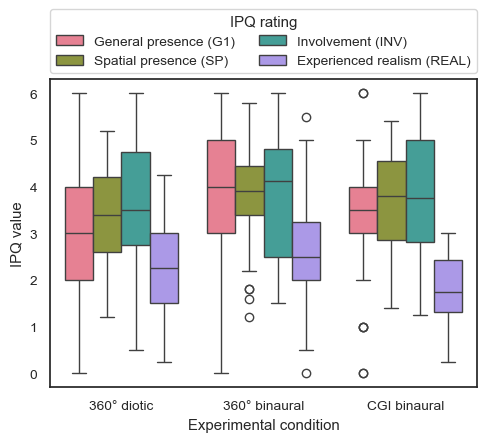

In [177]:
ipq_df_melted = ipq_df.melt(id_vars=["subject_number", "test_id"], value_vars=["G1", "SP", "INV", "REAL"],
                    var_name="rating_type", value_name="rating")
# G1 = general presence
# SP = spatial presence
# INV = involvement
# REAL = experienced realism
d(ipq_df_melted)
plt.figure(figsize=(5.5, 4))
ax = sns.boxplot(x='test_id', y='rating', hue="rating_type", palette="husl", data=ipq_df_melted)
ax.set_xlabel("Experimental condition")
ax.set_xticklabels(['360° diotic', '360° binaural', 'CGI binaural'])
ax.set_ylabel("IPQ value")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, title='IPQ rating', labels=["General presence (G1)", "Spatial presence (SP)", "Involvement (INV)", "Experienced realism (REAL)"], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

d(ax)
save_fig(ax, "", "plots/boxplot_ipq_evaluation.pdf")
save_fig(ax, "", "plots/boxplot_ipq_evaluation.png")
medians = ipq_df_melted.groupby(['test_id', 'rating_type'])['rating'].median().reset_index()
d("Medians:")
d(medians)

C:\Users\sfremerey\AppData\Local\Temp\ipykernel_19644\3618057878.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['360° diotic', '360° binaural', 'CGI binaural'])


<Axes: xlabel='Experimental condition', ylabel='Igroup Presence Questionnaire value'>

,test_id,rating_type,rating
0,1,G1,3.120000
1,1,INV,3.770000
2,1,REAL,2.270000
3,1,SP,3.376000
4,2,G1,3.611111
5,2,INV,3.847222
6,2,REAL,2.493056
7,2,SP,3.761111
8,3,G1,3.352941
9,3,INV,3.911765


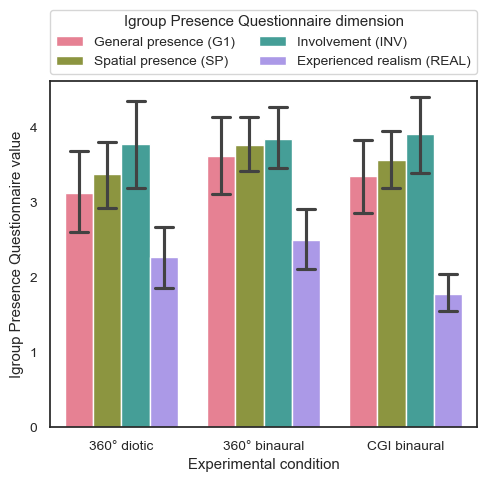

In [178]:
plt.figure(figsize=(5.5, 4.5))
ax = sns.barplot(x='test_id', y='rating', hue="rating_type", palette="husl", data=ipq_df_melted, errorbar=('ci', 95), capsize=.5)
ax.set_xlabel("Experimental condition")
ax.set_xticklabels(['360° diotic', '360° binaural', 'CGI binaural'])
ax.set_ylabel("Igroup Presence Questionnaire value")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, title='Igroup Presence Questionnaire dimension', labels=["General presence (G1)", "Spatial presence (SP)", "Involvement (INV)", "Experienced realism (REAL)"], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

d(ax)
save_fig(ax, "", "plots/barplot_ipq_evaluation.pdf")
save_fig(ax, "", "plots/barplot_ipq_evaluation.png")
d(ipq_df_melted.groupby(['test_id', 'rating_type'])['rating'].mean().reset_index())

In [179]:
ipq_df_aov_mod = ipq_df
ipq_df_aov_mod['subject_number'] = list(np.arange(1, 96))
d(ipq_df_aov_mod)


shapiro = pg.normality(ipq_df_aov_mod, dv="G1", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(ipq_df_aov_mod, dv="G1", group="test_id", method='levene', alpha=0.05)
d(levene)

aov = pg.anova(data=ipq_df_aov_mod, dv="G1", between="test_id", detailed=True)
d(aov)
aov.to_csv("data_eval/anova_ipq_G1.csv")
posthoc = pg.pairwise_tukey(data=ipq_df_aov_mod, dv="G1", between="test_id")
d(posthoc)


shapiro = pg.normality(ipq_df_aov_mod, dv="SP", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(ipq_df_aov_mod, dv="SP", group="test_id", method='levene', alpha=0.05)
d(levene)

aov = pg.anova(data=ipq_df_aov_mod, dv="SP", between="test_id", detailed=True)
d(aov)
aov.to_csv("data_eval/anova_ipq_SP.csv")
posthoc = pg.pairwise_tukey(data=ipq_df_aov_mod, dv="SP", between="test_id")
d(posthoc)


shapiro = pg.normality(ipq_df_aov_mod, dv="INV", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(ipq_df_aov_mod, dv="INV", group="test_id", method='levene', alpha=0.05)
d(levene)

aov = pg.anova(data=ipq_df_aov_mod, dv="INV", between="test_id", detailed=True)
d(aov)
aov.to_csv("data_eval/anova_ipq_INV.csv")
posthoc = pg.pairwise_tukey(data=ipq_df_aov_mod, dv="INV", between="test_id")
d(posthoc)


shapiro = pg.normality(ipq_df_aov_mod, dv="REAL", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(ipq_df_aov_mod, dv="REAL", group="test_id", method='levene', alpha=0.05)
d(levene)

aov = pg.anova(data=ipq_df_aov_mod, dv="REAL", between="test_id", detailed=True)
d(aov)
aov.to_csv("data_eval/anova_ipq_REAL.csv")
posthoc = pg.pairwise_tukey(data=ipq_df_aov_mod, dv="REAL", between="test_id")
d(posthoc)
aov.to_csv("data_eval/posthoc_ipq_REAL.csv")

,subject_number,test_id,G1,SP1,SP2,SP3,SP4,SP5,INV1,INV2,INV3,INV4,REAL1,REAL2,REAL3,REAL4,SP2U,INV3U,REAL1U,SP,INV,REAL
0,1,1,3,2,5,1,1,2,2,3,1,4,3,4,2,2,1,5,3,1.4,3.50,2.75
1,2,1,5,3,3,4,3,4,4,4,4,4,1,3,4,2,3,2,5,3.4,3.50,3.50
2,3,1,3,1,0,2,3,3,1,0,1,5,3,3,5,1,6,5,3,3.0,2.75,3.00
3,4,1,6,6,0,0,5,6,3,2,3,4,1,5,5,0,6,3,5,4.6,3.00,3.75
4,5,1,4,5,1,0,3,4,2,2,1,4,2,3,1,0,5,5,4,3.4,3.25,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,91,3,3,5,4,4,2,4,5,1,3,4,4,2,2,2,2,3,2,3.4,3.25,2.00
30,92,3,6,4,0,0,6,5,1,1,2,5,1,4,1,1,6,4,5,4.2,2.75,2.75
31,93,3,4,6,1,5,5,5,2,0,1,5,4,2,2,0,5,5,2,5.2,3.00,1.50
32,94,3,0,0,2,4,0,1,2,2,5,0,5,1,1,0,4,1,1,1.8,1.25,0.75


,W,pval,normal
test_id,,,
1,0.937768,0.131448,True
2,0.918249,0.011187,False
3,0.937886,0.053347,True


,W,pval,equal_var
levene,0.043756,0.957207,True


,Source,SS,DF,MS,F,p-unc,np2
0,test_id,3.629212,2,1.814606,0.735564,0.482032,0.015739
1,Within,226.960261,92,2.466959,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1,2,3.120000,3.611111,-0.491111,0.408907,-1.201033,0.455602,-0.306958
1,1,3,3.120000,3.352941,-0.232941,0.413807,-0.562923,0.840081,-0.148591
2,2,3,3.611111,3.352941,0.258170,0.375612,0.687332,0.771464,0.161322


,W,pval,normal
test_id,,,
1,0.968869,0.616526,True
2,0.949467,0.100609,True
3,0.954230,0.164293,True


,W,pval,equal_var
levene,0.269738,0.764181,True


,Source,SS,DF,MS,F,p-unc,np2
0,test_id,2.231334,2,1.115667,0.895387,0.411979,0.019093
1,Within,114.633508,92,1.246016,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1,2,3.376000,3.761111,-0.385111,0.290607,-1.325197,0.384919,-0.346455
1,1,3,3.376000,3.558824,-0.182824,0.294089,-0.621661,0.808641,-0.158498
2,2,3,3.761111,3.558824,0.202288,0.266944,0.757790,0.729694,0.179598


,W,pval,normal
test_id,,,
1,0.964331,0.507271,True
2,0.940665,0.053280,True
3,0.936434,0.048320,False


,W,pval,equal_var
levene,0.380702,0.684453,True


,Source,SS,DF,MS,F,p-unc,np2
0,test_id,0.289984,2,0.144992,0.070481,0.931996,0.00153
1,Within,189.260016,92,2.057174,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1,2,3.770000,3.847222,-0.077222,0.373404,-0.206806,0.976704,-0.054131
1,1,3,3.770000,3.911765,-0.141765,0.377878,-0.375160,0.925420,-0.092998
2,2,3,3.847222,3.911765,-0.064542,0.343000,-0.188171,0.980673,-0.045722


,W,pval,normal
test_id,,,
1,0.972656,0.712778,True
2,0.972224,0.489362,True
3,0.955351,0.177407,True


,W,pval,equal_var
levene,2.462989,0.09078,True


,Source,SS,DF,MS,F,p-unc,np2
0,test_id,9.186543,2,4.593271,4.311111,0.01623,0.085689
1,Within,98.021352,92,1.065449,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1,2,2.270000,2.493056,-0.223056,0.268726,-0.830048,0.685406,-0.189198
1,1,3,2.270000,1.779412,0.490588,0.271946,1.803990,0.173961,0.551245
2,2,3,2.493056,1.779412,0.713644,0.246845,2.891058,0.013170,0.685116


In [180]:
d("General presence (G1)")
pandas2ri.activate()
r_df = pandas2ri.py2rpy(ipq_df_aov_mod)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
# Change the following to mixed somehow
ro.r('''
df$test_id <- factor(df$test_id)
df$test <- factor(df$test)
library(ARTool)
m <- art(G1 ~ test_id, data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
post_hoc_res = ro.r('''
res <- art.con(m, "test_id", adjust="bonferroni")
df_res <- as.data.frame(res)
df_res
''')
d(pandas2ri.rpy2py(post_hoc_res))


d("Spatial presence (SP)")
pandas2ri.activate()
r_df = pandas2ri.py2rpy(ipq_df_aov_mod)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
# Change the following to mixed somehow
ro.r('''
df$test_id <- factor(df$test_id)
df$test <- factor(df$test)
library(ARTool)
m <- art(SP ~ test_id, data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
post_hoc_res = ro.r('''
res <- art.con(m, "test_id", adjust="bonferroni")
df_res <- as.data.frame(res)
df_res
''')
d(pandas2ri.rpy2py(post_hoc_res))


d("Involvement (INV)")
pandas2ri.activate()
r_df = pandas2ri.py2rpy(ipq_df_aov_mod)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
# Change the following to mixed somehow
ro.r('''
df$test_id <- factor(df$test_id)
df$test <- factor(df$test)
library(ARTool)
m <- art(INV ~ test_id, data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
post_hoc_res = ro.r('''
res <- art.con(m, "test_id", adjust="bonferroni")
df_res <- as.data.frame(res)
df_res
''')
d(pandas2ri.rpy2py(post_hoc_res))


d("Experienced realism (REAL)")
pandas2ri.activate()
r_df = pandas2ri.py2rpy(ipq_df_aov_mod)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
# Change the following to mixed somehow
ro.r('''
df$test_id <- factor(df$test_id)
df$test <- factor(df$test)
library(ARTool)
m <- art(REAL ~ test_id, data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
post_hoc_res = ro.r('''
res <- art.con(m, "test_id", adjust="bonferroni")
df_res <- as.data.frame(res)
df_res
''')
d(pandas2ri.rpy2py(post_hoc_res))

'General presence (G1)'

C:\Users\sfremerey\AppData\Roaming\Python\Python311\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


,Term,Df,Df.res,Sum Sq,Sum Sq.res,F value,Pr(>F)
test_id,test_id,2.0,92.0,1527.235294,66942.264706,1.049454,0.354282


,contrast,estimate,SE,df,t.ratio,p.value
1,test_id1 - test_id2,-10.100000,7.022633,92.0,-1.438207,0.461305
2,test_id1 - test_id3,-4.952941,7.106779,92.0,-0.696932,1.000000
3,test_id2 - test_id3,5.147059,6.450815,92.0,0.797893,1.000000


'Spatial presence (SP)'

C:\Users\sfremerey\AppData\Roaming\Python\Python311\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


,Term,Df,Df.res,Sum Sq,Sum Sq.res,F value,Pr(>F)
test_id,test_id,2.0,92.0,1300.807484,69823.192516,0.856981,0.427802


,contrast,estimate,SE,df,t.ratio,p.value
1,test_id1 - test_id2,-9.367778,7.172154,92.0,-1.306132,0.584292
2,test_id1 - test_id3,-5.001765,7.258092,92.0,-0.689129,1.000000
3,test_id2 - test_id3,4.366013,6.588162,92.0,0.662706,1.000000


'Involvement (INV)'

C:\Users\sfremerey\AppData\Roaming\Python\Python311\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


,Term,Df,Df.res,Sum Sq,Sum Sq.res,F value,Pr(>F)
test_id,test_id,2.0,92.0,104.260588,71081.739412,0.067471,0.934801


,contrast,estimate,SE,df,t.ratio,p.value
1,test_id1 - test_id2,-0.456667,7.236503,92.0,-0.063106,1.0
2,test_id1 - test_id3,-2.422353,7.323213,92.0,-0.330777,1.0
3,test_id2 - test_id3,-1.965686,6.647272,92.0,-0.295713,1.0


'Experienced realism (REAL)'

C:\Users\sfremerey\AppData\Roaming\Python\Python311\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


,Term,Df,Df.res,Sum Sq,Sum Sq.res,F value,Pr(>F)
test_id,test_id,2.0,92.0,6231.96165,64776.53835,4.425526,0.01462


,contrast,estimate,SE,df,t.ratio,p.value
1,test_id1 - test_id2,-4.476111,6.908100,92.0,-0.647951,1.000000
2,test_id1 - test_id3,13.848235,6.990874,92.0,1.980902,0.151766
3,test_id2 - test_id3,18.324346,6.345608,92.0,2.887721,0.014511


# Further data processing (ETL)

In [181]:
# Unity speaker_story_mapping
# Start to read every .json file, start with Scene5 as Scene1-4 is training
# And do it for every subject participating in the test
# Also load the _ratings.csv file from AVrate to get the corresponding ratings from
# the two questionnaires: NASA TLX & Schmutz et al.
scenes_to_read = ['5', '6', '7', '8', '9', '10', '11', '12', '13']
subjects_to_read = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
normalized_dfs = []
for test_id, test_name in zip(test_ids, test_names):
    for subject_to_read in subjects_to_read:
        for scene_to_read in scenes_to_read:
            try:
                df = pd.read_json('../subjective_data/{}/Unity/ecoclass-vr_chairs_speaker_story_mapping_{}_Scene{}.json'.format(test_name, subject_to_read, scene_to_read))
                scene_number = int(re.findall(r'\d+', scene_to_read)[0])
                nested_data = df.at[scene_number - 1, 'chairs_speaker_story_mapping']
                normalized_df = pd.json_normalize(nested_data)
                normalized_df["test_id"] = test_id
                normalized_df["scene"] = scene_to_read
                normalized_df["subject_number"] = subject_to_read
                normalized_dfs.append(normalized_df)
            except:
                None

speaker_story_mapping_df = pd.concat(normalized_dfs, ignore_index=True)
speaker_story_mapping_df = speaker_story_mapping_df.apply(pd.to_numeric)

# Get the amount of total stories, the amount of correctly assigned stories and the percentage of correctly assigned stories
story_columns = [col for col in speaker_story_mapping_df.columns if '.story' in col]
assigned_story_columns = [col for col in speaker_story_mapping_df.columns if '.assigned_story' in col]
story_columns.sort()
assigned_story_columns.sort()
speaker_story_mapping_df['total_stories_count'] = speaker_story_mapping_df[story_columns].apply(lambda x: (x != 11).sum(), axis=1)
speaker_story_mapping_df['assigned_stories_count'] = speaker_story_mapping_df[assigned_story_columns].apply(lambda x: (x != 11).sum(), axis=1)
speaker_story_mapping_df['correctly_assigned_stories_count'] = 0
for story_col, assigned_story_col in zip(story_columns, assigned_story_columns):
    speaker_story_mapping_df['correctly_assigned_stories_count'] += (speaker_story_mapping_df[story_col] != 11) & (speaker_story_mapping_df[story_col] == speaker_story_mapping_df[assigned_story_col]).astype(int)
speaker_story_mapping_df['correctly_assigned_stories_percentage'] = speaker_story_mapping_df['correctly_assigned_stories_count'] / speaker_story_mapping_df['total_stories_count'] * 100

# Calculate wrongly_assigned_stories
speaker_story_mapping_df['wrongly_assigned_stories_count'] = 0
speaker_story_mapping_df['no_assigned_stories_count'] = 0
for i in range(1, 21):
    story_col = f'chair_{i}.story'
    assigned_story_col = f'chair_{i}.assigned_story'
    speaker_story_mapping_df['wrongly_assigned_stories_count'] += ((speaker_story_mapping_df[story_col] != 11) & (speaker_story_mapping_df[assigned_story_col] != 11) & (speaker_story_mapping_df[story_col] != speaker_story_mapping_df[assigned_story_col])).astype(int)
    speaker_story_mapping_df['no_assigned_stories_count'] += ((speaker_story_mapping_df[story_col] != 11) & (speaker_story_mapping_df[assigned_story_col] == 11)).astype(int)
speaker_story_mapping_df['wrongly_assigned_stories_percentage'] = (speaker_story_mapping_df['wrongly_assigned_stories_count'] / speaker_story_mapping_df['total_stories_count']) * 100
speaker_story_mapping_df['no_assigned_stories_percentage'] = (speaker_story_mapping_df['no_assigned_stories_count'] / speaker_story_mapping_df['total_stories_count']) * 100

number_of_story_in_test = [(i % 9) + 1 for i in range(len(speaker_story_mapping_df))]
speaker_story_mapping_df['number_of_trial_in_test'] = number_of_story_in_test

d(speaker_story_mapping_df)
# speaker_story_mapping_df.to_excel("speaker_story_mapping_df.xlsx", sheet_name='speaker_story_mapping_df')

,chair_1.speaker,chair_1.story,chair_1.assigned_story,chair_2.speaker,chair_2.story,chair_2.assigned_story,chair_3.speaker,chair_3.story,chair_3.assigned_story,chair_4.speaker,chair_4.story,chair_4.assigned_story,chair_5.speaker,chair_5.story,chair_5.assigned_story,chair_6.speaker,chair_6.story,chair_6.assigned_story,chair_7.speaker,chair_7.story,chair_7.assigned_story,chair_8.speaker,chair_8.story,chair_8.assigned_story,chair_9.speaker,chair_9.story,chair_9.assigned_story,chair_10.speaker,chair_10.story,chair_10.assigned_story,chair_11.speaker,chair_11.story,chair_11.assigned_story,chair_12.speaker,chair_12.story,chair_12.assigned_story,chair_13.speaker,chair_13.story,chair_13.assigned_story,chair_14.speaker,chair_14.story,chair_14.assigned_story,chair_15.speaker,chair_15.story,chair_15.assigned_story,chair_16.speaker,chair_16.story,chair_16.assigned_story,chair_17.speaker,chair_17.story,chair_17.assigned_story,chair_18.speaker,chair_18.story,chair_18.assigned_story,chair_19.speaker,chair_19.story,chair_19.assigned_story,chair_20.speaker,chair_20.story,chair_20.assigned_story,test_id,scene,subject_number,total_stories_count,assigned_stories_count,correctly_assigned_stories_count,correctly_assigned_stories_percentage,wrongly_assigned_stories_count,no_assigned_stories_count,wrongly_assigned_stories_percentage,no_assigned_stories_percentage,number_of_trial_in_test
0,12,11,11,10,11,11,7,11,11,19,2,2,6,11,11,20,11,11,2,11,11,3,11,11,8,11,11,1,11,11,4,11,11,5,11,11,17,11,11,13,11,11,14,4,4,9,11,11,16,11,11,15,11,11,11,11,11,18,11,11,1,5,1,2,2,2,100.000000,0,0,0.000000,0.000000,1
1,4,11,11,5,11,11,10,11,11,16,11,11,17,3,11,11,11,11,13,11,11,12,2,11,7,4,11,8,11,11,14,6,11,6,7,2,20,11,11,15,8,11,9,9,11,19,11,11,2,11,11,1,11,11,3,11,11,18,11,11,1,6,1,7,1,0,0.000000,1,6,14.285714,85.714286,2
2,1,11,11,19,11,11,4,8,8,15,11,11,8,11,11,17,11,11,14,11,11,11,11,11,9,11,11,10,10,10,6,11,11,12,11,11,5,11,11,20,11,11,7,11,11,16,11,11,13,11,11,18,11,11,3,6,6,2,11,11,1,7,1,3,3,3,100.000000,0,0,0.000000,0.000000,3
3,4,11,11,15,11,11,3,7,7,7,11,11,10,2,11,13,5,5,5,11,11,11,11,11,6,11,11,12,11,11,20,3,11,1,11,11,14,11,11,19,11,11,18,11,11,9,11,11,16,9,11,8,11,11,2,11,11,17,11,11,1,8,1,5,2,2,40.000000,0,3,0.000000,60.000000,4
4,15,11,11,11,4,11,8,11,11,5,5,5,3,11,11,10,11,11,20,9,11,19,1,11,6,11,11,9,11,11,14,11,11,17,11,11,12,11,11,16,11,11,4,11,11,13,11,11,18,11,11,2,11,11,1,11,11,7,11,11,1,9,1,4,1,1,25.000000,0,3,0.000000,75.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850,1,11,11,7,11,11,13,11,11,2,11,11,19,11,11,9,11,11,16,11,11,15,7,7,5,11,11,10,11,11,3,11,11,20,11,11,11,5,5,4,11,11,12,11,11,14,11,11,6,11,11,8,2,2,18,11,11,17,11,11,3,9,34,3,3,3,100.000000,0,0,0.000000,0.000000,5
851,9,11,11,13,11,11,18,11,11,1,11,11,2,11,11,3,11,11,10,5,5,7,11,11,12,11,11,15,11,11,20,11,11,17,11,11,8,11,11,4,11,11,6,11,11,14,11,11,16,11,11,5,11,11,19,2,2,11,11,11,3,10,34,2,2,2,100.000000,0,0,0.000000,0.000000,6
852,16,11,11,14,11,11,5,5,5,20,11,11,15,11,11,6,11,11,17,11,11,2,8,8,12,4,4,19,11,11,13,11,11,11,11,11,4,11,11,3,11,11,10,11,11,9,11,11,18,11,11,7,11,11,8,10,10,1,11,11,3,11,34,4,4,4,100.000000,0,0,0.000000,0.000000,7
853,1,8,8,19,11,11,14,5,11,18,11,11,20,4,4,8,1,11,17,11,11,7,2,2,15,10,10,16,11,11,5,11,11,10,6,6,4,11,11,13,11,11,11,11,11,9,3,3,12,11,11,6,9,9,3,11,11,2,7,11,3,12,34,10,7,7,70.000000,0,3,0.000000,30.000000,8


# Speaker-story-mapping performance (percentage of correctly assigned stories)

<Axes: xlabel='Total number of stories', ylabel='Correctly assigned stories [%]'>

,test_id,total_stories_count,correctly_assigned_stories_percentage
0,1,2,100.000000
1,1,3,100.000000
2,1,4,86.000000
3,1,5,66.400000
4,1,6,47.333333
5,1,7,29.142857
6,1,8,21.500000
7,1,9,10.666667
8,1,10,11.200000
9,2,2,97.222222


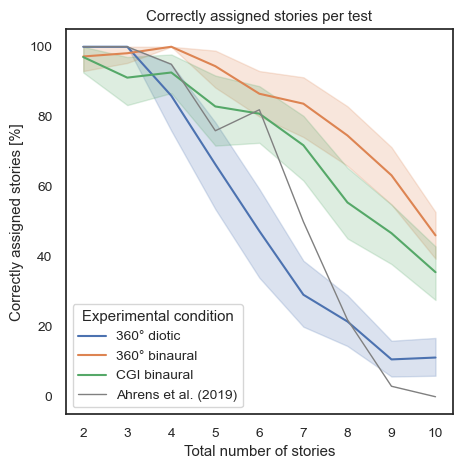

In [182]:
ax = sns.lineplot(x='total_stories_count', y='correctly_assigned_stories_percentage', hue='test_id', data=speaker_story_mapping_df, palette="deep")
ax.set_xlabel("Total number of stories")
ax.set_ylabel("Correctly assigned stories [%]")

# Add the results from Ahrens et al. (2019)
ahrens_x = [2, 3, 4, 5, 6, 7, 8, 9, 10]
ahrens_y = [100, 100, 95, 76, 82, 50, 22, 3, 0]
ax.plot(ahrens_x, ahrens_y, color='gray', linestyle='-', linewidth=1)
ahrens_handle = Line2D([0], [0], color='gray', linestyle='-', linewidth=1)
handles, labels = ax.get_legend_handles_labels()
handles.append(ahrens_handle)
labels.append('Ahrens et al. (2019)')

ax.legend(handles=handles, title='Experimental condition', labels=['360° diotic', '360° binaural', 'CGI binaural', 'Ahrens et al. (2019)'])

d(ax)
save_fig(ax, "Correctly assigned stories per test", "plots/lineplot_speaker_story_mapping_percentage_per_test.pdf")
save_fig(ax, "Correctly assigned stories per test", "plots/lineplot_speaker_story_mapping_percentage_per_test.png")
d(speaker_story_mapping_df.groupby(["test_id", "total_stories_count"])["correctly_assigned_stories_percentage"].mean().reset_index())

In [183]:
# 1) Put Ahrens data in a DataFrame
ahrens_df = pd.DataFrame({
    'total_stories_count': ahrens_x,
    'ahrens_value': ahrens_y
})

# Dictionary to store correlation results for each test
correlation_results = {}

for test_id in speaker_story_mapping_df['test_id'].unique():
    # 2) Filter your data for this test_id and restrict to Ahrens' x-values
    test_df = speaker_story_mapping_df[
        speaker_story_mapping_df['test_id'] == test_id
    ].copy()
    test_df = test_df[test_df['total_stories_count'].isin(ahrens_x)]
    
    # 3) Merge on 'total_stories_count'
    merged_df = pd.merge(test_df, ahrens_df, on='total_stories_count', how='inner')
    
    # Make sure they're sorted by total_stories_count if you like
    merged_df.sort_values('total_stories_count', inplace=True)
    
    # 4) Compute Pearson correlation
    #    Compare your "correctly_assigned_stories_percentage"
    #    vs. "ahrens_value"
    if len(merged_df) > 1:
        r, p = pearsonr(
            merged_df['ahrens_value'],
            merged_df['correctly_assigned_stories_percentage']
        )
        correlation_results[test_id] = (r, p)
    else:
        # If there's only 1 overlapping point, correlation is undefined
        correlation_results[test_id] = (None, None)

# 5) Print the results
for test_id, (corr_val, p_val) in correlation_results.items():
    if corr_val is not None:
        print(f"{test_id}: Pearson r = {corr_val:.3f}, p-value = {p_val:.3g}")
    else:
        print(f"{test_id}: Not enough points for correlation.")


1: Pearson r = 0.805, p-value = 1.79e-52
2: Pearson r = 0.633, p-value = 1.2e-37
3: Pearson r = 0.650, p-value = 3.47e-38


<Axes: xlabel='Total number of stories', ylabel='Correctly assigned stories [%]'>

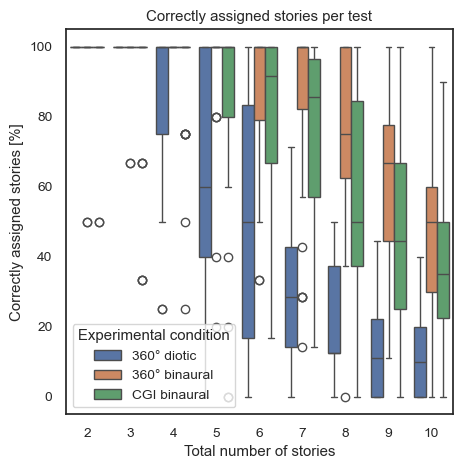

In [184]:
ax = sns.boxplot(x='total_stories_count', y='correctly_assigned_stories_percentage', hue='test_id', data=speaker_story_mapping_df, palette="deep")
ax.set_xlabel("Total number of stories")
ax.set_ylabel("Correctly assigned stories [%]")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, title='Experimental condition', labels=['360° diotic', '360° binaural', 'CGI binaural', 'Ahrens et al. (2019)'])
d(ax)

save_fig(ax, "Correctly assigned stories per test", "plots/boxplot_speaker_story_mapping_percentage_per_test.pdf")
save_fig(ax, "Correctly assigned stories per test", "plots/boxplot_speaker_story_mapping_percentage_per_test.png")

In [185]:
speaker_story_mapping_df_aov_mod = speaker_story_mapping_df[["subject_number", "test_id", "total_stories_count", "correctly_assigned_stories_percentage"]]
speaker_story_mapping_df_aov_mod['subject_number'] = (speaker_story_mapping_df_aov_mod.index // 9) + 1

d(speaker_story_mapping_df_aov_mod)

shapiro = pg.normality(speaker_story_mapping_df_aov_mod, dv="correctly_assigned_stories_percentage", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(speaker_story_mapping_df_aov_mod, dv="correctly_assigned_stories_percentage", group="test_id", method='levene', alpha=0.05)
d(levene)

# box_m = pg.box_m(speaker_story_mapping_df_aov_mod, dvs=["correctly_assigned_stories_percentage", "no_assigned_stories_percentage"], group="test_id", alpha=0.001)
# d(box_m)

aov = pg.mixed_anova(data=speaker_story_mapping_df_aov_mod, dv="correctly_assigned_stories_percentage", within="total_stories_count", subject="subject_number", between="test_id", correction='auto', effsize='np2')
d(aov)
aov.to_csv("data_eval/anova_speaker_story_mapping_percentage_per_test.csv")

post_hoc = pg.pairwise_tests(
    data=speaker_story_mapping_df_aov_mod,
    dv="correctly_assigned_stories_percentage",
    within="total_stories_count",
    between="test_id",
    subject="subject_number",
    padjust="bonf"
)
d(post_hoc)
post_hoc.to_csv("data_eval/post-hoc_story_mapping_percentage_per_test.csv")

C:\Users\sfremerey\AppData\Local\Temp\ipykernel_19644\1696602280.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speaker_story_mapping_df_aov_mod['subject_number'] = (speaker_story_mapping_df_aov_mod.index // 9) + 1


,subject_number,test_id,total_stories_count,correctly_assigned_stories_percentage
0,1,1,2,100.000000
1,1,1,7,0.000000
2,1,1,3,100.000000
3,1,1,5,40.000000
4,1,1,4,25.000000
...,...,...,...,...
850,95,3,3,100.000000
851,95,3,2,100.000000
852,95,3,4,100.000000
853,95,3,10,70.000000


,W,pval,normal
test_id,,,
1,0.824122,3.095272e-15,False
2,0.715782,4.229081e-23,False
3,0.817494,2.761890e-18,False


,W,pval,equal_var
levene,51.16506,1.036694e-21,False


C:\Users\sfremerey\AppData\Roaming\Python\Python311\site-packages\pingouin\parametric.py:1572: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,test_id,122346.042986,2,92,61173.021493,30.190747,8.305343e-11,NaN,0.396252,NaN,NaN,NaN,NaN
1,total_stories_count,431346.806036,8,736,53918.350755,200.490215,3.810345e-179,2.803889e-80,0.685460,0.517826,False,0.069365,6.327866e-33
2,Interaction,66665.209926,16,736,4166.575620,15.493012,5.400752e-37,NaN,0.251948,NaN,NaN,NaN,NaN


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurre

,Contrast,total_stories_count,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,total_stories_count,-,2.0,3.0,True,True,1.341926,94.000000,two-sided,1.828524e-01,1.000000e+00,bonf,0.27,0.145667
1,total_stories_count,-,2.0,4.0,True,True,2.066691,94.000000,two-sided,4.151328e-02,1.000000e+00,bonf,0.865,0.298775
2,total_stories_count,-,2.0,5.0,True,True,5.279716,94.000000,two-sided,8.306101e-07,2.990196e-05,bonf,1.669e+04,0.701174
3,total_stories_count,-,2.0,6.0,True,True,7.662228,94.000000,two-sided,1.622196e-11,5.839906e-10,bonf,5.361e+08,1.049360
4,total_stories_count,-,2.0,7.0,True,True,9.539365,94.000000,two-sided,1.752769e-15,6.309969e-14,bonf,3.731e+12,1.307610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,total_stories_count * test_id,9,1,3,False,True,-6.971926,51.109680,two-sided,5.965176e-09,1.610597e-07,bonf,2.378e+06,-1.651048
62,total_stories_count * test_id,9,2,3,False,True,2.643494,67.829852,two-sided,1.018295e-02,2.749397e-01,bonf,4.528,0.625032
63,total_stories_count * test_id,10,1,2,False,True,-7.616796,58.893464,two-sided,2.463581e-10,6.651668e-09,bonf,2.918e+07,-1.821660
64,total_stories_count * test_id,10,1,3,False,True,-4.887772,54.946882,two-sided,9.239441e-06,2.494649e-04,bonf,1900.972,-1.180172


In [186]:
pandas2ri.activate()
r_df = pandas2ri.py2rpy(speaker_story_mapping_df_aov_mod)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
# Change the following to mixed somehow
ro.r('''
df$test_id <- factor(df$test_id)
df$total_stories_count <- factor(df$total_stories_count)
library(ARTool)
m <- art(correctly_assigned_stories_percentage ~ test_id * total_stories_count  + (1|subject_number), data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
pandas2ri.rpy2py(anova_res).to_csv("data_eval/art_anova_story_mapping_percentage_per_test.csv")
post_hoc_res = ro.r('''
res <- art.con(m, "test_id", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
d(pandas2ri.rpy2py(post_hoc_res))

post_hoc_res = ro.r('''
res <- art.con(m, "test_id:total_stories_count", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
post_hoc_res_df = pandas2ri.rpy2py(post_hoc_res)
desired_contrasts = ['1,2 - 2,2',
'1,2 - 3,2',
'2,2 - 3,2',
 '1,3 - 2,3',
 '1,3 - 3,3',
 '2,3 - 3,3',
 '1,4 - 2,4',
 '1,4 - 3,4',
'2,4 - 3,4',
 '1,5 - 2,5',
 '1,5 - 3,5',
'2,5 - 3,5',
 '1,6 - 2,6',
 '1,6 - 3,6',
'2,6 - 3,6',
 '1,7 - 2,7',
 '1,7 - 3,7',
'2,7 - 3,7',
 '1,8 - 2,8',
 '1,8 - 3,8',
'2,8 - 3,8',
 '1,9 - 2,9',
 '1,9 - 3,9',
'2,9 - 3,9',
 '1,10 - 2,10',
 '1,10 - 3,10',
'2,10 - 3,10'
]
post_hoc_res_df_filtered = post_hoc_res_df[post_hoc_res_df['contrast'].isin(desired_contrasts)].copy()
pvals = post_hoc_res_df_filtered['p.value'].values
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')
post_hoc_res_df_filtered['p.value_corr'] = pvals_corrected

# sort "contrast" 
post_hoc_res_df_filtered['contrast'] = pd.Categorical(
    post_hoc_res_df_filtered['contrast'],
    categories=desired_contrasts,
    ordered=True
)
post_hoc_res_df_filtered.sort_values('contrast', inplace=True)

d(post_hoc_res_df_filtered)
post_hoc_res_df_filtered.to_csv("data_eval/art_post-hoc_story_mapping_percentage_per_test.csv")

,Term,F,Df,Df.res,Pr(>F)
test_id,test_id,38.199053,2.0,92.0,8.370061e-13
total_stories_count,total_stories_count,245.070116,8.0,736.0,9.668415e-202
test_id:total_stories_count,test_id:total_stories_count,23.779652,16.0,736.0,2.738374e-56


R[write to console]: NOTE: Results may be misleading due to involvement in interactions



,contrast,estimate,SE,df,t.ratio,p.value
1,test_id1 - test_id2,-328.915926,37.645254,92.0,-8.737248,1.034815e-13
2,test_id1 - test_id3,-201.606013,38.096328,92.0,-5.292006,8.162104e-07
3,test_id2 - test_id3,127.309913,34.579991,92.0,3.681606,3.906508e-04


,contrast,estimate,SE,df,t.ratio,p.value,p.value_corr
35,"1,2 - 2,2",22.305556,37.132882,371.378541,0.600696,5.484092e-01,1.000000e+00
44,"1,2 - 3,2",23.617647,37.577816,371.378541,0.628500,5.300630e-01,1.000000e+00
224,"2,2 - 3,2",1.312092,34.109339,371.378541,0.038467,9.693358e-01,1.000000e+00
60,"1,3 - 2,3",18.027778,37.132882,371.378541,0.485494,6.276125e-01,1.000000e+00
69,"1,3 - 3,3",71.250000,37.577816,371.378541,1.896066,5.872735e-02,1.000000e+00
240,"2,3 - 3,3",53.222222,34.109339,371.378541,1.560342,1.195309e-01,1.000000e+00
84,"1,4 - 2,4",-112.900000,37.132882,371.378541,-3.040432,2.529974e-03,6.830930e-02
93,"1,4 - 3,4",-43.061765,37.577816,371.378541,-1.145936,2.525596e-01,1.000000e+00
255,"2,4 - 3,4",69.838235,34.109339,371.378541,2.047481,4.131392e-02,1.000000e+00
107,"1,5 - 2,5",-208.263333,37.132882,371.378541,-5.608596,3.989503e-08,1.077166e-06


# Speaker-story-mapping performance (percentage of not assigned stories)

<Axes: xlabel='Total number of stories', ylabel='Not assigned stories [%]'>

,test_id,total_stories_count,no_assigned_stories_percentage
0,1,2,0.000000
1,1,3,0.000000
2,1,4,8.000000
3,1,5,27.200000
4,1,6,41.333333
5,1,7,57.142857
6,1,8,72.500000
7,1,9,77.333333
8,1,10,79.600000
9,2,2,0.000000


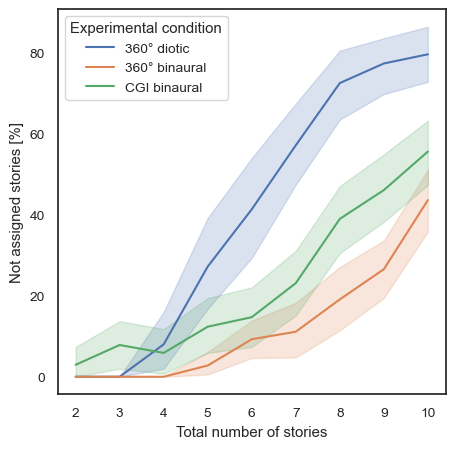

In [187]:
ax = sns.lineplot(x='total_stories_count', y='no_assigned_stories_percentage', hue='test_id', data=speaker_story_mapping_df, palette="deep")
ax.set_ylabel("Not assigned stories [%]")
ax.set_xlabel("Total number of stories")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, title='Experimental condition', labels=['360° diotic', '360° binaural', 'CGI binaural'])
d(ax)
d(speaker_story_mapping_df.groupby(["test_id", "total_stories_count"])["no_assigned_stories_percentage"].mean().reset_index())

save_fig(ax, "", "plots/lineplot_speaker_story_mapping_percentage_notassignedstories_per_test.pdf")
save_fig(ax, "", "plots/lineplot_speaker_story_mapping_percentage_notassignedstories_per_test.png")

In [188]:
# Compute deviation
deviation_list = []
num_chairs = 20

for idx, row in speaker_story_mapping_df.iterrows():
    deviation = 0
    for i in range(1, num_chairs + 1):
        story_col = f'chair_{i}.story'
        assigned_story_col = f'chair_{i}.assigned_story'
        actual_story = row[story_col]
        assigned_story = row[assigned_story_col]
        if actual_story != assigned_story and assigned_story != 11:
            for j in range(1, num_chairs + 1):
                if row[f'chair_{j}.story'] == assigned_story and i != j:
                    direct_distance = abs(i - j)
                    circular_distance = num_chairs - direct_distance
                    deviation += (min(direct_distance, circular_distance)) * 18  # to get deviation in degrees
                    break
    deviation_list.append(deviation)

speaker_story_mapping_df['deviation_count'] = deviation_list
d(speaker_story_mapping_df)
# speaker_story_mapping_df.to_excel("speaker_story_mapping_df.xlsx", sheet_name='speaker_story_mapping_df')

,chair_1.speaker,chair_1.story,chair_1.assigned_story,chair_2.speaker,chair_2.story,chair_2.assigned_story,chair_3.speaker,chair_3.story,chair_3.assigned_story,chair_4.speaker,chair_4.story,chair_4.assigned_story,chair_5.speaker,chair_5.story,chair_5.assigned_story,chair_6.speaker,chair_6.story,chair_6.assigned_story,chair_7.speaker,chair_7.story,chair_7.assigned_story,chair_8.speaker,chair_8.story,chair_8.assigned_story,chair_9.speaker,chair_9.story,chair_9.assigned_story,chair_10.speaker,chair_10.story,chair_10.assigned_story,chair_11.speaker,chair_11.story,chair_11.assigned_story,chair_12.speaker,chair_12.story,chair_12.assigned_story,chair_13.speaker,chair_13.story,chair_13.assigned_story,chair_14.speaker,chair_14.story,chair_14.assigned_story,chair_15.speaker,chair_15.story,chair_15.assigned_story,chair_16.speaker,chair_16.story,chair_16.assigned_story,chair_17.speaker,chair_17.story,chair_17.assigned_story,chair_18.speaker,chair_18.story,chair_18.assigned_story,chair_19.speaker,chair_19.story,chair_19.assigned_story,chair_20.speaker,chair_20.story,chair_20.assigned_story,test_id,scene,subject_number,total_stories_count,assigned_stories_count,correctly_assigned_stories_count,correctly_assigned_stories_percentage,wrongly_assigned_stories_count,no_assigned_stories_count,wrongly_assigned_stories_percentage,no_assigned_stories_percentage,number_of_trial_in_test,deviation_count
0,12,11,11,10,11,11,7,11,11,19,2,2,6,11,11,20,11,11,2,11,11,3,11,11,8,11,11,1,11,11,4,11,11,5,11,11,17,11,11,13,11,11,14,4,4,9,11,11,16,11,11,15,11,11,11,11,11,18,11,11,1,5,1,2,2,2,100.000000,0,0,0.000000,0.000000,1,0
1,4,11,11,5,11,11,10,11,11,16,11,11,17,3,11,11,11,11,13,11,11,12,2,11,7,4,11,8,11,11,14,6,11,6,7,2,20,11,11,15,8,11,9,9,11,19,11,11,2,11,11,1,11,11,3,11,11,18,11,11,1,6,1,7,1,0,0.000000,1,6,14.285714,85.714286,2,72
2,1,11,11,19,11,11,4,8,8,15,11,11,8,11,11,17,11,11,14,11,11,11,11,11,9,11,11,10,10,10,6,11,11,12,11,11,5,11,11,20,11,11,7,11,11,16,11,11,13,11,11,18,11,11,3,6,6,2,11,11,1,7,1,3,3,3,100.000000,0,0,0.000000,0.000000,3,0
3,4,11,11,15,11,11,3,7,7,7,11,11,10,2,11,13,5,5,5,11,11,11,11,11,6,11,11,12,11,11,20,3,11,1,11,11,14,11,11,19,11,11,18,11,11,9,11,11,16,9,11,8,11,11,2,11,11,17,11,11,1,8,1,5,2,2,40.000000,0,3,0.000000,60.000000,4,0
4,15,11,11,11,4,11,8,11,11,5,5,5,3,11,11,10,11,11,20,9,11,19,1,11,6,11,11,9,11,11,14,11,11,17,11,11,12,11,11,16,11,11,4,11,11,13,11,11,18,11,11,2,11,11,1,11,11,7,11,11,1,9,1,4,1,1,25.000000,0,3,0.000000,75.000000,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850,1,11,11,7,11,11,13,11,11,2,11,11,19,11,11,9,11,11,16,11,11,15,7,7,5,11,11,10,11,11,3,11,11,20,11,11,11,5,5,4,11,11,12,11,11,14,11,11,6,11,11,8,2,2,18,11,11,17,11,11,3,9,34,3,3,3,100.000000,0,0,0.000000,0.000000,5,0
851,9,11,11,13,11,11,18,11,11,1,11,11,2,11,11,3,11,11,10,5,5,7,11,11,12,11,11,15,11,11,20,11,11,17,11,11,8,11,11,4,11,11,6,11,11,14,11,11,16,11,11,5,11,11,19,2,2,11,11,11,3,10,34,2,2,2,100.000000,0,0,0.000000,0.000000,6,0
852,16,11,11,14,11,11,5,5,5,20,11,11,15,11,11,6,11,11,17,11,11,2,8,8,12,4,4,19,11,11,13,11,11,11,11,11,4,11,11,3,11,11,10,11,11,9,11,11,18,11,11,7,11,11,8,10,10,1,11,11,3,11,34,4,4,4,100.000000,0,0,0.000000,0.000000,7,0
853,1,8,8,19,11,11,14,5,11,18,11,11,20,4,4,8,1,11,17,11,11,7,2,2,15,10,10,16,11,11,5,11,11,10,6,6,4,11,11,13,11,11,11,11,11,9,3,3,12,11,11,6,9,9,3,11,11,2,7,11,3,12,34,10,7,7,70.000000,0,3,0.000000,30.000000,8,0


# Total time needed

<Axes: xlabel='Total number of stories', ylabel='Total time needed [s]'>

,test_id,total_stories_count,total_time_s
0,1,2,29.640000
1,1,3,57.720000
2,1,4,86.280000
3,1,5,111.800000
4,1,6,115.680000
5,1,7,118.320000
6,1,8,113.400000
7,1,9,119.040000
8,1,10,117.360000
9,2,2,22.944444


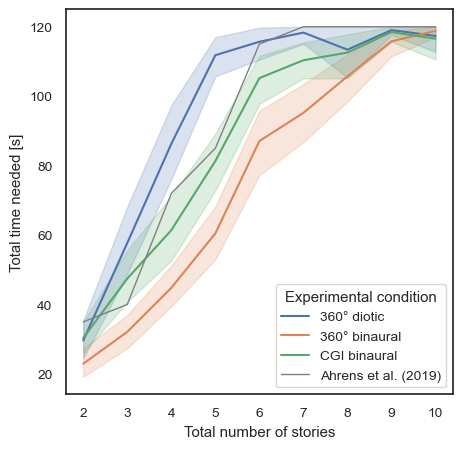

In [189]:
unique_test_ids = speaker_story_mapping_df['test_id'].unique()
palette = sns.color_palette("deep", len(unique_test_ids))
sns.set_palette(palette)

ax = sns.lineplot(x='total_stories_count', y='total_time_s', hue='test_id', data=headrotation_df, palette=palette)

# Add the results from Ahrens et al. (2019)
ahrens_x = [2, 3, 4, 5, 6, 7, 8, 9, 10]
ahrens_y = [35, 40, 72, 85, 115, 120, 120, 120, 120]
ax.plot(ahrens_x, ahrens_y, color='gray', linestyle='-', linewidth=1)
ahrens_handle = Line2D([0], [0], color='gray', linestyle='-', linewidth=1)
handles, labels = ax.get_legend_handles_labels()
handles.append(ahrens_handle)
labels.append('Ahrens et al. (2019)')

ax.set_xlabel("Total number of stories")
ax.set_ylabel("Total time needed [s]")
ax.legend(handles=handles, title='Experimental condition', labels=['360° diotic', '360° binaural', 'CGI binaural', 'Ahrens et al. (2019)'])
d(ax)

save_fig(ax, "", "plots/lineplot_totaltimeneeded_per_test.pdf")
save_fig(ax, "", "plots/lineplot_totaltimeneeded_per_test.png")
d(headrotation_df.groupby(["test_id", "total_stories_count"])["total_time_s"].mean().reset_index())

In [190]:
# Suppose your DataFrame is named 'df'
summary_df = (
    headrotation_df
    .groupby(['test_id', 'total_stories_count'])
    .agg(
        total_count=('total_time_s', 'size'),
        count_120=('total_time_s', lambda x: (x == 120).sum()),
        percentage_120=('total_time_s', lambda x: (x == 120).mean() * 100)
    )
)

# If you want a regular column index rather than a multiindex, you can do:
summary_df = summary_df.reset_index()

d(summary_df)

,test_id,total_stories_count,total_count,count_120,percentage_120
0,1,2,25,0,0.000000
1,1,3,25,1,4.000000
2,1,4,25,8,32.000000
3,1,5,25,17,68.000000
4,1,6,25,21,84.000000
5,1,7,25,23,92.000000
6,1,8,25,22,88.000000
7,1,9,25,23,92.000000
8,1,10,25,23,92.000000
9,2,2,36,0,0.000000


In [191]:
# 1) Put Ahrens data in a DataFrame
ahrens_df = pd.DataFrame({
    'total_stories_count': ahrens_x,
    'ahrens_value': ahrens_y
})

# Dictionary to store correlation results for each test
correlation_results = {}

for test_id in headrotation_df['test_id'].unique():
    # 2) Filter your data for this test_id and restrict to Ahrens' x-values
    test_df = headrotation_df[
        headrotation_df['test_id'] == test_id
    ].copy()
    test_df = test_df[test_df['total_stories_count'].isin(ahrens_x)]
    
    # 3) Merge on 'total_stories_count'
    merged_df = pd.merge(test_df, ahrens_df, on='total_stories_count', how='inner')
    
    # Make sure they're sorted by total_stories_count if you like
    merged_df.sort_values('total_stories_count', inplace=True)
    
    # 4) Compute Pearson correlation
    #    Compare your "correctly_assigned_stories_percentage"
    #    vs. "ahrens_value"
    if len(merged_df) > 1:
        r, p = pearsonr(
            merged_df['ahrens_value'],
            merged_df['total_time_s']
        )
        correlation_results[test_id] = (r, p)
    else:
        # If there's only 1 overlapping point, correlation is undefined
        correlation_results[test_id] = (None, None)

# 5) Print the results
for test_id, (corr_val, p_val) in correlation_results.items():
    if corr_val is not None:
        print(f"{test_id}: Pearson r = {corr_val:.3f}, p-value = {p_val:.3g}")
    else:
        print(f"{test_id}: Not enough points for correlation.")


1: Pearson r = 0.829, p-value = 3.77e-58
2: Pearson r = 0.837, p-value = 1.81e-86
3: Pearson r = 0.838, p-value = 6.54e-82


In [192]:
headrotation_df_aov_mod = headrotation_df
headrotation_df_aov_mod['subject_number'] = (headrotation_df_aov_mod.index // 9) + 1

d(headrotation_df_aov_mod)

shapiro = pg.normality(headrotation_df_aov_mod, dv="total_time_s", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(headrotation_df_aov_mod, dv="total_time_s", group="test_id", method='levene', alpha=0.05)
d(levene)

aov = pg.mixed_anova(data=headrotation_df_aov_mod, dv="total_time_s", within="total_stories_count", subject="subject_number", between="test_id", correction='auto', effsize='np2')
d(aov)
aov.to_csv("data_eval/anova_total_time_needed_per_test.csv")

post_hoc = pg.pairwise_tests(
    data=headrotation_df_aov_mod,
    dv="total_time_s",
    within="total_stories_count",
    between="test_id",
    subject="subject_number",
    padjust="bonf"
)
d(post_hoc)
post_hoc.to_csv("data_eval/post-hoc_total_time_needed_per_test.csv")

,subject_number,test_id,total_stories_count,total_time_s,total_pitch_explored,total_yaw_explored,total_degrees_explored,delta_minmax_pitch,delta_minmax_yaw,number_yaw_direction_changes,number_yaw_direction_changes_per_s
0,1,1,10,120.0,407.095176,2492.906113,2900.001289,48.162250,360.0000,59,0.491667
1,1,1,2,30.0,290.117333,1529.519737,1819.637070,45.980766,360.0000,26,0.866667
2,1,1,3,43.0,444.227190,1514.937271,1959.164461,58.791070,360.0000,49,1.139535
3,1,1,4,67.0,336.393080,1458.437674,1794.830754,42.789051,360.0000,24,0.358209
4,1,1,5,120.0,670.065976,2464.669624,3134.735600,47.265210,360.0000,75,0.625000
...,...,...,...,...,...,...,...,...,...,...,...
850,95,3,5,120.0,451.618628,2149.432621,2601.051250,34.295810,358.8708,63,0.525000
851,95,3,6,120.0,666.251841,2316.035590,2982.287431,32.611570,359.9743,90,0.750000
852,95,3,7,120.0,363.714789,1562.933264,1926.648053,32.019825,359.6326,50,0.416667
853,95,3,8,120.0,414.388384,1710.020308,2124.408693,34.098290,359.7290,51,0.425000


,W,pval,normal
test_id,,,
1,0.691119,4.375279e-20,False
2,0.849714,4.124935e-17,False
3,0.798086,3.359909e-19,False


,W,pval,equal_var
levene,16.476759,9.531279e-08,False


C:\Users\sfremerey\AppData\Roaming\Python\Python311\site-packages\pingouin\parametric.py:1572: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,test_id,58321.693393,2,92,29160.846696,25.161017,1.921859e-09,NaN,0.353579,NaN,NaN,NaN,NaN
1,total_stories_count,857173.567251,8,736,107146.695906,406.577614,3.713139e-264,7.533786e-117,0.815475,0.469647,False,0.030616,3.657118e-47
2,Interaction,40242.448943,16,736,2515.153059,9.543971,7.022473e-22,NaN,0.171827,NaN,NaN,NaN,NaN


,Contrast,total_stories_count,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,total_stories_count,-,2.0,3.0,True,True,-10.613585,94.000000,two-sided,9.191799e-18,3.309048e-16,bonf,6.192e+14,-0.880601
1,total_stories_count,-,2.0,4.0,True,True,-13.305067,94.000000,two-sided,2.454273e-23,8.835382e-22,bonf,1.736e+20,-1.466636
2,total_stories_count,-,2.0,5.0,True,True,-20.459047,94.000000,two-sided,2.166254e-36,7.798514e-35,bonf,1.168e+33,-2.252726
3,total_stories_count,-,2.0,6.0,True,True,-31.597757,94.000000,two-sided,7.346215e-52,2.644637e-50,bonf,2.118e+48,-3.536849
4,total_stories_count,-,2.0,7.0,True,True,-36.891183,94.000000,two-sided,1.026669e-57,3.696008e-56,bonf,1.284e+54,-4.372113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,total_stories_count * test_id,9,1,3,False,True,0.370812,46.664282,two-sided,7.124557e-01,1.000000e+00,bonf,0.283,0.086351
62,total_stories_count * test_id,9,2,3,False,True,-1.129539,62.944918,two-sided,2.629565e-01,1.000000e+00,bonf,0.424,-0.264525
63,total_stories_count * test_id,10,1,2,False,True,-0.660090,30.959049,two-sided,5.140774e-01,1.000000e+00,bonf,0.317,-0.191535
64,total_stories_count * test_id,10,1,3,False,True,0.229557,55.652450,two-sided,8.192777e-01,1.000000e+00,bonf,0.273,0.055712


In [193]:
pandas2ri.activate()
r_df = pandas2ri.py2rpy(headrotation_df_aov_mod)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
# Change the following to mixed somehow
ro.r('''
df$test_id <- factor(df$test_id)
df$total_stories_count <- factor(df$total_stories_count)
library(ARTool)
m <- art(total_time_s ~ test_id * total_stories_count  + (1|subject_number), data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
pandas2ri.rpy2py(anova_res).to_csv("data_eval/art_anova_total_time_needed_per_test.csv")
post_hoc_res = ro.r('''
res <- art.con(m, "test_id", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
d(pandas2ri.rpy2py(post_hoc_res))

post_hoc_res = ro.r('''
res <- art.con(m, "test_id:total_stories_count", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
post_hoc_res_df = pandas2ri.rpy2py(post_hoc_res)
desired_contrasts = ['1,2 - 2,2',
'1,2 - 3,2',
'2,2 - 3,2',
 '1,3 - 2,3',
 '1,3 - 3,3',
 '2,3 - 3,3',
 '1,4 - 2,4',
 '1,4 - 3,4',
'2,4 - 3,4',
 '1,5 - 2,5',
 '1,5 - 3,5',
'2,5 - 3,5',
 '1,6 - 2,6',
 '1,6 - 3,6',
'2,6 - 3,6',
 '1,7 - 2,7',
 '1,7 - 3,7',
'2,7 - 3,7',
 '1,8 - 2,8',
 '1,8 - 3,8',
'2,8 - 3,8',
 '1,9 - 2,9',
 '1,9 - 3,9',
'2,9 - 3,9',
 '1,10 - 2,10',
 '1,10 - 3,10',
'2,10 - 3,10'
]
post_hoc_res_df_filtered = post_hoc_res_df[post_hoc_res_df['contrast'].isin(desired_contrasts)].copy()
pvals = post_hoc_res_df_filtered['p.value'].values
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')
post_hoc_res_df_filtered['p.value_corr'] = pvals_corrected

# sort "contrast" 
post_hoc_res_df_filtered['contrast'] = pd.Categorical(
    post_hoc_res_df_filtered['contrast'],
    categories=desired_contrasts,
    ordered=True
)
post_hoc_res_df_filtered.sort_values('contrast', inplace=True)

d(post_hoc_res_df_filtered)
post_hoc_res_df_filtered.to_csv("data_eval/art_post-hoc_total_time_needed_per_test.csv")

,Term,F,Df,Df.res,Pr(>F)
test_id,test_id,36.250566,2.0,92.0,2.457373e-12
total_stories_count,total_stories_count,337.804444,8.0,736.0,1.753172e-240
test_id:total_stories_count,test_id:total_stories_count,16.815895,16.0,736.0,3.259292e-40


R[write to console]: NOTE: Results may be misleading due to involvement in interactions



,contrast,estimate,SE,df,t.ratio,p.value
1,test_id1 - test_id2,295.099630,34.755853,92.0,8.490645,3.404779e-13
2,test_id1 - test_id3,155.860523,35.172305,92.0,4.431342,2.581367e-05
3,test_id2 - test_id3,-139.239107,31.925860,92.0,-4.361327,3.368729e-05


,contrast,estimate,SE,df,t.ratio,p.value,p.value_corr
35,"1,2 - 2,2",37.580556,32.029057,496.262593,1.173327,2.412276e-01,1.000000e+00
44,"1,2 - 3,2",-4.217647,32.412836,496.262593,-0.130123,8.965220e-01,1.000000e+00
224,"2,2 - 3,2",-41.798203,29.421093,496.262593,-1.420688,1.560354e-01,1.000000e+00
60,"1,3 - 2,3",137.732222,32.029057,496.262593,4.300227,2.055113e-05,5.548805e-04
69,"1,3 - 3,3",45.936471,32.412836,496.262593,1.417231,1.570429e-01,1.000000e+00
240,"2,3 - 3,3",-91.795752,29.421093,496.262593,-3.120066,1.913340e-03,5.166018e-02
84,"1,4 - 2,4",231.566111,32.029057,496.262593,7.229876,1.839716e-12,4.967233e-11
93,"1,4 - 3,4",150.271176,32.412836,496.262593,4.636163,4.544106e-06,1.226909e-04
255,"2,4 - 3,4",-81.294935,29.421093,496.262593,-2.763151,5.937253e-03,1.603058e-01
107,"1,5 - 2,5",300.760556,32.029057,496.262593,9.390241,2.165517e-19,5.846896e-18


# Further data processing (ETL), distance between speakers

In [194]:
# Compute pairwise distances between speakers [# of chairs]
pairwise_distances = []
num_chairs = 20
for idx, row in speaker_story_mapping_df.iterrows():
    distances = 0
    for i in range(1, num_chairs + 1):
        for j in range(i + 1, num_chairs + 1):
            story_i = row[f'chair_{i}.story']
            story_j = row[f'chair_{j}.story']
            if story_i != story_j and story_i != 11 and story_j != 11:
                subject_number = row["subject_number"]
                scene = row["scene"]
                direct_distance = abs(i - j)
                circular_distance = num_chairs - direct_distance
                distances += min(direct_distance, circular_distance) * 18
                # d(f"Subject: {subject_number}, Scene: {scene}, story_i: {i}, story_j: {j}, distances: {distances}")
                break
    pairwise_distances.append(distances)

speaker_story_mapping_df['distance_between_speakers'] = pairwise_distances
d(speaker_story_mapping_df)

,chair_1.speaker,chair_1.story,chair_1.assigned_story,chair_2.speaker,chair_2.story,chair_2.assigned_story,chair_3.speaker,chair_3.story,chair_3.assigned_story,chair_4.speaker,chair_4.story,chair_4.assigned_story,chair_5.speaker,chair_5.story,chair_5.assigned_story,chair_6.speaker,chair_6.story,chair_6.assigned_story,chair_7.speaker,chair_7.story,chair_7.assigned_story,chair_8.speaker,chair_8.story,chair_8.assigned_story,chair_9.speaker,chair_9.story,chair_9.assigned_story,chair_10.speaker,chair_10.story,chair_10.assigned_story,chair_11.speaker,chair_11.story,chair_11.assigned_story,chair_12.speaker,chair_12.story,chair_12.assigned_story,chair_13.speaker,chair_13.story,chair_13.assigned_story,chair_14.speaker,chair_14.story,chair_14.assigned_story,chair_15.speaker,chair_15.story,chair_15.assigned_story,chair_16.speaker,chair_16.story,chair_16.assigned_story,chair_17.speaker,chair_17.story,chair_17.assigned_story,chair_18.speaker,chair_18.story,chair_18.assigned_story,chair_19.speaker,chair_19.story,chair_19.assigned_story,chair_20.speaker,chair_20.story,chair_20.assigned_story,test_id,scene,subject_number,total_stories_count,assigned_stories_count,correctly_assigned_stories_count,correctly_assigned_stories_percentage,wrongly_assigned_stories_count,no_assigned_stories_count,wrongly_assigned_stories_percentage,no_assigned_stories_percentage,number_of_trial_in_test,deviation_count,distance_between_speakers
0,12,11,11,10,11,11,7,11,11,19,2,2,6,11,11,20,11,11,2,11,11,3,11,11,8,11,11,1,11,11,4,11,11,5,11,11,17,11,11,13,11,11,14,4,4,9,11,11,16,11,11,15,11,11,11,11,11,18,11,11,1,5,1,2,2,2,100.000000,0,0,0.000000,0.000000,1,0,162
1,4,11,11,5,11,11,10,11,11,16,11,11,17,3,11,11,11,11,13,11,11,12,2,11,7,4,11,8,11,11,14,6,11,6,7,2,20,11,11,15,8,11,9,9,11,19,11,11,2,11,11,1,11,11,3,11,11,18,11,11,1,6,1,7,1,0,0.000000,1,6,14.285714,85.714286,2,72,180
2,1,11,11,19,11,11,4,8,8,15,11,11,8,11,11,17,11,11,14,11,11,11,11,11,9,11,11,10,10,10,6,11,11,12,11,11,5,11,11,20,11,11,7,11,11,16,11,11,13,11,11,18,11,11,3,6,6,2,11,11,1,7,1,3,3,3,100.000000,0,0,0.000000,0.000000,3,0,288
3,4,11,11,15,11,11,3,7,7,7,11,11,10,2,11,13,5,5,5,11,11,11,11,11,6,11,11,12,11,11,20,3,11,1,11,11,14,11,11,19,11,11,18,11,11,9,11,11,16,9,11,8,11,11,2,11,11,17,11,11,1,8,1,5,2,2,40.000000,0,3,0.000000,60.000000,4,0,252
4,15,11,11,11,4,11,8,11,11,5,5,5,3,11,11,10,11,11,20,9,11,19,1,11,6,11,11,9,11,11,14,11,11,17,11,11,12,11,11,16,11,11,4,11,11,13,11,11,18,11,11,2,11,11,1,11,11,7,11,11,1,9,1,4,1,1,25.000000,0,3,0.000000,75.000000,5,0,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850,1,11,11,7,11,11,13,11,11,2,11,11,19,11,11,9,11,11,16,11,11,15,7,7,5,11,11,10,11,11,3,11,11,20,11,11,11,5,5,4,11,11,12,11,11,14,11,11,6,11,11,8,2,2,18,11,11,17,11,11,3,9,34,3,3,3,100.000000,0,0,0.000000,0.000000,5,0,180
851,9,11,11,13,11,11,18,11,11,1,11,11,2,11,11,3,11,11,10,5,5,7,11,11,12,11,11,15,11,11,20,11,11,17,11,11,8,11,11,4,11,11,6,11,11,14,11,11,16,11,11,5,11,11,19,2,2,11,11,11,3,10,34,2,2,2,100.000000,0,0,0.000000,0.000000,6,0,144
852,16,11,11,14,11,11,5,5,5,20,11,11,15,11,11,6,11,11,17,11,11,2,8,8,12,4,4,19,11,11,13,11,11,11,11,11,4,11,11,3,11,11,10,11,11,9,11,11,18,11,11,7,11,11,8,10,10,1,11,11,3,11,34,4,4,4,100.000000,0,0,0.000000,0.000000,7,0,288
853,1,8,8,19,11,11,14,5,11,18,11,11,20,4,4,8,1,11,17,11,11,7,2,2,15,10,10,16,11,11,5,11,11,10,6,6,4,11,11,13,11,11,11,11,11,9,3,3,12,11,11,6,9,9,3,11,11,2,7,11,3,12,34,10,7,7,70.000000,0,3,0.000000,30.000000,8,0,342


<Axes: xlabel='Total number of stories', ylabel='Distance between active speakers [°]'>

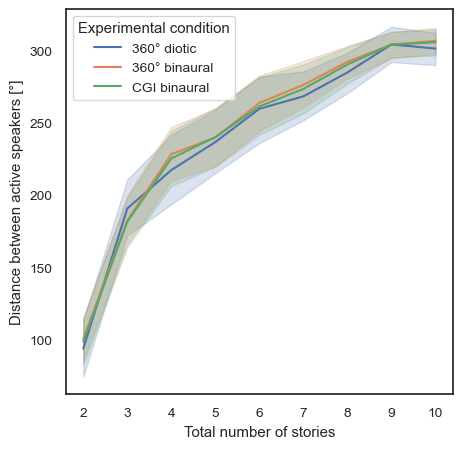

In [195]:
ax = sns.lineplot(x='total_stories_count', y='distance_between_speakers', hue='test_id', data=speaker_story_mapping_df, palette="deep")
ax.set_xlabel("Total number of stories")
ax.set_ylabel("Distance between active speakers [°]")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, title='Experimental condition', labels=['360° diotic', '360° binaural', 'CGI binaural'])
d(ax)
save_fig(ax, "", "plots/lineplot_distancebetweenspeakers_totalnumberofstories.pdf")
save_fig(ax, "", "plots/lineplot_distancebetweenspeakers_totalnumberofstories.png")

# NASA TLX & listening effort

In [196]:
columns_to_convert = ['subject_number', 'test_id', 'scene', 'rating']
nasatlx_df[columns_to_convert] = nasatlx_df[columns_to_convert].apply(pd.to_numeric)
d(nasatlx_df)

,subject_number,test_id,scene,rating_type,rating
0,1,1,5,nasatlx_effort,20.0
1,1,1,6,nasatlx_effort,99.0
2,1,1,7,nasatlx_effort,40.0
3,1,1,8,nasatlx_effort,90.0
4,1,1,9,nasatlx_effort,98.0
...,...,...,...,...,...
2137,34,3,9,listening_effort,11.0
2138,34,3,10,listening_effort,2.0
2139,34,3,11,listening_effort,53.0
2140,34,3,12,listening_effort,90.0


In [197]:
columns_to_convert = ['subject_number', 'test_id', 'scene', 'rating']
nasatlx_df_reduced = nasatlx_df[(nasatlx_df['rating_type'] != 'nasatlx_mental_workload_score')]
nasatlx_df_reduced[columns_to_convert] = nasatlx_df_reduced[columns_to_convert].apply(pd.to_numeric)
d(nasatlx_df_reduced)

C:\Users\sfremerey\AppData\Local\Temp\ipykernel_19644\2976973876.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nasatlx_df_reduced[columns_to_convert] = nasatlx_df_reduced[columns_to_convert].apply(pd.to_numeric)


,subject_number,test_id,scene,rating_type,rating
0,1,1,5,nasatlx_effort,20.0
1,1,1,6,nasatlx_effort,99.0
2,1,1,7,nasatlx_effort,40.0
3,1,1,8,nasatlx_effort,90.0
4,1,1,9,nasatlx_effort,98.0
...,...,...,...,...,...
2137,34,3,9,listening_effort,11.0
2138,34,3,10,listening_effort,2.0
2139,34,3,11,listening_effort,53.0
2140,34,3,12,listening_effort,90.0


,subject_number,test_id,scene,rating_type,rating,total_stories_count
0,1,1,5,nasatlx_effort,20.0,2
1,1,1,6,nasatlx_effort,99.0,7
2,1,1,7,nasatlx_effort,40.0,3
3,1,1,8,nasatlx_effort,90.0,5
4,1,1,9,nasatlx_effort,98.0,4
...,...,...,...,...,...,...
5125,34,3,9,listening_effort,11.0,3
5126,34,3,10,listening_effort,2.0,2
5127,34,3,11,listening_effort,53.0,4
5128,34,3,12,listening_effort,90.0,10


<Axes: xlabel='Total number of stories', ylabel='Score'>

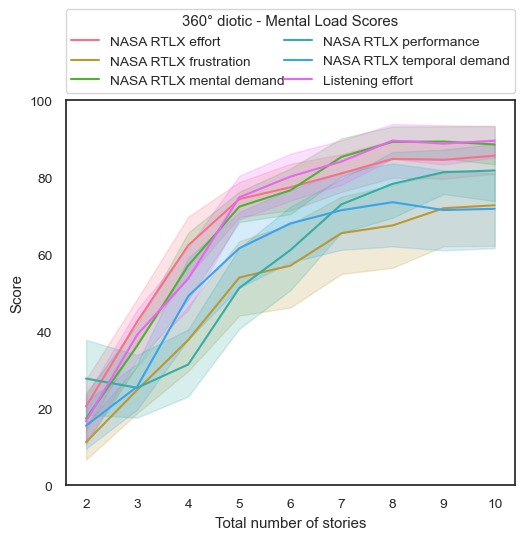

In [198]:
speaker_story_mapping_df = speaker_story_mapping_df.apply(pd.to_numeric)

nasatlx_df_reduced_merged = nasatlx_df_reduced.merge(
    speaker_story_mapping_df[['test_id', 'scene', 'subject_number', 'total_stories_count']],
    on=['test_id', 'scene', 'subject_number'],
    how='left'
)
d(nasatlx_df_reduced_merged)

plt.figure(figsize=(5.8, 5))
ax = sns.lineplot(x='total_stories_count', y='rating', hue='rating_type', data=nasatlx_df_reduced_merged.loc[nasatlx_df_reduced_merged['test_id'] == 1], palette="husl")
ax.set_xlabel("Total number of stories")
ax.set_ylabel("Score")
ax.set_ylim(0, 100)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, title='360° diotic - Mental Load Scores', labels=['NASA RTLX effort', 'NASA RTLX frustration', 'NASA RTLX mental demand', 'NASA RTLX performance', 'NASA RTLX temporal demand', 'Listening effort'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
d(ax)
save_fig(ax, "", "plots/lineplot_nasatlx_test_1.pdf")
save_fig(ax, "", "plots/lineplot_nasatlx_test_1.png")

<Axes: xlabel='Total number of stories', ylabel='Score'>

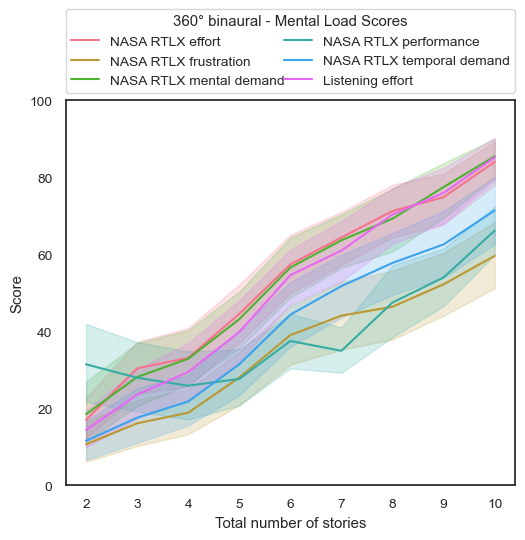

In [199]:
plt.figure(figsize=(5.8, 5))
ax = sns.lineplot(x='total_stories_count', y='rating', hue='rating_type', data=nasatlx_df_reduced_merged.loc[nasatlx_df_reduced_merged['test_id'] == 2], palette="husl")
ax.set_xlabel("Total number of stories")
ax.set_ylabel("Score")
ax.set_ylim(0, 100)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, title='360° binaural - Mental Load Scores', labels=['NASA RTLX effort', 'NASA RTLX frustration', 'NASA RTLX mental demand', 'NASA RTLX performance', 'NASA RTLX temporal demand', 'Listening effort'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
d(ax)
save_fig(ax, "", "plots/lineplot_nasatlx_test_2.pdf")
save_fig(ax, "", "plots/lineplot_nasatlx_test_2.png")

<Axes: xlabel='Total number of stories', ylabel='Score'>

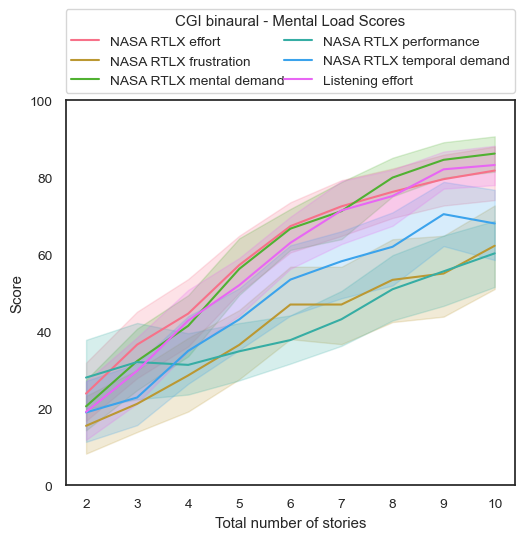

In [200]:
plt.figure(figsize=(5.8, 5))
ax = sns.lineplot(x='total_stories_count', y='rating', hue='rating_type', data=nasatlx_df_reduced_merged.loc[nasatlx_df_reduced_merged['test_id'] == 3], palette="husl")
ax.set_xlabel("Total number of stories")
ax.set_ylabel("Score")
ax.set_ylim(0, 100)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, title='CGI binaural - Mental Load Scores', labels=['NASA RTLX effort', 'NASA RTLX frustration', 'NASA RTLX mental demand', 'NASA RTLX performance', 'NASA RTLX temporal demand', 'Listening effort'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
d(ax)
save_fig(ax, "", "plots/lineplot_nasatlx_test_3.pdf")
save_fig(ax, "", "plots/lineplot_nasatlx_test_3.png")

In [201]:
pairwise_results = pg.pairwise_tests(
    data=nasatlx_df,
    dv='rating',
    within='rating_type',
    subject='subject_number',
    padjust='bonf'
)
d(pairwise_results)
pairwise_results.to_csv("data_eval/pairwisetests_nasatlx_listeningeffort.csv")

nasatlx_df_merged = nasatlx_df.merge(
    speaker_story_mapping_df[['test_id', 'scene', 'subject_number', 'total_stories_count']],
    on=['test_id', 'scene', 'subject_number'],
    how='left'
)

nasatlx_df_merged_aov_mod = nasatlx_df_merged.pivot_table(
    index=['subject_number', 'test_id', 'total_stories_count'],
    columns='rating_type',
    values='rating'
).reset_index()
nasatlx_df_merged_aov_mod['subject_number'] = (nasatlx_df_merged_aov_mod.index // 9) + 1
d(nasatlx_df_merged_aov_mod)

shapiro = pg.normality(nasatlx_df_merged_aov_mod, dv="nasatlx_mental_workload_score", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(nasatlx_df_merged_aov_mod, dv="nasatlx_mental_workload_score", group="test_id", method='levene', alpha=0.05)
d(levene)

aov = pg.mixed_anova(data=nasatlx_df_merged_aov_mod, dv="nasatlx_mental_workload_score", within="total_stories_count", subject="subject_number", between="test_id", correction='auto', effsize='np2')
d(aov)
aov.to_csv("data_eval/anova_nasatlx_mental_workload_per_test.csv")

post_hoc = pg.pairwise_tests(
    data=nasatlx_df_merged_aov_mod,
    dv="nasatlx_mental_workload_score",
    within="total_stories_count",
    between="test_id",
    subject="subject_number",
    padjust="bonf"
)
d(post_hoc)
post_hoc.to_csv("data_eval/post-hoc_nasatlx_mental_workload_per_test.csv")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,rating_type,listening_effort,nasatlx_effort,True,True,-1.477875,35.0,two-sided,1.483845e-01,1.000000e+00,bonf,0.484,-0.112913
1,rating_type,listening_effort,nasatlx_frustration,True,True,10.791216,35.0,two-sided,1.113955e-12,2.339305e-11,bonf,7.392e+09,1.219917
2,rating_type,listening_effort,nasatlx_mental_demand,True,True,-1.357761,35.0,two-sided,1.832294e-01,1.000000e+00,bonf,0.416,-0.136026
3,rating_type,listening_effort,nasatlx_mental_workload_score,True,True,7.643320,35.0,two-sided,5.760051e-09,1.209611e-07,bonf,2.176e+06,0.683446
4,rating_type,listening_effort,nasatlx_performance,True,True,6.003502,35.0,two-sided,7.639458e-07,1.604286e-05,bonf,2.22e+04,1.186657
5,rating_type,listening_effort,nasatlx_temporal_demand,True,True,6.416730,35.0,two-sided,2.189968e-07,4.598932e-06,bonf,7.124e+04,0.817617
6,rating_type,nasatlx_effort,nasatlx_frustration,True,True,11.563070,35.0,two-sided,1.662423e-13,3.491088e-12,bonf,4.565e+10,1.280623
7,rating_type,nasatlx_effort,nasatlx_mental_demand,True,True,-0.101011,35.0,two-sided,9.201179e-01,1.000000e+00,bonf,0.18,-0.008843
8,rating_type,nasatlx_effort,nasatlx_mental_workload_score,True,True,10.144217,35.0,two-sided,5.821032e-12,1.222417e-10,bonf,1.523e+09,0.771757
9,rating_type,nasatlx_effort,nasatlx_performance,True,True,6.280132,35.0,two-sided,3.306955e-07,6.944606e-06,bonf,4.847e+04,1.251470


rating_type,subject_number,test_id,total_stories_count,listening_effort,nasatlx_effort,nasatlx_frustration,nasatlx_mental_demand,nasatlx_mental_workload_score,nasatlx_performance,nasatlx_temporal_demand
0,1,1,2,20.0,20.0,40.0,30.0,40.0,80.0,30.0
1,1,1,3,50.0,40.0,50.0,40.0,44.0,65.0,25.0
2,1,1,4,100.0,98.0,100.0,99.0,98.2,99.0,95.0
3,1,1,5,99.0,90.0,99.0,80.0,88.8,95.0,80.0
4,1,1,6,100.0,100.0,99.0,100.0,99.8,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...
850,95,2,6,64.0,60.0,41.0,30.0,36.0,12.0,37.0
851,95,2,7,69.0,70.0,55.0,64.0,53.8,39.0,41.0
852,95,2,8,65.0,73.0,44.0,46.0,48.8,42.0,39.0
853,95,2,9,73.0,74.0,57.0,76.0,64.2,56.0,58.0


,W,pval,normal
test_id,,,
1,0.959744,0.000006,False
2,0.972562,0.000008,False
3,0.981364,0.000517,False


,W,pval,equal_var
levene,0.30654,0.73607,True


C:\Users\sfremerey\AppData\Roaming\Python\Python311\site-packages\pingouin\parametric.py:1572: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,test_id,33813.297508,2,92,16906.648754,11.058221,4.968459e-05,NaN,0.193806,NaN,NaN,NaN,NaN
1,total_stories_count,290701.406690,8,736,36337.675836,312.541859,7.992629e-231,2.930370e-112,0.772582,0.501154,False,0.04928,8.146054e-39
2,Interaction,10939.979131,16,736,683.748696,5.880951,3.253256e-12,NaN,0.113355,NaN,NaN,NaN,NaN


,Contrast,total_stories_count,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,total_stories_count,-,2.0,3.0,True,True,-8.519302,94.000000,two-sided,2.569605e-13,9.250578e-12,bonf,2.949e+10,-0.555199
1,total_stories_count,-,2.0,4.0,True,True,-10.520486,94.000000,two-sided,1.446652e-17,5.207946e-16,bonf,3.98e+14,-0.945350
2,total_stories_count,-,2.0,5.0,True,True,-13.741562,94.000000,two-sided,3.273384e-24,1.178418e-22,bonf,1.25e+21,-1.478360
3,total_stories_count,-,2.0,6.0,True,True,-17.549160,94.000000,two-sided,2.043848e-31,7.357851e-30,bonf,1.483e+28,-2.083585
4,total_stories_count,-,2.0,7.0,True,True,-19.105605,94.000000,two-sided,3.922466e-34,1.412088e-32,bonf,6.987e+30,-2.323706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,total_stories_count * test_id,9,1,3,False,True,2.705649,56.455329,two-sided,8.997852e-03,2.429420e-01,bonf,5.156,0.680702
62,total_stories_count * test_id,9,2,3,False,True,-1.187270,67.851200,two-sided,2.392610e-01,1.000000e+00,bonf,0.449,-0.280694
63,total_stories_count * test_id,10,1,2,False,True,2.022283,54.227540,two-sided,4.809129e-02,1.000000e+00,bonf,1.428,0.512499
64,total_stories_count * test_id,10,1,3,False,True,2.144925,56.916475,two-sided,3.624020e-02,9.784853e-01,bonf,1.76,0.529120


In [202]:
pandas2ri.activate()
r_df = pandas2ri.py2rpy(nasatlx_df_merged_aov_mod)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
# Change the following to mixed somehow
ro.r('''
df$test_id <- factor(df$test_id)
df$total_stories_count <- factor(df$total_stories_count)
library(ARTool)
m <- art(nasatlx_mental_workload_score ~ test_id * total_stories_count  + (1|subject_number), data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
pandas2ri.rpy2py(anova_res).to_csv("data_eval/art_anova_nasatlx_mental_workload_per_test.csv")
post_hoc_res = ro.r('''
res <- art.con(m, "test_id", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
d(pandas2ri.rpy2py(post_hoc_res))

post_hoc_res = ro.r('''
res <- art.con(m, "test_id:total_stories_count", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
post_hoc_res_df = pandas2ri.rpy2py(post_hoc_res)
desired_contrasts = ['1,2 - 2,2',
'1,2 - 3,2',
'2,2 - 3,2',
 '1,3 - 2,3',
 '1,3 - 3,3',
 '2,3 - 3,3',
 '1,4 - 2,4',
 '1,4 - 3,4',
'2,4 - 3,4',
 '1,5 - 2,5',
 '1,5 - 3,5',
'2,5 - 3,5',
 '1,6 - 2,6',
 '1,6 - 3,6',
'2,6 - 3,6',
 '1,7 - 2,7',
 '1,7 - 3,7',
'2,7 - 3,7',
 '1,8 - 2,8',
 '1,8 - 3,8',
'2,8 - 3,8',
 '1,9 - 2,9',
 '1,9 - 3,9',
'2,9 - 3,9',
 '1,10 - 2,10',
 '1,10 - 3,10',
'2,10 - 3,10'
]
post_hoc_res_df_filtered = post_hoc_res_df[post_hoc_res_df['contrast'].isin(desired_contrasts)].copy()
pvals = post_hoc_res_df_filtered['p.value'].values
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')
post_hoc_res_df_filtered['p.value_corr'] = pvals_corrected

# sort "contrast" 
post_hoc_res_df_filtered['contrast'] = pd.Categorical(
    post_hoc_res_df_filtered['contrast'],
    categories=desired_contrasts,
    ordered=True
)
post_hoc_res_df_filtered.sort_values('contrast', inplace=True)

d(post_hoc_res_df_filtered)
post_hoc_res_df_filtered.to_csv("data_eval/art_post-hoc_nasatlx_mental_workload_per_test.csv")

,Term,F,Df,Df.res,Pr(>F)
test_id,test_id,12.015513,2.0,92.0,2.311160e-05
total_stories_count,total_stories_count,293.695783,8.0,736.0,3.223415e-223
test_id:total_stories_count,test_id:total_stories_count,5.157091,16.0,736.0,2.578822e-10


R[write to console]: NOTE: Results may be misleading due to involvement in interactions



,contrast,estimate,SE,df,t.ratio,p.value
1,test_id1 - test_id2,228.368025,46.763030,92.0,4.883516,0.000004
2,test_id1 - test_id3,151.188105,47.323355,92.0,3.194788,0.001917
3,test_id2 - test_id3,-77.179920,42.955353,92.0,-1.796747,0.075657


,contrast,estimate,SE,df,t.ratio,p.value,p.value_corr
35,"1,2 - 2,2",3.005000,41.251254,232.71114,0.072846,9.419910e-01,1.000000e+00
44,"1,2 - 3,2",-29.090588,41.745535,232.71114,-0.696855,4.865890e-01,1.000000e+00
224,"2,2 - 3,2",-32.095588,37.892373,232.71114,-0.847020,3.978543e-01,1.000000e+00
60,"1,3 - 2,3",50.410000,41.251254,232.71114,1.222023,2.229351e-01,1.000000e+00
69,"1,3 - 3,3",7.821765,41.745535,232.71114,0.187368,8.515356e-01,1.000000e+00
240,"2,3 - 3,3",-42.588235,37.892373,232.71114,-1.123926,2.622023e-01,1.000000e+00
84,"1,4 - 2,4",196.665000,41.251254,232.71114,4.767491,3.288893e-06,8.880012e-05
93,"1,4 - 3,4",108.363529,41.745535,232.71114,2.595811,1.003709e-02,2.710014e-01
255,"2,4 - 3,4",-88.301471,37.892373,232.71114,-2.330323,2.064499e-02,5.574147e-01
107,"1,5 - 2,5",272.875556,41.251254,232.71114,6.614964,2.524863e-10,6.817131e-09


In [203]:
shapiro = pg.normality(nasatlx_df_merged_aov_mod, dv="nasatlx_effort", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(nasatlx_df_merged_aov_mod, dv="nasatlx_effort", group="test_id", method='levene', alpha=0.05)
d(levene)

aov = pg.mixed_anova(data=nasatlx_df_merged_aov_mod, dv="nasatlx_effort", within="total_stories_count", subject="subject_number", between="test_id", correction='auto', effsize='np2')
d(aov)
aov.to_csv("data_eval/anova_nasatlx_effort_per_test.csv")

post_hoc = pg.pairwise_tests(
    data=nasatlx_df_merged_aov_mod,
    dv="nasatlx_effort",
    within="total_stories_count",
    between="test_id",
    subject="subject_number",
    padjust="bonf"
)
d(post_hoc)
post_hoc.to_csv("data_eval/post-hoc_nasatlx_effort_per_test.csv")

,W,pval,normal
test_id,,,
1,0.913810,3.893410e-10,False
2,0.939204,2.907595e-10,False
3,0.935080,2.592608e-10,False


,W,pval,equal_var
levene,10.154567,0.000044,False


C:\Users\sfremerey\AppData\Roaming\Python\Python311\site-packages\pingouin\parametric.py:1572: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,test_id,30486.523716,2,92,15243.261858,6.828435,1.717686e-03,NaN,0.129257,NaN,NaN,NaN,NaN
1,total_stories_count,357611.452632,8,736,44701.431579,243.736855,4.138399e-201,2.236085e-103,0.725976,0.522582,False,0.063833,2.391849e-34
2,Interaction,12688.313106,16,736,793.019569,4.323980,3.681136e-08,NaN,0.085923,NaN,NaN,NaN,NaN


,Contrast,total_stories_count,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,total_stories_count,-,2.0,3.0,True,True,-9.817065,94.000000,two-sided,4.498880e-16,1.619597e-14,bonf,1.4e+13,-0.744891
1,total_stories_count,-,2.0,4.0,True,True,-11.691841,94.000000,two-sided,4.996321e-20,1.798675e-18,bonf,1.005e+17,-1.056051
2,total_stories_count,-,2.0,5.0,True,True,-16.109803,94.000000,two-sided,8.728461e-29,3.142246e-27,bonf,3.851e+25,-1.676310
3,total_stories_count,-,2.0,6.0,True,True,-18.732210,94.000000,two-sided,1.711716e-33,6.162179e-32,bonf,1.639e+30,-2.193040
4,total_stories_count,-,2.0,7.0,True,True,-21.633252,94.000000,two-sided,2.834990e-38,1.020597e-36,bonf,8.366e+34,-2.496610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,total_stories_count * test_id,9,1,3,False,True,1.191013,55.373873,two-sided,2.387290e-01,1.000000e+00,bonf,0.482,0.288432
62,total_stories_count * test_id,9,2,3,False,True,-0.964546,67.908906,two-sided,3.381944e-01,1.000000e+00,bonf,0.366,-0.227970
63,total_stories_count * test_id,10,1,2,False,True,0.415737,58.984412,two-sided,6.791108e-01,1.000000e+00,bonf,0.284,0.100385
64,total_stories_count * test_id,10,1,3,False,True,0.935530,56.141172,two-sided,3.535223e-01,1.000000e+00,bonf,0.385,0.228047


In [204]:
pandas2ri.activate()
r_df = pandas2ri.py2rpy(nasatlx_df_merged_aov_mod)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
# Change the following to mixed somehow
ro.r('''
df$test_id <- factor(df$test_id)
df$total_stories_count <- factor(df$total_stories_count)
library(ARTool)
m <- art(nasatlx_effort ~ test_id * total_stories_count  + (1|subject_number), data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
pandas2ri.rpy2py(anova_res).to_csv("data_eval/art_anova_nasatlx_effort_per_test.csv")
post_hoc_res = ro.r('''
res <- art.con(m, "test_id", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
d(pandas2ri.rpy2py(post_hoc_res))

post_hoc_res = ro.r('''
res <- art.con(m, "test_id:total_stories_count", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
post_hoc_res_df = pandas2ri.rpy2py(post_hoc_res)
desired_contrasts = ['1,2 - 2,2',
'1,2 - 3,2',
'2,2 - 3,2',
 '1,3 - 2,3',
 '1,3 - 3,3',
 '2,3 - 3,3',
 '1,4 - 2,4',
 '1,4 - 3,4',
'2,4 - 3,4',
 '1,5 - 2,5',
 '1,5 - 3,5',
'2,5 - 3,5',
 '1,6 - 2,6',
 '1,6 - 3,6',
'2,6 - 3,6',
 '1,7 - 2,7',
 '1,7 - 3,7',
'2,7 - 3,7',
 '1,8 - 2,8',
 '1,8 - 3,8',
'2,8 - 3,8',
 '1,9 - 2,9',
 '1,9 - 3,9',
'2,9 - 3,9',
 '1,10 - 2,10',
 '1,10 - 3,10',
'2,10 - 3,10'
]
post_hoc_res_df_filtered = post_hoc_res_df[post_hoc_res_df['contrast'].isin(desired_contrasts)].copy()
pvals = post_hoc_res_df_filtered['p.value'].values
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')
post_hoc_res_df_filtered['p.value_corr'] = pvals_corrected

# sort "contrast" 
post_hoc_res_df_filtered['contrast'] = pd.Categorical(
    post_hoc_res_df_filtered['contrast'],
    categories=desired_contrasts,
    ordered=True
)
post_hoc_res_df_filtered.sort_values('contrast', inplace=True)

d(post_hoc_res_df_filtered)
post_hoc_res_df_filtered.to_csv("data_eval/art_post-hoc_nasatlx_effort_per_test.csv")

,Term,F,Df,Df.res,Pr(>F)
test_id,test_id,7.772699,2.0,92.0,7.603542e-04
total_stories_count,total_stories_count,219.974252,8.0,736.0,2.046007e-189
test_id:total_stories_count,test_id:total_stories_count,5.040178,16.0,736.0,5.203001e-10


R[write to console]: NOTE: Results may be misleading due to involvement in interactions



,contrast,estimate,SE,df,t.ratio,p.value
1,test_id1 - test_id2,185.092963,47.087310,92.0,3.930846,0.000164
2,test_id1 - test_id3,97.376732,47.651520,92.0,2.043518,0.043861
3,test_id2 - test_id3,-87.716231,43.253228,92.0,-2.027970,0.045455


,contrast,estimate,SE,df,t.ratio,p.value,p.value_corr
35,"1,2 - 2,2",20.013889,45.369572,236.755228,0.441130,6.595213e-01,1.000000
44,"1,2 - 3,2",-29.176471,45.913200,236.755228,-0.635470,5.257355e-01,1.000000
224,"2,2 - 3,2",-49.190359,41.675357,236.755228,-1.180322,2.390565e-01,1.000000
60,"1,3 - 2,3",69.515000,45.369572,236.755228,1.532194,1.268096e-01,1.000000
69,"1,3 - 3,3",25.448824,45.913200,236.755228,0.554281,5.799096e-01,1.000000
240,"2,3 - 3,3",-44.066176,41.675357,236.755228,-1.057368,2.914215e-01,1.000000
84,"1,4 - 2,4",215.029444,45.369572,236.755228,4.739508,3.698035e-06,0.000100
93,"1,4 - 3,4",131.430588,45.913200,236.755228,2.862588,4.578473e-03,0.123619
255,"2,4 - 3,4",-83.598856,41.675357,236.755228,-2.005954,4.599891e-02,1.000000
107,"1,5 - 2,5",245.065000,45.369572,236.755228,5.401528,1.606674e-07,0.000004


In [205]:
shapiro = pg.normality(nasatlx_df_merged_aov_mod, dv="nasatlx_frustration", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(nasatlx_df_merged_aov_mod, dv="nasatlx_frustration", group="test_id", method='levene', alpha=0.05)
d(levene)

aov = pg.mixed_anova(data=nasatlx_df_merged_aov_mod, dv="nasatlx_frustration", within="total_stories_count", subject="subject_number", between="test_id", correction='auto', effsize='np2')
d(aov)
aov.to_csv("data_eval/anova_nasatlx_frustration_per_test.csv")

post_hoc = pg.pairwise_tests(
    data=nasatlx_df_merged_aov_mod,
    dv="nasatlx_frustration",
    within="total_stories_count",
    between="test_id",
    subject="subject_number",
    padjust="bonf"
)
d(post_hoc)
post_hoc.to_csv("data_eval/post-hoc_nasatlx_frustration_per_test.csv")

,W,pval,normal
test_id,,,
1,0.941306,7.204255e-08,False
2,0.929031,2.692481e-11,False
3,0.917647,6.338060e-12,False


,W,pval,equal_var
levene,4.16774,0.015804,False


C:\Users\sfremerey\AppData\Roaming\Python\Python311\site-packages\pingouin\parametric.py:1572: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,test_id,35917.872378,2,92,17958.936189,4.318753,1.611708e-02,NaN,0.085828,NaN,NaN,NaN,NaN
1,total_stories_count,245061.293567,8,736,30632.661696,139.830928,3.638533e-142,5.334899e-77,0.603159,0.540527,False,0.089942,1.594298e-28
2,Interaction,9184.155830,16,736,574.009739,2.620220,5.261890e-04,NaN,0.053892,NaN,NaN,NaN,NaN


,Contrast,total_stories_count,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,total_stories_count,-,2.0,3.0,True,True,-6.473836,94.000000,two-sided,4.306968e-09,1.550508e-07,bonf,2.504e+06,-0.392195
1,total_stories_count,-,2.0,4.0,True,True,-8.170061,94.000000,two-sided,1.402297e-12,5.048270e-11,bonf,5.707e+09,-0.680793
2,total_stories_count,-,2.0,5.0,True,True,-11.055540,94.000000,two-sided,1.074275e-18,3.867391e-17,bonf,5.026e+15,-1.094155
3,total_stories_count,-,2.0,6.0,True,True,-13.646548,94.000000,two-sided,5.065784e-24,1.823682e-22,bonf,8.148e+20,-1.445143
4,total_stories_count,-,2.0,7.0,True,True,-14.150875,94.000000,two-sided,5.049164e-25,1.817699e-23,bonf,7.812e+21,-1.546553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,total_stories_count * test_id,9,1,3,False,True,2.304358,55.775015,two-sided,2.495001e-02,6.736502e-01,bonf,2.337,0.584048
62,total_stories_count * test_id,9,2,3,False,True,-0.414586,64.693861,two-sided,6.798167e-01,1.000000e+00,bonf,0.265,-0.098529
63,total_stories_count * test_id,10,1,2,False,True,1.904386,53.767107,two-sided,6.221602e-02,1.000000e+00,bonf,1.184,0.483964
64,total_stories_count * test_id,10,1,3,False,True,1.396378,56.444420,two-sided,1.680681e-01,1.000000e+00,bonf,0.6,0.351359


In [206]:
pandas2ri.activate()
r_df = pandas2ri.py2rpy(nasatlx_df_merged_aov_mod)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
# Change the following to mixed somehow
ro.r('''
df$test_id <- factor(df$test_id)
df$total_stories_count <- factor(df$total_stories_count)
library(ARTool)
m <- art(nasatlx_frustration ~ test_id * total_stories_count  + (1|subject_number), data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
pandas2ri.rpy2py(anova_res).to_csv("data_eval/art_anova_nasatlx_frustration_per_test.csv")
post_hoc_res = ro.r('''
res <- art.con(m, "test_id", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
d(pandas2ri.rpy2py(post_hoc_res))

post_hoc_res = ro.r('''
res <- art.con(m, "test_id:total_stories_count", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
post_hoc_res_df = pandas2ri.rpy2py(post_hoc_res)
desired_contrasts = ['1,2 - 2,2',
'1,2 - 3,2',
'2,2 - 3,2',
 '1,3 - 2,3',
 '1,3 - 3,3',
 '2,3 - 3,3',
 '1,4 - 2,4',
 '1,4 - 3,4',
'2,4 - 3,4',
 '1,5 - 2,5',
 '1,5 - 3,5',
'2,5 - 3,5',
 '1,6 - 2,6',
 '1,6 - 3,6',
'2,6 - 3,6',
 '1,7 - 2,7',
 '1,7 - 3,7',
'2,7 - 3,7',
 '1,8 - 2,8',
 '1,8 - 3,8',
'2,8 - 3,8',
 '1,9 - 2,9',
 '1,9 - 3,9',
'2,9 - 3,9',
 '1,10 - 2,10',
 '1,10 - 3,10',
'2,10 - 3,10'
]
post_hoc_res_df_filtered = post_hoc_res_df[post_hoc_res_df['contrast'].isin(desired_contrasts)].copy()
pvals = post_hoc_res_df_filtered['p.value'].values
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')
post_hoc_res_df_filtered['p.value_corr'] = pvals_corrected

# sort "contrast" 
post_hoc_res_df_filtered['contrast'] = pd.Categorical(
    post_hoc_res_df_filtered['contrast'],
    categories=desired_contrasts,
    ordered=True
)
post_hoc_res_df_filtered.sort_values('contrast', inplace=True)

d(post_hoc_res_df_filtered)
post_hoc_res_df_filtered.to_csv("data_eval/art_post-hoc_nasatlx_frustration_per_test.csv")

,Term,F,Df,Df.res,Pr(>F)
test_id,test_id,5.185102,2.0,92.0,7.349470e-03
total_stories_count,total_stories_count,146.260405,8.0,736.0,1.628279e-146
test_id:total_stories_count,test_id:total_stories_count,3.056516,16.0,736.0,5.115080e-05


R[write to console]: NOTE: Results may be misleading due to involvement in interactions



,contrast,estimate,SE,df,t.ratio,p.value
1,test_id1 - test_id2,165.475185,52.161452,92.0,3.172365,0.002056
2,test_id1 - test_id3,121.389673,52.786461,92.0,2.299636,0.023731
3,test_id2 - test_id3,-44.085512,47.914208,92.0,-0.920093,0.359931


,contrast,estimate,SE,df,t.ratio,p.value,p.value_corr
35,"1,2 - 2,2",10.773889,52.314516,177.454395,0.205945,0.837070,1.000000
44,"1,2 - 3,2",-25.754706,52.941359,177.454395,-0.486476,0.627230,1.000000
224,"2,2 - 3,2",-36.528595,48.054809,177.454395,-0.760144,0.448177,1.000000
60,"1,3 - 2,3",91.909444,52.314516,177.454395,1.756863,0.080666,1.000000
69,"1,3 - 3,3",49.281176,52.941359,177.454395,0.930863,0.353189,1.000000
240,"2,3 - 3,3",-42.628268,48.054809,177.454395,-0.887076,0.376239,1.000000
84,"1,4 - 2,4",167.278889,52.314516,177.454395,3.197562,0.001641,0.044315
93,"1,4 - 3,4",92.669412,52.941359,177.454395,1.750416,0.081775,1.000000
255,"2,4 - 3,4",-74.609477,48.054809,177.454395,-1.552591,0.122302,1.000000
107,"1,5 - 2,5",206.424444,52.314516,177.454395,3.945835,0.000114,0.003090


In [207]:
shapiro = pg.normality(nasatlx_df_merged_aov_mod, dv="nasatlx_mental_demand", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(nasatlx_df_merged_aov_mod, dv="nasatlx_mental_demand", group="test_id", method='levene', alpha=0.05)
d(levene)

aov = pg.mixed_anova(data=nasatlx_df_merged_aov_mod, dv="nasatlx_mental_demand", within="total_stories_count", subject="subject_number", between="test_id", correction='auto', effsize='np2')
d(aov)
aov.to_csv("data_eval/anova_nasatlx_mental_demand_per_test.csv")

post_hoc = pg.pairwise_tests(
    data=nasatlx_df_merged_aov_mod,
    dv="nasatlx_mental_demand",
    within="total_stories_count",
    between="test_id",
    subject="subject_number",
    padjust="bonf"
)
d(post_hoc)
post_hoc.to_csv("data_eval/post-hoc_nasatlx_mental_demand_per_test.csv")

,W,pval,normal
test_id,,,
1,0.896406,2.434065e-11,False
2,0.929728,3.145638e-11,False
3,0.938573,5.881151e-10,False


,W,pval,equal_var
levene,6.225484,0.00207,False


C:\Users\sfremerey\AppData\Roaming\Python\Python311\site-packages\pingouin\parametric.py:1572: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,test_id,30881.656302,2,92,15440.828151,8.361585,4.607053e-04,NaN,0.153814,NaN,NaN,NaN,NaN
1,total_stories_count,433624.984795,8,736,54203.123099,262.541615,8.563779e-210,1.363099e-113,0.740510,0.548125,False,0.083638,9.524387e-30
2,Interaction,12855.427231,16,736,803.464202,3.891709,4.592633e-07,NaN,0.078003,NaN,NaN,NaN,NaN


,Contrast,total_stories_count,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,total_stories_count,-,2.0,3.0,True,True,-8.390855,94.000000,two-sided,4.801208e-13,1.728435e-11,bonf,1.61e+10,-0.592186
1,total_stories_count,-,2.0,4.0,True,True,-10.500274,94.000000,two-sided,1.596420e-17,5.747110e-16,bonf,3.615e+14,-1.013762
2,total_stories_count,-,2.0,5.0,True,True,-15.279390,94.000000,two-sided,3.239491e-27,1.166217e-25,bonf,1.107e+24,-1.634451
3,total_stories_count,-,2.0,6.0,True,True,-17.723080,94.000000,two-sided,1.000753e-31,3.602711e-30,bonf,2.994e+28,-2.180448
4,total_stories_count,-,2.0,7.0,True,True,-19.619186,94.000000,two-sided,5.315453e-35,1.913563e-33,bonf,4.998e+31,-2.493898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,total_stories_count * test_id,9,1,3,False,True,1.366918,56.915763,two-sided,1.770261e-01,1.000000e+00,bonf,0.58,0.340916
62,total_stories_count * test_id,9,2,3,False,True,-1.592972,62.828226,two-sided,1.161855e-01,1.000000e+00,bonf,0.723,-0.373019
63,total_stories_count * test_id,10,1,2,False,True,0.843477,55.768707,two-sided,4.025654e-01,1.000000e+00,bonf,0.356,0.211626
64,total_stories_count * test_id,10,1,3,False,True,0.669850,53.024667,two-sided,5.058598e-01,1.000000e+00,bonf,0.322,0.173049


In [208]:
pandas2ri.activate()
r_df = pandas2ri.py2rpy(nasatlx_df_merged_aov_mod)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
# Change the following to mixed somehow
ro.r('''
df$test_id <- factor(df$test_id)
df$total_stories_count <- factor(df$total_stories_count)
library(ARTool)
m <- art(nasatlx_mental_demand ~ test_id * total_stories_count  + (1|subject_number), data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
pandas2ri.rpy2py(anova_res).to_csv("data_eval/art_anova_nasatlx_mental_demand_per_test.csv")
post_hoc_res = ro.r('''
res <- art.con(m, "test_id", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
d(pandas2ri.rpy2py(post_hoc_res))

post_hoc_res = ro.r('''
res <- art.con(m, "test_id:total_stories_count", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
post_hoc_res_df = pandas2ri.rpy2py(post_hoc_res)
desired_contrasts = ['1,2 - 2,2',
'1,2 - 3,2',
'2,2 - 3,2',
 '1,3 - 2,3',
 '1,3 - 3,3',
 '2,3 - 3,3',
 '1,4 - 2,4',
 '1,4 - 3,4',
'2,4 - 3,4',
 '1,5 - 2,5',
 '1,5 - 3,5',
'2,5 - 3,5',
 '1,6 - 2,6',
 '1,6 - 3,6',
'2,6 - 3,6',
 '1,7 - 2,7',
 '1,7 - 3,7',
'2,7 - 3,7',
 '1,8 - 2,8',
 '1,8 - 3,8',
'2,8 - 3,8',
 '1,9 - 2,9',
 '1,9 - 3,9',
'2,9 - 3,9',
 '1,10 - 2,10',
 '1,10 - 3,10',
'2,10 - 3,10'
]
post_hoc_res_df_filtered = post_hoc_res_df[post_hoc_res_df['contrast'].isin(desired_contrasts)].copy()
pvals = post_hoc_res_df_filtered['p.value'].values
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')
post_hoc_res_df_filtered['p.value_corr'] = pvals_corrected

# sort "contrast" 
post_hoc_res_df_filtered['contrast'] = pd.Categorical(
    post_hoc_res_df_filtered['contrast'],
    categories=desired_contrasts,
    ordered=True
)
post_hoc_res_df_filtered.sort_values('contrast', inplace=True)

d(post_hoc_res_df_filtered)
post_hoc_res_df_filtered.to_csv("data_eval/art_post-hoc_nasatlx_mental_demand_per_test.csv")

,Term,F,Df,Df.res,Pr(>F)
test_id,test_id,9.956306,2.0,92.0,1.218441e-04
total_stories_count,total_stories_count,235.127920,8.0,736.0,5.694188e-197
test_id:total_stories_count,test_id:total_stories_count,4.185837,16.0,736.0,8.284998e-08


R[write to console]: NOTE: Results may be misleading due to involvement in interactions



,contrast,estimate,SE,df,t.ratio,p.value
1,test_id1 - test_id2,200.086420,44.838875,92.0,4.462343,0.000023
2,test_id1 - test_id3,118.470588,45.376144,92.0,2.610856,0.010545
3,test_id2 - test_id3,-81.615832,41.187872,92.0,-1.981550,0.050515


,contrast,estimate,SE,df,t.ratio,p.value,p.value_corr
35,"1,2 - 2,2",-17.106111,42.430823,293.69157,-0.403153,6.871290e-01,1.000000
44,"1,2 - 3,2",-20.987647,42.939238,293.69157,-0.488775,6.253654e-01,1.000000
224,"2,2 - 3,2",-3.881536,38.975895,293.69157,-0.099588,9.207393e-01,1.000000
60,"1,3 - 2,3",33.267778,42.430823,293.69157,0.784047,4.336442e-01,1.000000
69,"1,3 - 3,3",16.225294,42.939238,293.69157,0.377866,7.058028e-01,1.000000
240,"2,3 - 3,3",-17.042484,38.975895,293.69157,-0.437257,6.622463e-01,1.000000
84,"1,4 - 2,4",167.401667,42.430823,293.69157,3.945284,9.976590e-05,0.002694
93,"1,4 - 3,4",110.610000,42.939238,293.69157,2.575966,1.048484e-02,0.283091
255,"2,4 - 3,4",-56.791667,38.975895,293.69157,-1.457097,1.461579e-01,1.000000
107,"1,5 - 2,5",217.567778,42.430823,293.69157,5.127588,5.335436e-07,0.000014


In [209]:
shapiro = pg.normality(nasatlx_df_merged_aov_mod, dv="nasatlx_performance", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(nasatlx_df_merged_aov_mod, dv="nasatlx_performance", group="test_id", method='levene', alpha=0.05)
d(levene)

aov = pg.mixed_anova(data=nasatlx_df_merged_aov_mod, dv="nasatlx_performance", within="total_stories_count", subject="subject_number", between="test_id", correction='auto', effsize='np2')
d(aov)
aov.to_csv("data_eval/anova_nasatlx_performance_per_test.csv")

post_hoc = pg.pairwise_tests(
    data=nasatlx_df_merged_aov_mod,
    dv="nasatlx_performance",
    within="total_stories_count",
    between="test_id",
    subject="subject_number",
    padjust="bonf"
)
d(post_hoc)
post_hoc.to_csv("data_eval/post-hoc_nasatlx_performance_per_test.csv")

,W,pval,normal
test_id,,,
1,0.937949,3.548411e-08,False
2,0.947712,2.607261e-09,False
3,0.952173,1.948534e-08,False


,W,pval,equal_var
levene,7.547683,0.000563,False


C:\Users\sfremerey\AppData\Roaming\Python\Python311\site-packages\pingouin\parametric.py:1572: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,test_id,45773.961831,2,92,22886.980915,11.134014,4.674149e-05,NaN,0.194875,NaN,NaN,NaN,NaN
1,total_stories_count,171093.609357,8,736,21386.701170,52.502388,2.841034e-67,1.954695e-23,0.363332,0.345073,False,0.013714,1.577717e-61
2,Interaction,32746.620563,16,736,2046.663785,5.024372,5.720259e-10,NaN,0.098470,NaN,NaN,NaN,NaN


,Contrast,total_stories_count,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,total_stories_count,-,2.0,3.0,True,True,0.357315,94.000000,two-sided,0.721657,1.000000,bonf,0.121,0.018686
1,total_stories_count,-,2.0,4.0,True,True,-0.018019,94.000000,two-sided,0.985662,1.000000,bonf,0.114,-0.001169
2,total_stories_count,-,2.0,5.0,True,True,-2.495341,94.000000,two-sided,0.014327,0.515783,bonf,2.131,-0.266849
3,total_stories_count,-,2.0,6.0,True,True,-4.267400,94.000000,two-sided,0.000047,0.001698,bonf,376.307,-0.543969
4,total_stories_count,-,2.0,7.0,True,True,-4.913804,94.000000,two-sided,0.000004,0.000136,bonf,4005.008,-0.695826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,total_stories_count * test_id,9,1,3,False,True,4.559910,54.272105,two-sided,0.000030,0.000798,bonf,681.456,1.096433
62,total_stories_count * test_id,9,2,3,False,True,-0.258897,65.342657,two-sided,0.796529,1.000000,bonf,0.253,-0.061485
63,total_stories_count * test_id,10,1,2,False,True,3.067962,52.028735,two-sided,0.003418,0.092276,bonf,11.633,0.787457
64,total_stories_count * test_id,10,1,3,False,True,3.552226,56.988953,two-sided,0.000775,0.020921,bonf,38.335,0.879315


In [210]:
pandas2ri.activate()
r_df = pandas2ri.py2rpy(nasatlx_df_merged_aov_mod)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
# Change the following to mixed somehow
ro.r('''
df$test_id <- factor(df$test_id)
df$total_stories_count <- factor(df$total_stories_count)
library(ARTool)
m <- art(nasatlx_performance ~ test_id * total_stories_count  + (1|subject_number), data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
pandas2ri.rpy2py(anova_res).to_csv("data_eval/art_anova_nasatlx_performance_per_test.csv")
post_hoc_res = ro.r('''
res <- art.con(m, "test_id", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
d(pandas2ri.rpy2py(post_hoc_res))

post_hoc_res = ro.r('''
res <- art.con(m, "test_id:total_stories_count", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
post_hoc_res_df = pandas2ri.rpy2py(post_hoc_res)
desired_contrasts = ['1,2 - 2,2',
'1,2 - 3,2',
'2,2 - 3,2',
 '1,3 - 2,3',
 '1,3 - 3,3',
 '2,3 - 3,3',
 '1,4 - 2,4',
 '1,4 - 3,4',
'2,4 - 3,4',
 '1,5 - 2,5',
 '1,5 - 3,5',
'2,5 - 3,5',
 '1,6 - 2,6',
 '1,6 - 3,6',
'2,6 - 3,6',
 '1,7 - 2,7',
 '1,7 - 3,7',
'2,7 - 3,7',
 '1,8 - 2,8',
 '1,8 - 3,8',
'2,8 - 3,8',
 '1,9 - 2,9',
 '1,9 - 3,9',
'2,9 - 3,9',
 '1,10 - 2,10',
 '1,10 - 3,10',
'2,10 - 3,10'
]
post_hoc_res_df_filtered = post_hoc_res_df[post_hoc_res_df['contrast'].isin(desired_contrasts)].copy()
pvals = post_hoc_res_df_filtered['p.value'].values
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')
post_hoc_res_df_filtered['p.value_corr'] = pvals_corrected

# sort "contrast" 
post_hoc_res_df_filtered['contrast'] = pd.Categorical(
    post_hoc_res_df_filtered['contrast'],
    categories=desired_contrasts,
    ordered=True
)
post_hoc_res_df_filtered.sort_values('contrast', inplace=True)

d(post_hoc_res_df_filtered)
post_hoc_res_df_filtered.to_csv("data_eval/art_post-hoc_nasatlx_performance_per_test.csv")

,Term,F,Df,Df.res,Pr(>F)
test_id,test_id,12.129183,2.0,92.0,2.112157e-05
total_stories_count,total_stories_count,54.222702,8.0,736.0,3.876376e-69
test_id:total_stories_count,test_id:total_stories_count,4.682138,16.0,736.0,4.418126e-09


R[write to console]: NOTE: Results may be misleading due to involvement in interactions



,contrast,estimate,SE,df,t.ratio,p.value
1,test_id1 - test_id2,180.790988,38.707798,92.0,4.670661,0.000010
2,test_id1 - test_id3,156.435686,39.171603,92.0,3.993599,0.000131
3,test_id2 - test_id3,-24.355301,35.556018,92.0,-0.684984,0.495076


,contrast,estimate,SE,df,t.ratio,p.value,p.value_corr
35,"1,2 - 2,2",-24.337778,53.261924,457.69438,-0.456945,6.479273e-01,1.000000e+00
44,"1,2 - 3,2",5.454706,53.900120,457.69438,0.101200,9.194358e-01,1.000000e+00
224,"2,2 - 3,2",29.792484,48.925075,457.69438,0.608941,5.428657e-01,1.000000e+00
60,"1,3 - 2,3",-21.198889,53.261924,457.69438,-0.398012,6.908069e-01,1.000000e+00
69,"1,3 - 3,3",-54.133529,53.900120,457.69438,-1.004330,3.157500e-01,1.000000e+00
240,"2,3 - 3,3",-32.934641,48.925075,457.69438,-0.673165,5.011822e-01,1.000000e+00
84,"1,4 - 2,4",54.889444,53.261924,457.69438,1.030557,3.032929e-01,1.000000e+00
93,"1,4 - 3,4",-0.621176,53.900120,457.69438,-0.011525,9.908099e-01,1.000000e+00
255,"2,4 - 3,4",-55.510621,48.925075,457.69438,-1.134605,2.571348e-01,1.000000e+00
107,"1,5 - 2,5",206.786667,53.261924,457.69438,3.882448,1.186284e-04,3.202966e-03


In [211]:
shapiro = pg.normality(nasatlx_df_merged_aov_mod, dv="nasatlx_temporal_demand", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(nasatlx_df_merged_aov_mod, dv="nasatlx_temporal_demand", group="test_id", method='levene', alpha=0.05)
d(levene)

aov = pg.mixed_anova(data=nasatlx_df_merged_aov_mod, dv="nasatlx_temporal_demand", within="total_stories_count", subject="subject_number", between="test_id", correction='auto', effsize='np2')
d(aov)
aov.to_csv("data_eval/anova_nasatlx_temporal_demand_per_test.csv")

post_hoc = pg.pairwise_tests(
    data=nasatlx_df_merged_aov_mod,
    dv="nasatlx_temporal_demand",
    within="total_stories_count",
    between="test_id",
    subject="subject_number",
    padjust="bonf"
)
d(post_hoc)
post_hoc.to_csv("data_eval/post-hoc_nasatlx_temporal_demand_per_test.csv")

,W,pval,normal
test_id,,,
1,0.930963,8.721693e-09,False
2,0.925040,1.125067e-11,False
3,0.939961,8.209253e-10,False


,W,pval,equal_var
levene,0.123339,0.88398,True


C:\Users\sfremerey\AppData\Roaming\Python\Python311\site-packages\pingouin\parametric.py:1572: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,test_id,31295.485371,2,92,15647.742685,4.683522,1.156080e-02,NaN,0.092407,NaN,NaN,NaN,NaN
1,total_stories_count,311694.547368,8,736,38961.818421,130.468762,1.295894e-135,1.033887e-66,0.586459,0.492554,False,0.048616,4.732019e-39
2,Interaction,14954.601245,16,736,934.662578,3.129840,3.420897e-05,NaN,0.063705,NaN,NaN,NaN,NaN


,Contrast,total_stories_count,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,total_stories_count,-,2.0,3.0,True,True,-4.320372,94.000000,two-sided,3.863666e-05,1.390920e-03,bonf,453.036,-0.306286
1,total_stories_count,-,2.0,4.0,True,True,-8.675312,94.000000,two-sided,1.201057e-13,4.323806e-12,bonf,6.162e+10,-0.778959
2,total_stories_count,-,2.0,5.0,True,True,-10.923697,94.000000,two-sided,2.035731e-18,7.328631e-17,bonf,2.694e+15,-1.155116
3,total_stories_count,-,2.0,6.0,True,True,-14.590237,94.000000,two-sided,6.941944e-26,2.499100e-24,bonf,5.47e+22,-1.606531
4,total_stories_count,-,2.0,7.0,True,True,-15.455820,94.000000,two-sided,1.492292e-27,5.372251e-26,bonf,2.37e+24,-1.825283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,total_stories_count * test_id,9,1,3,False,True,0.153596,49.567641,two-sided,8.785519e-01,1.000000e+00,bonf,0.269,0.040396
62,total_stories_count * test_id,9,2,3,False,True,-1.230494,67.827946,two-sided,2.227624e-01,1.000000e+00,bonf,0.469,-0.290097
63,total_stories_count * test_id,10,1,2,False,True,0.060309,53.837978,two-sided,9.521325e-01,1.000000e+00,bonf,0.265,0.015320
64,total_stories_count * test_id,10,1,3,False,True,0.534898,55.025779,two-sided,5.948756e-01,1.000000e+00,bonf,0.301,0.136413


In [212]:
pandas2ri.activate()
r_df = pandas2ri.py2rpy(nasatlx_df_merged_aov_mod)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
# Change the following to mixed somehow
ro.r('''
df$test_id <- factor(df$test_id)
df$total_stories_count <- factor(df$total_stories_count)
library(ARTool)
m <- art(nasatlx_temporal_demand ~ test_id * total_stories_count  + (1|subject_number), data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
pandas2ri.rpy2py(anova_res).to_csv("data_eval/art_anova_nasatlx_temporal_demand_per_test.csv")
post_hoc_res = ro.r('''
res <- art.con(m, "test_id", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
d(pandas2ri.rpy2py(post_hoc_res))

post_hoc_res = ro.r('''
res <- art.con(m, "test_id:total_stories_count", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
post_hoc_res_df = pandas2ri.rpy2py(post_hoc_res)
desired_contrasts = ['1,2 - 2,2',
'1,2 - 3,2',
'2,2 - 3,2',
 '1,3 - 2,3',
 '1,3 - 3,3',
 '2,3 - 3,3',
 '1,4 - 2,4',
 '1,4 - 3,4',
'2,4 - 3,4',
 '1,5 - 2,5',
 '1,5 - 3,5',
'2,5 - 3,5',
 '1,6 - 2,6',
 '1,6 - 3,6',
'2,6 - 3,6',
 '1,7 - 2,7',
 '1,7 - 3,7',
'2,7 - 3,7',
 '1,8 - 2,8',
 '1,8 - 3,8',
'2,8 - 3,8',
 '1,9 - 2,9',
 '1,9 - 3,9',
'2,9 - 3,9',
 '1,10 - 2,10',
 '1,10 - 3,10',
'2,10 - 3,10'
]
post_hoc_res_df_filtered = post_hoc_res_df[post_hoc_res_df['contrast'].isin(desired_contrasts)].copy()
pvals = post_hoc_res_df_filtered['p.value'].values
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')
post_hoc_res_df_filtered['p.value_corr'] = pvals_corrected

# sort "contrast" 
post_hoc_res_df_filtered['contrast'] = pd.Categorical(
    post_hoc_res_df_filtered['contrast'],
    categories=desired_contrasts,
    ordered=True
)
post_hoc_res_df_filtered.sort_values('contrast', inplace=True)

d(post_hoc_res_df_filtered)
post_hoc_res_df_filtered.to_csv("data_eval/art_post-hoc_nasatlx_temporal_demand_per_test.csv")

,Term,F,Df,Df.res,Pr(>F)
test_id,test_id,5.989535,2.0,92.0,3.586968e-03
total_stories_count,total_stories_count,129.404833,8.0,736.0,7.487250e-135
test_id:total_stories_count,test_id:total_stories_count,3.823573,16.0,736.0,6.807179e-07


R[write to console]: NOTE: Results may be misleading due to involvement in interactions



,contrast,estimate,SE,df,t.ratio,p.value
1,test_id1 - test_id2,166.097531,47.991513,92.0,3.460977,0.000818
2,test_id1 - test_id3,99.073203,48.566557,92.0,2.039947,0.044223
3,test_id2 - test_id3,-67.024328,44.083806,92.0,-1.520384,0.131844


,contrast,estimate,SE,df,t.ratio,p.value,p.value_corr
35,"1,2 - 2,2",34.172778,50.411487,248.378635,0.677877,0.498481,1.000000
44,"1,2 - 3,2",-24.347647,51.015528,248.378635,-0.477260,0.633597,1.000000
224,"2,2 - 3,2",-58.520425,46.306735,248.378635,-1.263756,0.207502,1.000000
60,"1,3 - 2,3",67.352222,50.411487,248.378635,1.336049,0.182756,1.000000
69,"1,3 - 3,3",22.953529,51.015528,248.378635,0.449932,0.653152,1.000000
240,"2,3 - 3,3",-44.398693,46.306735,248.378635,-0.958796,0.338594,1.000000
84,"1,4 - 2,4",208.565000,50.411487,248.378635,4.137251,0.000048,0.001300
93,"1,4 - 3,4",106.454706,51.015528,248.378635,2.086712,0.037934,1.000000
255,"2,4 - 3,4",-102.110294,46.306735,248.378635,-2.205085,0.028365,0.765853
107,"1,5 - 2,5",226.499444,50.411487,248.378635,4.493013,0.000011,0.000291


In [213]:
shapiro = pg.normality(nasatlx_df_merged_aov_mod, dv="listening_effort", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(nasatlx_df_merged_aov_mod, dv="listening_effort", group="test_id", method='levene', alpha=0.05)
d(levene)

aov = pg.mixed_anova(data=nasatlx_df_merged_aov_mod, dv="listening_effort", within="total_stories_count", subject="subject_number", between="test_id", correction='auto', effsize='np2')
d(aov)
aov.to_csv("data_eval/anova_listening_effort_per_test.csv")

post_hoc = pg.pairwise_tests(
    data=nasatlx_df_merged_aov_mod,
    dv="listening_effort",
    within="total_stories_count",
    between="test_id",
    subject="subject_number",
    padjust="bonf"
)
d(post_hoc)
post_hoc.to_csv("data_eval/post-hoc_listening_effort_per_test.csv")

,W,pval,normal
test_id,,,
1,0.895093,2.000248e-11,False
2,0.930092,3.413654e-11,False
3,0.936665,3.745735e-10,False


,W,pval,equal_var
levene,4.697009,0.00936,False


C:\Users\sfremerey\AppData\Roaming\Python\Python311\site-packages\pingouin\parametric.py:1572: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,test_id,43054.779852,2,92,21527.389926,9.296394,2.102843e-04,NaN,0.168119,NaN,NaN,NaN,NaN
1,total_stories_count,447484.402339,8,736,55935.550292,309.314504,1.512659e-229,5.183038e-131,0.770753,0.584582,False,0.076108,2.405311e-31
2,Interaction,14314.351648,16,736,894.646978,4.947252,9.079435e-10,NaN,0.097105,NaN,NaN,NaN,NaN


,Contrast,total_stories_count,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,total_stories_count,-,2.0,3.0,True,True,-9.719936,94.000000,two-sided,7.238419e-16,2.605831e-14,bonf,8.816e+12,-0.641686
1,total_stories_count,-,2.0,4.0,True,True,-12.004519,94.000000,two-sided,1.119314e-20,4.029529e-19,bonf,4.339e+17,-1.082971
2,total_stories_count,-,2.0,5.0,True,True,-14.819268,94.000000,two-sided,2.490647e-26,8.966331e-25,bonf,1.495e+23,-1.608335
3,total_stories_count,-,2.0,6.0,True,True,-20.654405,94.000000,two-sided,1.041381e-36,3.748971e-35,bonf,2.403e+33,-2.288248
4,total_stories_count,-,2.0,7.0,True,True,-22.624764,94.000000,two-sided,8.219458e-40,2.959005e-38,bonf,2.741e+36,-2.533603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,total_stories_count * test_id,9,1,3,False,True,1.785377,55.059129,two-sided,7.970842e-02,1.000000e+00,bonf,0.995,0.455204
62,total_stories_count * test_id,9,2,3,False,True,-1.314324,61.039216,two-sided,1.936550e-01,1.000000e+00,bonf,0.514,-0.307325
63,total_stories_count * test_id,10,1,2,False,True,1.163592,58.739827,two-sided,2.492942e-01,1.000000e+00,bonf,0.465,0.277217
64,total_stories_count * test_id,10,1,3,False,True,1.788946,56.988446,two-sided,7.893847e-02,1.000000e+00,bonf,1.0,0.442814


In [214]:
pandas2ri.activate()
r_df = pandas2ri.py2rpy(nasatlx_df_merged_aov_mod)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
# Change the following to mixed somehow
ro.r('''
df$test_id <- factor(df$test_id)
df$total_stories_count <- factor(df$total_stories_count)
library(ARTool)
m <- art(listening_effort ~ test_id * total_stories_count  + (1|subject_number), data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
pandas2ri.rpy2py(anova_res).to_csv("data_eval/art_anova_listening_effort_per_test.csv")
post_hoc_res = ro.r('''
res <- art.con(m, "test_id", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
d(pandas2ri.rpy2py(post_hoc_res))

post_hoc_res = ro.r('''
res <- art.con(m, "test_id:total_stories_count", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
post_hoc_res_df = pandas2ri.rpy2py(post_hoc_res)
desired_contrasts = ['1,2 - 2,2',
'1,2 - 3,2',
'2,2 - 3,2',
 '1,3 - 2,3',
 '1,3 - 3,3',
 '2,3 - 3,3',
 '1,4 - 2,4',
 '1,4 - 3,4',
'2,4 - 3,4',
 '1,5 - 2,5',
 '1,5 - 3,5',
'2,5 - 3,5',
 '1,6 - 2,6',
 '1,6 - 3,6',
'2,6 - 3,6',
 '1,7 - 2,7',
 '1,7 - 3,7',
'2,7 - 3,7',
 '1,8 - 2,8',
 '1,8 - 3,8',
'2,8 - 3,8',
 '1,9 - 2,9',
 '1,9 - 3,9',
'2,9 - 3,9',
 '1,10 - 2,10',
 '1,10 - 3,10',
'2,10 - 3,10'
]
post_hoc_res_df_filtered = post_hoc_res_df[post_hoc_res_df['contrast'].isin(desired_contrasts)].copy()
pvals = post_hoc_res_df_filtered['p.value'].values
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')
post_hoc_res_df_filtered['p.value_corr'] = pvals_corrected

# sort "contrast" 
post_hoc_res_df_filtered['contrast'] = pd.Categorical(
    post_hoc_res_df_filtered['contrast'],
    categories=desired_contrasts,
    ordered=True
)
post_hoc_res_df_filtered.sort_values('contrast', inplace=True)

d(post_hoc_res_df_filtered)
post_hoc_res_df_filtered.to_csv("data_eval/art_post-hoc_listening_effort_per_test.csv")

,Term,F,Df,Df.res,Pr(>F)
test_id,test_id,10.954382,2.0,92.0,5.402709e-05
total_stories_count,total_stories_count,281.283047,8.0,736.0,5.281537e-218
test_id:total_stories_count,test_id:total_stories_count,5.451291,16.0,736.0,4.382428e-11


R[write to console]: NOTE: Results may be misleading due to involvement in interactions



,contrast,estimate,SE,df,t.ratio,p.value
1,test_id1 - test_id2,216.669877,46.508699,92.0,4.658696,0.000011
2,test_id1 - test_id3,145.195294,47.065976,92.0,3.084931,0.002689
3,test_id2 - test_id3,-71.474582,42.721731,92.0,-1.673026,0.097719


,contrast,estimate,SE,df,t.ratio,p.value,p.value_corr
35,"1,2 - 2,2",12.209444,42.328574,224.337946,0.288444,7.732728e-01,1.000000e+00
44,"1,2 - 3,2",-22.712941,42.835764,224.337946,-0.530233,5.964747e-01,1.000000e+00
224,"2,2 - 3,2",-34.922386,38.881973,224.337946,-0.898164,3.700611e-01,1.000000e+00
60,"1,3 - 2,3",92.180000,42.328574,224.337946,2.177725,3.046917e-02,8.226675e-01
69,"1,3 - 3,3",46.032941,42.835764,224.337946,1.074638,2.836913e-01,1.000000e+00
240,"2,3 - 3,3",-46.147059,38.881973,224.337946,-1.186850,2.365422e-01,1.000000e+00
84,"1,4 - 2,4",161.758889,42.328574,224.337946,3.821506,1.717930e-04,4.638411e-03
93,"1,4 - 3,4",69.840588,42.835764,224.337946,1.630427,1.044144e-01,1.000000e+00
255,"2,4 - 3,4",-91.918301,38.881973,224.337946,-2.364034,1.893060e-02,5.111262e-01
107,"1,5 - 2,5",262.328889,42.328574,224.337946,6.197442,2.719028e-09,7.341377e-08


# Total degrees explored

In [215]:
d(headrotation_df)
headrotation_df_melted = headrotation_df.melt(id_vars=["subject_number", "test_id", "total_stories_count", "total_time_s"], value_vars=["total_pitch_explored", "total_yaw_explored", "total_degrees_explored"],
                    var_name="exploration_type", value_name="degrees_explored")
d(headrotation_df_melted)

,subject_number,test_id,total_stories_count,total_time_s,total_pitch_explored,total_yaw_explored,total_degrees_explored,delta_minmax_pitch,delta_minmax_yaw,number_yaw_direction_changes,number_yaw_direction_changes_per_s
0,1,1,10,120.0,407.095176,2492.906113,2900.001289,48.162250,360.0000,59,0.491667
1,1,1,2,30.0,290.117333,1529.519737,1819.637070,45.980766,360.0000,26,0.866667
2,1,1,3,43.0,444.227190,1514.937271,1959.164461,58.791070,360.0000,49,1.139535
3,1,1,4,67.0,336.393080,1458.437674,1794.830754,42.789051,360.0000,24,0.358209
4,1,1,5,120.0,670.065976,2464.669624,3134.735600,47.265210,360.0000,75,0.625000
...,...,...,...,...,...,...,...,...,...,...,...
850,95,3,5,120.0,451.618628,2149.432621,2601.051250,34.295810,358.8708,63,0.525000
851,95,3,6,120.0,666.251841,2316.035590,2982.287431,32.611570,359.9743,90,0.750000
852,95,3,7,120.0,363.714789,1562.933264,1926.648053,32.019825,359.6326,50,0.416667
853,95,3,8,120.0,414.388384,1710.020308,2124.408693,34.098290,359.7290,51,0.425000


,subject_number,test_id,total_stories_count,total_time_s,exploration_type,degrees_explored
0,1,1,10,120.0,total_pitch_explored,407.095176
1,1,1,2,30.0,total_pitch_explored,290.117333
2,1,1,3,43.0,total_pitch_explored,444.227190
3,1,1,4,67.0,total_pitch_explored,336.393080
4,1,1,5,120.0,total_pitch_explored,670.065976
...,...,...,...,...,...,...
2560,95,3,5,120.0,total_degrees_explored,2601.051250
2561,95,3,6,120.0,total_degrees_explored,2982.287431
2562,95,3,7,120.0,total_degrees_explored,1926.648053
2563,95,3,8,120.0,total_degrees_explored,2124.408693


<Axes: xlabel='Total number of stories', ylabel='Total yaw degrees explored [°]'>

,test_id,total_stories_count,total_yaw_explored
0,1,2,665.402363
1,1,3,1088.622684
2,1,4,1114.150745
3,1,5,1125.133734
4,1,6,1078.716095
5,1,7,970.329426
6,1,8,937.157269
7,1,9,990.682366
8,1,10,841.558332
9,2,2,567.700718


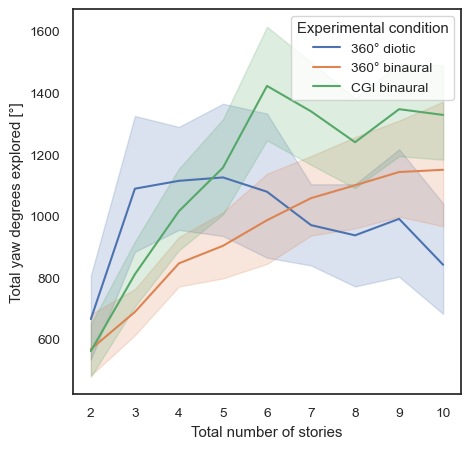

In [216]:
ax = sns.lineplot(x='total_stories_count', y='total_yaw_explored', hue='test_id', data=headrotation_df, palette="deep")
ax.set_xlabel("Total number of stories")
ax.set_ylabel("Total yaw degrees explored [°]")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, title='Experimental condition', labels=['360° diotic', '360° binaural', 'CGI binaural'])
d(ax)
save_fig(ax, "", "plots/lineplot_total_yaw_explored.pdf")
save_fig(ax, "", "plots/lineplot_total_yaw_explored.png")
d(headrotation_df.groupby(["test_id", "total_stories_count"])["total_yaw_explored"].mean().reset_index())

In [217]:
d(headrotation_df_aov_mod)

shapiro = pg.normality(headrotation_df_aov_mod, dv="total_yaw_explored", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(headrotation_df_aov_mod, dv="total_yaw_explored", group="test_id", method='levene', alpha=0.05)
d(levene)

aov = pg.mixed_anova(data=headrotation_df_aov_mod, dv="total_yaw_explored", within="total_stories_count", subject="subject_number", between="test_id", correction='auto', effsize='np2')
d(aov)
aov.to_csv("data_eval/anova_total_yaw_explored_per_test.csv")

post_hoc = pg.pairwise_tests(
    data=headrotation_df_aov_mod,
    dv="total_yaw_explored",
    within="total_stories_count",
    between="test_id",
    subject="subject_number",
    padjust="bonf"
)
d(post_hoc)
post_hoc.to_csv("data_eval/post-hoc_total_yaw_explored_per_test.csv")

,subject_number,test_id,total_stories_count,total_time_s,total_pitch_explored,total_yaw_explored,total_degrees_explored,delta_minmax_pitch,delta_minmax_yaw,number_yaw_direction_changes,number_yaw_direction_changes_per_s
0,1,1,10,120.0,407.095176,2492.906113,2900.001289,48.162250,360.0000,59,0.491667
1,1,1,2,30.0,290.117333,1529.519737,1819.637070,45.980766,360.0000,26,0.866667
2,1,1,3,43.0,444.227190,1514.937271,1959.164461,58.791070,360.0000,49,1.139535
3,1,1,4,67.0,336.393080,1458.437674,1794.830754,42.789051,360.0000,24,0.358209
4,1,1,5,120.0,670.065976,2464.669624,3134.735600,47.265210,360.0000,75,0.625000
...,...,...,...,...,...,...,...,...,...,...,...
850,95,3,5,120.0,451.618628,2149.432621,2601.051250,34.295810,358.8708,63,0.525000
851,95,3,6,120.0,666.251841,2316.035590,2982.287431,32.611570,359.9743,90,0.750000
852,95,3,7,120.0,363.714789,1562.933264,1926.648053,32.019825,359.6326,50,0.416667
853,95,3,8,120.0,414.388384,1710.020308,2124.408693,34.098290,359.7290,51,0.425000


,W,pval,normal
test_id,,,
1,0.889706,9.088888e-12,False
2,0.910712,6.197922e-13,False
3,0.972090,1.168672e-05,False


,W,pval,equal_var
levene,5.373808,0.004795,False


C:\Users\sfremerey\AppData\Roaming\Python\Python311\site-packages\pingouin\parametric.py:1572: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,test_id,6.649091e+06,2,92,3.324545e+06,3.889805,2.389556e-02,NaN,0.077968,NaN,NaN,NaN,NaN
1,total_stories_count,2.843698e+07,8,736,3.554623e+06,30.814276,9.244546e-42,6.826770e-26,0.250901,0.656612,False,0.224249,7.493759e-14
2,Interaction,1.091727e+07,16,736,6.823294e+05,5.914970,2.646596e-12,NaN,0.113936,NaN,NaN,NaN,NaN


,Contrast,total_stories_count,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,total_stories_count,-,2.0,3.0,True,True,-6.230511,94.000000,two-sided,1.302317e-08,4.688341e-07,bonf,8.69e+05,-0.653618
1,total_stories_count,-,2.0,4.0,True,True,-8.872301,94.000000,two-sided,4.589654e-14,1.652275e-12,bonf,1.566e+11,-1.104723
2,total_stories_count,-,2.0,5.0,True,True,-9.481165,94.000000,two-sided,2.330945e-15,8.391402e-14,bonf,2.828e+12,-1.180101
3,total_stories_count,-,2.0,6.0,True,True,-10.250671,94.000000,two-sided,5.396520e-17,1.942747e-15,bonf,1.103e+14,-1.254985
4,total_stories_count,-,2.0,7.0,True,True,-10.051755,94.000000,two-sided,1.426768e-16,5.136366e-15,bonf,4.281e+13,-1.382265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,total_stories_count * test_id,9,1,3,False,True,-2.664997,47.318522,two-sided,1.049758e-02,2.834345e-01,bonf,4.735,-0.708347
62,total_stories_count * test_id,9,2,3,False,True,-1.836233,67.774519,two-sided,7.070940e-02,1.000000e+00,bonf,1.025,-0.434258
63,total_stories_count * test_id,10,1,2,False,True,-2.255004,57.818642,two-sided,2.793512e-02,7.542481e-01,bonf,2.132,-0.556206
64,total_stories_count * test_id,10,1,3,False,True,-3.880906,52.364936,two-sided,2.929922e-04,7.910789e-03,bonf,93.078,-1.006295


In [218]:
pandas2ri.activate()
r_df = pandas2ri.py2rpy(headrotation_df_aov_mod)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
# Change the following to mixed somehow
ro.r('''
df$test_id <- factor(df$test_id)
df$total_stories_count <- factor(df$total_stories_count)
library(ARTool)
m <- art(total_yaw_explored ~ test_id * total_stories_count  + (1|subject_number), data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
pandas2ri.rpy2py(anova_res).to_csv("data_eval/art_anova_total_yaw_explored_per_test.csv")
post_hoc_res = ro.r('''
res <- art.con(m, "test_id", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
d(pandas2ri.rpy2py(post_hoc_res))

post_hoc_res = ro.r('''
res <- art.con(m, "test_id:total_stories_count", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
post_hoc_res_df = pandas2ri.rpy2py(post_hoc_res)
desired_contrasts = ['1,2 - 2,2',
'1,2 - 3,2',
'2,2 - 3,2',
 '1,3 - 2,3',
 '1,3 - 3,3',
 '2,3 - 3,3',
 '1,4 - 2,4',
 '1,4 - 3,4',
'2,4 - 3,4',
 '1,5 - 2,5',
 '1,5 - 3,5',
'2,5 - 3,5',
 '1,6 - 2,6',
 '1,6 - 3,6',
'2,6 - 3,6',
 '1,7 - 2,7',
 '1,7 - 3,7',
'2,7 - 3,7',
 '1,8 - 2,8',
 '1,8 - 3,8',
'2,8 - 3,8',
 '1,9 - 2,9',
 '1,9 - 3,9',
'2,9 - 3,9',
 '1,10 - 2,10',
 '1,10 - 3,10',
'2,10 - 3,10'
]
post_hoc_res_df_filtered = post_hoc_res_df[post_hoc_res_df['contrast'].isin(desired_contrasts)].copy()
pvals = post_hoc_res_df_filtered['p.value'].values
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')
post_hoc_res_df_filtered['p.value_corr'] = pvals_corrected

# sort "contrast" 
post_hoc_res_df_filtered['contrast'] = pd.Categorical(
    post_hoc_res_df_filtered['contrast'],
    categories=desired_contrasts,
    ordered=True
)
post_hoc_res_df_filtered.sort_values('contrast', inplace=True)

d(post_hoc_res_df_filtered)
post_hoc_res_df_filtered.to_csv("data_eval/art_post-hoc_total_yaw_explored_per_test.csv")

,Term,F,Df,Df.res,Pr(>F)
test_id,test_id,5.325271,2.0,92.0,6.480711e-03
total_stories_count,total_stories_count,38.318203,8.0,736.0,4.922725e-51
test_id:total_stories_count,test_id:total_stories_count,6.605049,16.0,736.0,3.982943e-14


R[write to console]: NOTE: Results may be misleading due to involvement in interactions



,contrast,estimate,SE,df,t.ratio,p.value
1,test_id1 - test_id2,7.292099,43.393172,92.0,0.168047,0.866915
2,test_id1 - test_id3,-111.960261,43.913119,92.0,-2.549586,0.012439
3,test_id2 - test_id3,-119.252360,39.859886,92.0,-2.991789,0.003560


,contrast,estimate,SE,df,t.ratio,p.value,p.value_corr
35,"1,2 - 2,2",70.808889,55.925987,371.23504,1.266118,0.206265,1.000000
44,"1,2 - 3,2",53.155294,56.596105,371.23504,0.939204,0.348237,1.000000
224,"2,2 - 3,2",-17.653595,51.372217,371.23504,-0.343641,0.731311,1.000000
60,"1,3 - 2,3",206.375556,55.925987,371.23504,3.690155,0.000258,0.006957
69,"1,3 - 3,3",126.349412,56.596105,371.23504,2.232475,0.026179,0.706844
240,"2,3 - 3,3",-80.026144,51.372217,371.23504,-1.557771,0.120140,1.000000
84,"1,4 - 2,4",140.640000,55.925987,371.23504,2.514752,0.012333,0.333004
93,"1,4 - 3,4",62.640000,56.596105,371.23504,1.106790,0.269101,1.000000
255,"2,4 - 3,4",-78.000000,51.372217,371.23504,-1.518330,0.129782,1.000000
107,"1,5 - 2,5",100.773333,55.925987,371.23504,1.801905,0.072371,1.000000


# Total number of yaw direction changes

<Axes: xlabel='Total number of stories', ylabel='Total number of yaw direction changes'>

,test_id,total_stories_count,number_yaw_direction_changes
0,1,2,14.680000
1,1,3,23.960000
2,1,4,26.480000
3,1,5,29.120000
4,1,6,30.240000
5,1,7,27.400000
6,1,8,27.800000
7,1,9,27.400000
8,1,10,23.960000
9,2,2,12.055556


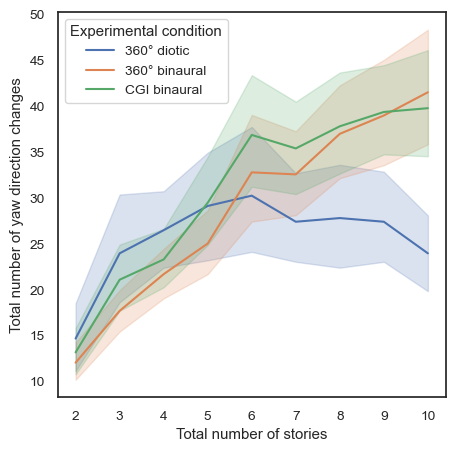

In [219]:
ax = sns.lineplot(x='total_stories_count', y='number_yaw_direction_changes', hue='test_id', data=headrotation_df, palette="deep")
ax.set_xlabel("Total number of stories")
ax.set_ylabel("Total number of yaw direction changes")

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, title='Experimental condition', labels=['360° diotic', '360° binaural', 'CGI binaural'])
d(ax)
save_fig(ax, "", "plots/lineplot_total_yaw_direction_changes.pdf")
save_fig(ax, "", "plots/lineplot_total_yaw_direction_changes.png")
d(headrotation_df.groupby(["test_id", "total_stories_count"])["number_yaw_direction_changes"].mean().reset_index())

# Number of yaw direction changes per second

<Axes: xlabel='Total number of stories', ylabel='Number of yaw direction changes per second'>

,test_id,total_stories_count,number_yaw_direction_changes_per_s
0,1,2,0.494109
1,1,3,0.420675
2,1,4,0.322663
3,1,5,0.265770
4,1,6,0.262961
5,1,7,0.231545
6,1,8,0.244768
7,1,9,0.229749
8,1,10,0.204243
9,2,2,0.560779


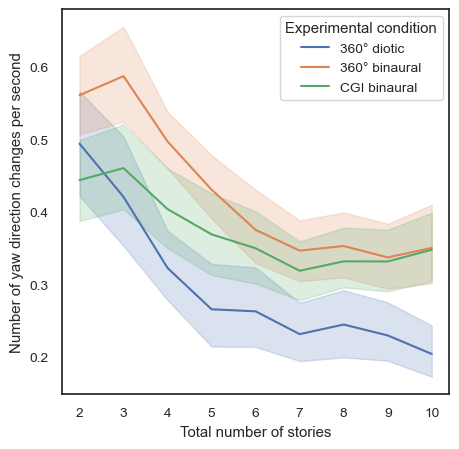

In [220]:
ax = sns.lineplot(x='total_stories_count', y='number_yaw_direction_changes_per_s', hue='test_id', data=headrotation_df, palette="deep")
ax.set_xlabel("Total number of stories")
ax.set_ylabel("Number of yaw direction changes per second")

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, title='Experimental condition', labels=['360° diotic', '360° binaural', 'CGI binaural'])
d(ax)
save_fig(ax, "", "plots/lineplot_number_yaw_direction_changes_per_s.pdf")
save_fig(ax, "", "plots/lineplot_number_yaw_direction_changes_per_s.png")
d(headrotation_df.groupby(["test_id", "total_stories_count"])["number_yaw_direction_changes_per_s"].mean().reset_index())

In [221]:
pandas2ri.activate()
r_df = pandas2ri.py2rpy(headrotation_df)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
# Change the following to mixed somehow
ro.r('''
df$test_id <- factor(df$test_id)
df$total_stories_count <- factor(df$total_stories_count)
library(ARTool)
m <- art(number_yaw_direction_changes_per_s ~ test_id * total_stories_count  + (1|subject_number), data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
pandas2ri.rpy2py(anova_res).to_csv("data_eval/art_anova_number_yaw_direction_changes_per_s_per_test.csv")
post_hoc_res = ro.r('''
res <- art.con(m, "test_id", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
d(pandas2ri.rpy2py(post_hoc_res))

post_hoc_res = ro.r('''
res <- art.con(m, "test_id:total_stories_count", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
post_hoc_res_df = pandas2ri.rpy2py(post_hoc_res)
desired_contrasts = ['1,2 - 2,2',
'1,2 - 3,2',
'2,2 - 3,2',
 '1,3 - 2,3',
 '1,3 - 3,3',
 '2,3 - 3,3',
 '1,4 - 2,4',
 '1,4 - 3,4',
'2,4 - 3,4',
 '1,5 - 2,5',
 '1,5 - 3,5',
'2,5 - 3,5',
 '1,6 - 2,6',
 '1,6 - 3,6',
'2,6 - 3,6',
 '1,7 - 2,7',
 '1,7 - 3,7',
'2,7 - 3,7',
 '1,8 - 2,8',
 '1,8 - 3,8',
'2,8 - 3,8',
 '1,9 - 2,9',
 '1,9 - 3,9',
'2,9 - 3,9',
 '1,10 - 2,10',
 '1,10 - 3,10',
'2,10 - 3,10'
]
post_hoc_res_df_filtered = post_hoc_res_df[post_hoc_res_df['contrast'].isin(desired_contrasts)].copy()
pvals = post_hoc_res_df_filtered['p.value'].values
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')
post_hoc_res_df_filtered['p.value_corr'] = pvals_corrected

# sort "contrast" 
post_hoc_res_df_filtered['contrast'] = pd.Categorical(
    post_hoc_res_df_filtered['contrast'],
    categories=desired_contrasts,
    ordered=True
)
post_hoc_res_df_filtered.sort_values('contrast', inplace=True)

d(post_hoc_res_df_filtered)
post_hoc_res_df_filtered.to_csv("data_eval/art_post-hoc_number_yaw_direction_changes_per_s_per_test.csv")

,Term,F,Df,Df.res,Pr(>F)
test_id,test_id,11.969379,2.0,92.0,2.397299e-05
total_stories_count,total_stories_count,50.405161,8.0,736.0,5.704414e-65
test_id:total_stories_count,test_id:total_stories_count,2.763602,16.0,736.0,2.478211e-04


R[write to console]: NOTE: Results may be misleading due to involvement in interactions



,contrast,estimate,SE,df,t.ratio,p.value
1,test_id1 - test_id2,-223.804938,45.757168,92.0,-4.891145,0.000004
2,test_id1 - test_id3,-136.758824,46.305440,92.0,-2.953407,0.003989
3,test_id2 - test_id3,87.046115,42.031393,92.0,2.070979,0.041162


,contrast,estimate,SE,df,t.ratio,p.value,p.value_corr
35,"1,2 - 2,2",-85.878333,54.794624,258.131736,-1.567277,0.118275,1.000000
44,"1,2 - 3,2",41.300588,55.451185,258.131736,0.744810,0.457064,1.000000
224,"2,2 - 3,2",127.178922,50.332975,258.131736,2.526752,0.012111,0.326984
60,"1,3 - 2,3",-181.372222,54.794624,258.131736,-3.310037,0.001066,0.028778
69,"1,3 - 3,3",-58.150000,55.451185,258.131736,-1.048670,0.295311,1.000000
240,"2,3 - 3,3",123.222222,50.332975,258.131736,2.448141,0.015026,0.405699
84,"1,4 - 2,4",-264.845000,54.794624,258.131736,-4.833412,0.000002,0.000062
93,"1,4 - 3,4",-119.293529,55.451185,258.131736,-2.151325,0.032379,0.874224
255,"2,4 - 3,4",145.551471,50.332975,258.131736,2.891772,0.004157,0.112243
107,"1,5 - 2,5",-268.671667,54.794624,258.131736,-4.903249,0.000002,0.000045


In [222]:
d(headrotation_df_aov_mod)

shapiro = pg.normality(headrotation_df_aov_mod, dv="number_yaw_direction_changes", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(headrotation_df_aov_mod, dv="number_yaw_direction_changes", group="test_id", method='levene', alpha=0.05)
d(levene)

aov = pg.mixed_anova(data=headrotation_df_aov_mod, dv="number_yaw_direction_changes", within="total_stories_count", subject="subject_number", between="test_id", correction='auto', effsize='np2')
d(aov)
aov.to_csv("data_eval/anova_total_yaw_direction_changes_per_test.csv")

post_hoc = pg.pairwise_tests(
    data=headrotation_df_aov_mod,
    dv="number_yaw_direction_changes",
    within="total_stories_count",
    between="test_id",
    subject="subject_number",
    padjust="bonf"
)
d(post_hoc)
post_hoc.to_csv("data_eval/post-hoc_total_yaw_direction_changes_per_test.csv")

,subject_number,test_id,total_stories_count,total_time_s,total_pitch_explored,total_yaw_explored,total_degrees_explored,delta_minmax_pitch,delta_minmax_yaw,number_yaw_direction_changes,number_yaw_direction_changes_per_s
0,1,1,10,120.0,407.095176,2492.906113,2900.001289,48.162250,360.0000,59,0.491667
1,1,1,2,30.0,290.117333,1529.519737,1819.637070,45.980766,360.0000,26,0.866667
2,1,1,3,43.0,444.227190,1514.937271,1959.164461,58.791070,360.0000,49,1.139535
3,1,1,4,67.0,336.393080,1458.437674,1794.830754,42.789051,360.0000,24,0.358209
4,1,1,5,120.0,670.065976,2464.669624,3134.735600,47.265210,360.0000,75,0.625000
...,...,...,...,...,...,...,...,...,...,...,...
850,95,3,5,120.0,451.618628,2149.432621,2601.051250,34.295810,358.8708,63,0.525000
851,95,3,6,120.0,666.251841,2316.035590,2982.287431,32.611570,359.9743,90,0.750000
852,95,3,7,120.0,363.714789,1562.933264,1926.648053,32.019825,359.6326,50,0.416667
853,95,3,8,120.0,414.388384,1710.020308,2124.408693,34.098290,359.7290,51,0.425000


,W,pval,normal
test_id,,,
1,0.880857,2.626262e-12,False
2,0.911661,7.433876e-13,False
3,0.954657,3.934067e-08,False


,W,pval,equal_var
levene,5.921187,0.002794,False


C:\Users\sfremerey\AppData\Roaming\Python\Python311\site-packages\pingouin\parametric.py:1572: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,test_id,3273.230571,2,92,1636.615286,1.664365,1.949596e-01,NaN,0.034918,NaN,NaN,NaN,NaN
1,total_stories_count,49517.251462,8,736,6189.656433,63.583015,6.273988e-79,7.457844e-44,0.408676,0.584925,False,0.126182,6.513489e-23
2,Interaction,9205.107492,16,736,575.319218,5.909945,2.728523e-12,NaN,0.113850,NaN,NaN,NaN,NaN


,Contrast,total_stories_count,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,total_stories_count,-,2.0,3.0,True,True,-7.625775,94.000000,two-sided,1.931708e-11,6.954147e-10,bonf,4.53e+08,-0.761513
1,total_stories_count,-,2.0,4.0,True,True,-10.174570,94.000000,two-sided,7.826901e-17,2.817685e-15,bonf,7.682e+13,-1.192587
2,total_stories_count,-,2.0,5.0,True,True,-11.719478,94.000000,two-sided,4.376040e-20,1.575374e-18,bonf,1.145e+17,-1.317261
3,total_stories_count,-,2.0,6.0,True,True,-11.899616,94.000000,two-sided,1.847223e-20,6.650004e-19,bonf,2.659e+17,-1.472960
4,total_stories_count,-,2.0,7.0,True,True,-14.145783,94.000000,two-sided,5.167323e-25,1.860236e-23,bonf,7.637e+21,-1.668149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,total_stories_count * test_id,9,1,3,False,True,-3.149921,55.521039,two-sided,2.629887e-03,7.100695e-02,bonf,14.008,-0.800153
62,total_stories_count * test_id,9,2,3,False,True,-0.096537,67.844931,two-sided,9.233786e-01,1.000000e+00,bonf,0.247,-0.022761
63,total_stories_count * test_id,10,1,2,False,True,-4.462572,56.745703,two-sided,3.892020e-05,1.050846e-03,bonf,526.462,-1.041284
64,total_stories_count * test_id,10,1,3,False,True,-4.416588,56.456707,two-sided,4.589145e-05,1.239069e-03,bonf,440.557,-1.080417


In [223]:
pandas2ri.activate()
r_df = pandas2ri.py2rpy(headrotation_df_aov_mod)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
# Change the following to mixed somehow
ro.r('''
df$test_id <- factor(df$test_id)
df$total_stories_count <- factor(df$total_stories_count)
library(ARTool)
m <- art(number_yaw_direction_changes ~ test_id * total_stories_count  + (1|subject_number), data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
pandas2ri.rpy2py(anova_res).to_csv("data_eval/art_anova_total_yaw_direction_changes_per_test.csv")
post_hoc_res = ro.r('''
res <- art.con(m, "test_id", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
d(pandas2ri.rpy2py(post_hoc_res))

post_hoc_res = ro.r('''
res <- art.con(m, "test_id:total_stories_count", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
post_hoc_res_df = pandas2ri.rpy2py(post_hoc_res)
desired_contrasts = ['1,2 - 2,2',
'1,2 - 3,2',
'2,2 - 3,2',
 '1,3 - 2,3',
 '1,3 - 3,3',
 '2,3 - 3,3',
 '1,4 - 2,4',
 '1,4 - 3,4',
'2,4 - 3,4',
 '1,5 - 2,5',
 '1,5 - 3,5',
'2,5 - 3,5',
 '1,6 - 2,6',
 '1,6 - 3,6',
'2,6 - 3,6',
 '1,7 - 2,7',
 '1,7 - 3,7',
'2,7 - 3,7',
 '1,8 - 2,8',
 '1,8 - 3,8',
'2,8 - 3,8',
 '1,9 - 2,9',
 '1,9 - 3,9',
'2,9 - 3,9',
 '1,10 - 2,10',
 '1,10 - 3,10',
'2,10 - 3,10'
]
post_hoc_res_df_filtered = post_hoc_res_df[post_hoc_res_df['contrast'].isin(desired_contrasts)].copy()
pvals = post_hoc_res_df_filtered['p.value'].values
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')
post_hoc_res_df_filtered['p.value_corr'] = pvals_corrected

# sort "contrast" 
post_hoc_res_df_filtered['contrast'] = pd.Categorical(
    post_hoc_res_df_filtered['contrast'],
    categories=desired_contrasts,
    ordered=True
)
post_hoc_res_df_filtered.sort_values('contrast', inplace=True)

d(post_hoc_res_df_filtered)
post_hoc_res_df_filtered.to_csv("data_eval/art_post-hoc_total_yaw_direction_changes_per_test.csv")

,Term,F,Df,Df.res,Pr(>F)
test_id,test_id,2.783847,2.0,92.0,6.701350e-02
total_stories_count,total_stories_count,77.098352,8.0,736.0,4.226861e-92
test_id:total_stories_count,test_id:total_stories_count,6.539666,16.0,736.0,5.931120e-14


R[write to console]: NOTE: Results may be misleading due to involvement in interactions



,contrast,estimate,SE,df,t.ratio,p.value
1,test_id1 - test_id2,-83.078086,47.212764,92.0,-1.759653,0.081791
2,test_id1 - test_id3,-110.044771,47.778478,92.0,-2.303229,0.023519
3,test_id2 - test_id3,-26.966685,43.368468,92.0,-0.621804,0.535609


,contrast,estimate,SE,df,t.ratio,p.value,p.value_corr
35,"1,2 - 2,2",54.599444,53.281031,310.366669,1.024745,0.306282,1.000000
44,"1,2 - 3,2",24.632941,53.919455,310.366669,0.456847,0.648101,1.000000
224,"2,2 - 3,2",-29.966503,48.942626,310.366669,-0.612278,0.540802,1.000000
60,"1,3 - 2,3",95.783889,53.281031,310.366669,1.797711,0.073195,1.000000
69,"1,3 - 3,3",27.049412,53.919455,310.366669,0.501663,0.616260,1.000000
240,"2,3 - 3,3",-68.734477,48.942626,310.366669,-1.404389,0.161203,1.000000
84,"1,4 - 2,4",91.076667,53.281031,310.366669,1.709364,0.088383,1.000000
93,"1,4 - 3,4",58.351176,53.919455,310.366669,1.082192,0.280008,1.000000
255,"2,4 - 3,4",-32.725490,48.942626,310.366669,-0.668650,0.504216,1.000000
107,"1,5 - 2,5",48.955000,53.281031,310.366669,0.918807,0.358910,1.000000


# Further data processing (ETL)

In [224]:
# Unity - behaviour CSV (timestamp, controller interaction, head rotation, etc.)
# Including all pitch_yaw_roll data

def map_yaw_to_chair(yaw_value):
    chair_index = int(yaw_value // 18)
    chair_index += 10  # chair_index corresponds to yaw = 0 (chair 10 here)
    return chair_index % 20 if chair_index % 20 != 0 else 20

headrotation_big_df = pd.DataFrame()

for test_id, test_name in zip(test_ids, test_names):
    for file in glob.glob('../subjective_data/{}/Unity/*.csv'.format(test_name)):
        if not "training" in file:
            subject = Path(file).stem.split('_')[0]
            total_stories = Path(file).stem.split('_')[1]
            df = pd.read_csv(file, index_col=False)
            total_time_s = (pd.to_datetime(df['TimeStamp'].iloc[-1], format='%d.%m.%Y %H:%M:%S') - pd.to_datetime(df['TimeStamp'].iloc[0], format='%d.%m.%Y %H:%M:%S')).total_seconds()
            chairs_time_s = [0] * 20
            for idx, row in df.iterrows():
                yaw_value = row["VRCameraYaw"]
                chair_index = map_yaw_to_chair(yaw_value) - 1
                chairs_time_s[chair_index] += 1
            chairs_time_s = [time_s / len(df) * total_time_s for time_s in chairs_time_s]
            tmp_dict = {
                'subject_number': [subject],
                'test_id': [test_id],
                'total_stories_count': [total_stories],
                'total_time_s': [total_time_s],
            }
            tmp_dict.update({f'chair_{i+1}.time_s': [time_s] for i, time_s in enumerate(chairs_time_s)})
            tmp_df = pd.DataFrame(tmp_dict)
            headrotation_big_df = pd.concat([headrotation_big_df, tmp_df], ignore_index=True)
headrotation_big_df = headrotation_big_df.apply(pd.to_numeric)
d(headrotation_big_df)
# headrotation_big_df.to_excel("headrotation_big_df.xlsx", sheet_name='headrotation_big_df')

,subject_number,test_id,total_stories_count,total_time_s,chair_1.time_s,chair_2.time_s,chair_3.time_s,chair_4.time_s,chair_5.time_s,chair_6.time_s,chair_7.time_s,chair_8.time_s,chair_9.time_s,chair_10.time_s,chair_11.time_s,chair_12.time_s,chair_13.time_s,chair_14.time_s,chair_15.time_s,chair_16.time_s,chair_17.time_s,chair_18.time_s,chair_19.time_s,chair_20.time_s
0,10,1,10,120.0,7.171181,7.863725,7.729684,3.898352,14.521083,7.115331,1.128176,2.647305,1.898911,7.785535,7.785535,13.862050,3.462720,7.718514,6.478637,1.530299,2.714326,1.541469,4.412175,8.734990
1,10,1,2,30.0,1.019364,2.060650,0.712459,0.778224,0.920716,1.096091,1.052247,1.501644,5.491414,5.601023,1.172817,1.260504,0.833029,0.789185,0.657654,1.019364,1.096091,1.063208,0.964560,0.909755
2,10,1,3,43.0,2.174094,1.311181,0.728434,0.683607,0.582747,0.605160,0.907740,0.851707,1.311181,6.376596,1.266354,0.762054,0.750847,0.706020,0.493094,0.784467,0.997394,3.339588,9.122231,9.245504
3,10,1,4,67.0,19.243845,14.699380,0.650812,0.628370,0.605929,0.493720,1.380171,0.987439,8.898175,1.178195,0.987439,1.021102,1.413834,0.864009,0.538603,0.650812,0.617150,0.852788,0.785463,10.502763
4,10,1,5,120.0,0.502793,5.832402,22.960894,8.134078,1.642458,0.648045,0.692737,1.083799,2.379888,24.122905,2.737430,32.379888,6.748603,0.938547,0.491620,1.117318,0.759777,4.804469,1.754190,0.268156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850,9,3,5,120.0,2.495274,10.071834,10.480151,1.179584,7.599244,11.137996,4.763705,5.172023,8.030246,4.015123,20.302457,4.967864,4.604915,7.508507,2.381853,0.952741,5.784499,3.175803,3.992439,1.383743
851,9,3,6,121.0,16.903348,6.389996,2.338980,3.978677,0.651056,0.578717,0.144679,3.038262,9.621164,4.292148,1.856716,5.425468,3.520526,8.174372,3.424073,8.656636,5.521921,8.005580,12.804105,15.673575
852,9,3,7,121.0,3.018913,0.000000,0.852113,1.898994,3.189336,5.453521,25.441650,3.311066,10.785312,4.844869,2.264185,5.210060,12.246076,8.375050,7.036016,1.777264,11.126157,3.846680,4.114487,6.208249
853,9,3,8,121.0,6.433538,6.298569,8.368098,2.564417,3.711656,9.087935,3.531697,18.693252,6.096115,4.274029,3.981595,5.376278,8.345603,4.588957,4.274029,3.306748,1.192229,11.404908,2.631902,6.838446


In [225]:
columns_to_merge = ['test_id', 'subject_number', 'total_stories_count']
speaker_story_mapping_df = speaker_story_mapping_df.apply(pd.to_numeric)
headrotation_big_speaker_story_mapping_df = pd.merge(headrotation_big_df, speaker_story_mapping_df, on=columns_to_merge)
columns_to_drop = [
    'chair_1.speaker', 'chair_1.assigned_story',
    'chair_2.speaker', 'chair_2.assigned_story',
    'chair_3.speaker', 'chair_3.assigned_story',
    'chair_4.speaker', 'chair_4.assigned_story',
    'chair_5.speaker', 'chair_5.assigned_story',
    'chair_6.speaker', 'chair_6.assigned_story',
    'chair_7.speaker', 'chair_7.assigned_story',
    'chair_8.speaker', 'chair_8.assigned_story',
    'chair_9.speaker', 'chair_9.assigned_story',
    'chair_10.speaker', 'chair_10.assigned_story',
    'chair_11.speaker', 'chair_11.assigned_story',
    'chair_12.speaker', 'chair_12.assigned_story',
    'chair_13.speaker', 'chair_13.assigned_story',
    'chair_14.speaker', 'chair_14.assigned_story',
    'chair_15.speaker', 'chair_15.assigned_story',
    'chair_16.speaker', 'chair_16.assigned_story',
    'chair_17.speaker', 'chair_17.assigned_story',
    'chair_18.speaker', 'chair_18.assigned_story',
    'chair_19.speaker', 'chair_19.assigned_story',
    'chair_20.speaker', 'chair_20.assigned_story'
]
headrotation_big_speaker_story_mapping_df = headrotation_big_speaker_story_mapping_df.drop(columns=columns_to_drop)
d(headrotation_big_speaker_story_mapping_df)

,subject_number,test_id,total_stories_count,total_time_s,chair_1.time_s,chair_2.time_s,chair_3.time_s,chair_4.time_s,chair_5.time_s,chair_6.time_s,chair_7.time_s,chair_8.time_s,chair_9.time_s,chair_10.time_s,chair_11.time_s,chair_12.time_s,chair_13.time_s,chair_14.time_s,chair_15.time_s,chair_16.time_s,chair_17.time_s,chair_18.time_s,chair_19.time_s,chair_20.time_s,chair_1.story,chair_2.story,chair_3.story,chair_4.story,chair_5.story,chair_6.story,chair_7.story,chair_8.story,chair_9.story,chair_10.story,chair_11.story,chair_12.story,chair_13.story,chair_14.story,chair_15.story,chair_16.story,chair_17.story,chair_18.story,chair_19.story,chair_20.story,scene,assigned_stories_count,correctly_assigned_stories_count,correctly_assigned_stories_percentage,wrongly_assigned_stories_count,no_assigned_stories_count,wrongly_assigned_stories_percentage,no_assigned_stories_percentage,number_of_trial_in_test,deviation_count,distance_between_speakers
0,10,1,10,120.0,7.171181,7.863725,7.729684,3.898352,14.521083,7.115331,1.128176,2.647305,1.898911,7.785535,7.785535,13.862050,3.462720,7.718514,6.478637,1.530299,2.714326,1.541469,4.412175,8.734990,11,11,2,11,7,11,11,11,11,3,9,5,11,10,11,8,1,6,4,11,13,1,0,0.000000,1,9,10.000000,90.000000,9,126,288
1,10,1,2,30.0,1.019364,2.060650,0.712459,0.778224,0.920716,1.096091,1.052247,1.501644,5.491414,5.601023,1.172817,1.260504,0.833029,0.789185,0.657654,1.019364,1.096091,1.063208,0.964560,0.909755,11,11,11,11,11,11,11,11,9,6,11,11,11,11,11,11,11,11,11,11,11,2,2,100.000000,0,0,0.000000,0.000000,7,0,18
2,10,1,3,43.0,2.174094,1.311181,0.728434,0.683607,0.582747,0.605160,0.907740,0.851707,1.311181,6.376596,1.266354,0.762054,0.750847,0.706020,0.493094,0.784467,0.997394,3.339588,9.122231,9.245504,11,11,11,11,11,11,11,11,11,2,11,11,11,11,11,11,11,6,7,11,7,3,3,100.000000,0,0,0.000000,0.000000,3,0,162
3,10,1,4,67.0,19.243845,14.699380,0.650812,0.628370,0.605929,0.493720,1.380171,0.987439,8.898175,1.178195,0.987439,1.021102,1.413834,0.864009,0.538603,0.650812,0.617150,0.852788,0.785463,10.502763,2,4,11,11,11,11,11,11,9,11,11,11,11,11,11,11,11,11,11,1,8,4,4,100.000000,0,0,0.000000,0.000000,4,0,306
4,10,1,5,120.0,0.502793,5.832402,22.960894,8.134078,1.642458,0.648045,0.692737,1.083799,2.379888,24.122905,2.737430,32.379888,6.748603,0.938547,0.491620,1.117318,0.759777,4.804469,1.754190,0.268156,11,11,8,11,11,11,11,11,11,3,11,4,9,11,11,11,11,6,11,11,12,4,4,80.000000,0,1,0.000000,20.000000,8,0,270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850,9,3,5,120.0,2.495274,10.071834,10.480151,1.179584,7.599244,11.137996,4.763705,5.172023,8.030246,4.015123,20.302457,4.967864,4.604915,7.508507,2.381853,0.952741,5.784499,3.175803,3.992439,1.383743,11,11,2,11,4,11,11,11,7,11,11,11,3,11,11,11,11,10,11,11,6,4,4,80.000000,0,1,0.000000,20.000000,2,0,270
851,9,3,6,121.0,16.903348,6.389996,2.338980,3.978677,0.651056,0.578717,0.144679,3.038262,9.621164,4.292148,1.856716,5.425468,3.520526,8.174372,3.424073,8.656636,5.521921,8.005580,12.804105,15.673575,11,3,11,11,11,11,11,10,7,11,11,11,11,11,11,8,11,11,6,5,12,5,5,83.333333,0,1,0.000000,16.666667,8,0,324
852,9,3,7,121.0,3.018913,0.000000,0.852113,1.898994,3.189336,5.453521,25.441650,3.311066,10.785312,4.844869,2.264185,5.210060,12.246076,8.375050,7.036016,1.777264,11.126157,3.846680,4.114487,6.208249,6,11,11,11,11,11,10,4,11,11,11,11,11,3,11,8,11,1,9,11,7,3,1,14.285714,2,4,28.571429,57.142857,3,0,324
853,9,3,8,121.0,6.433538,6.298569,8.368098,2.564417,3.711656,9.087935,3.531697,18.693252,6.096115,4.274029,3.981595,5.376278,8.345603,4.588957,4.274029,3.306748,1.192229,11.404908,2.631902,6.838446,11,4,1,11,5,10,11,2,3,11,11,11,11,11,11,11,11,6,11,7,5,4,3,37.500000,1,4,12.500000,50.000000,1,18,324


# Proportion of time spent watching active speakers

In [226]:
headrotation_big_speaker_story_mapping_df['time_spent_watching_active_speakers'] = 0

# Loop through each row to calculate the time spent watching active speakers
for idx, row in headrotation_big_speaker_story_mapping_df.iterrows():
    time_spent = 0
    for chair_num in range(1, 21):
        story_col = f'chair_{chair_num}.story'
        time_col = f'chair_{chair_num}.time_s'
        if row[story_col] != 11:  # Check if the story is not 11
            time_spent += row[time_col]  # Add the time spent on this chair
            
    headrotation_big_speaker_story_mapping_df.at[idx, 'time_spent_watching_active_speakers'] = time_spent
    
headrotation_big_speaker_story_mapping_df['time_spent_watching_active_speakers_percentage'] = (
    headrotation_big_speaker_story_mapping_df['time_spent_watching_active_speakers'] / headrotation_big_speaker_story_mapping_df['total_time_s'] * 100
)
d(headrotation_big_speaker_story_mapping_df)

,subject_number,test_id,total_stories_count,total_time_s,chair_1.time_s,chair_2.time_s,chair_3.time_s,chair_4.time_s,chair_5.time_s,chair_6.time_s,chair_7.time_s,chair_8.time_s,chair_9.time_s,chair_10.time_s,chair_11.time_s,chair_12.time_s,chair_13.time_s,chair_14.time_s,chair_15.time_s,chair_16.time_s,chair_17.time_s,chair_18.time_s,chair_19.time_s,chair_20.time_s,chair_1.story,chair_2.story,chair_3.story,chair_4.story,chair_5.story,chair_6.story,chair_7.story,chair_8.story,chair_9.story,chair_10.story,chair_11.story,chair_12.story,chair_13.story,chair_14.story,chair_15.story,chair_16.story,chair_17.story,chair_18.story,chair_19.story,chair_20.story,scene,assigned_stories_count,correctly_assigned_stories_count,correctly_assigned_stories_percentage,wrongly_assigned_stories_count,no_assigned_stories_count,wrongly_assigned_stories_percentage,no_assigned_stories_percentage,number_of_trial_in_test,deviation_count,distance_between_speakers,time_spent_watching_active_speakers,time_spent_watching_active_speakers_percentage
0,10,1,10,120.0,7.171181,7.863725,7.729684,3.898352,14.521083,7.115331,1.128176,2.647305,1.898911,7.785535,7.785535,13.862050,3.462720,7.718514,6.478637,1.530299,2.714326,1.541469,4.412175,8.734990,11,11,2,11,7,11,11,11,11,3,9,5,11,10,11,8,1,6,4,11,13,1,0,0.000000,1,9,10.000000,90.000000,9,126,288,69.600670,58.000559
1,10,1,2,30.0,1.019364,2.060650,0.712459,0.778224,0.920716,1.096091,1.052247,1.501644,5.491414,5.601023,1.172817,1.260504,0.833029,0.789185,0.657654,1.019364,1.096091,1.063208,0.964560,0.909755,11,11,11,11,11,11,11,11,9,6,11,11,11,11,11,11,11,11,11,11,11,2,2,100.000000,0,0,0.000000,0.000000,7,0,18,11.092437,36.974790
2,10,1,3,43.0,2.174094,1.311181,0.728434,0.683607,0.582747,0.605160,0.907740,0.851707,1.311181,6.376596,1.266354,0.762054,0.750847,0.706020,0.493094,0.784467,0.997394,3.339588,9.122231,9.245504,11,11,11,11,11,11,11,11,11,2,11,11,11,11,11,11,11,6,7,11,7,3,3,100.000000,0,0,0.000000,0.000000,3,0,162,18.838415,43.810268
3,10,1,4,67.0,19.243845,14.699380,0.650812,0.628370,0.605929,0.493720,1.380171,0.987439,8.898175,1.178195,0.987439,1.021102,1.413834,0.864009,0.538603,0.650812,0.617150,0.852788,0.785463,10.502763,2,4,11,11,11,11,11,11,9,11,11,11,11,11,11,11,11,11,11,1,8,4,4,100.000000,0,0,0.000000,0.000000,4,0,306,53.344163,79.618154
4,10,1,5,120.0,0.502793,5.832402,22.960894,8.134078,1.642458,0.648045,0.692737,1.083799,2.379888,24.122905,2.737430,32.379888,6.748603,0.938547,0.491620,1.117318,0.759777,4.804469,1.754190,0.268156,11,11,8,11,11,11,11,11,11,3,11,4,9,11,11,11,11,6,11,11,12,4,4,80.000000,0,1,0.000000,20.000000,8,0,270,91.016760,75.847300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850,9,3,5,120.0,2.495274,10.071834,10.480151,1.179584,7.599244,11.137996,4.763705,5.172023,8.030246,4.015123,20.302457,4.967864,4.604915,7.508507,2.381853,0.952741,5.784499,3.175803,3.992439,1.383743,11,11,2,11,4,11,11,11,7,11,11,11,3,11,11,11,11,10,11,11,6,4,4,80.000000,0,1,0.000000,20.000000,2,0,270,33.890359,28.241966
851,9,3,6,121.0,16.903348,6.389996,2.338980,3.978677,0.651056,0.578717,0.144679,3.038262,9.621164,4.292148,1.856716,5.425468,3.520526,8.174372,3.424073,8.656636,5.521921,8.005580,12.804105,15.673575,11,3,11,11,11,11,11,10,7,11,11,11,11,11,11,8,11,11,6,5,12,5,5,83.333333,0,1,0.000000,16.666667,8,0,324,56.183739,46.432842
852,9,3,7,121.0,3.018913,0.000000,0.852113,1.898994,3.189336,5.453521,25.441650,3.311066,10.785312,4.844869,2.264185,5.210060,12.246076,8.375050,7.036016,1.777264,11.126157,3.846680,4.114487,6.208249,6,11,11,11,11,11,10,4,11,11,11,11,11,3,11,8,11,1,9,11,7,3,1,14.285714,2,4,28.571429,57.142857,3,0,324,49.885111,41.227364
853,9,3,8,121.0,6.433538,6.298569,8.368098,2.564417,3.711656,9.087935,3.531697,18.693252,6.096115,4.274029,3.981595,5.376278,8.345603,4.588957,4.274029,3.306748,1.192229,11

<Axes: xlabel='Total number of stories', ylabel='Proportion of time spent watching active speakers [%]'>

,test_id,total_stories_count,time_spent_watching_active_speakers_percentage
0,1,2,47.964526
1,1,3,54.486004
2,1,4,63.732925
3,1,5,66.452231
4,1,6,73.483134
5,1,7,71.662432
6,1,8,73.805615
7,1,9,78.129746
8,1,10,79.203465
9,2,2,50.759963


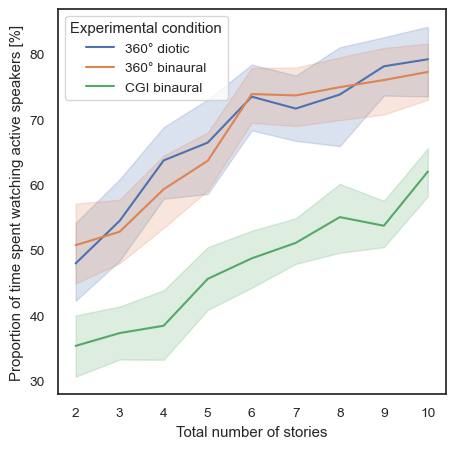

In [227]:
ax = sns.lineplot(x='total_stories_count', y='time_spent_watching_active_speakers_percentage', hue='test_id', data=headrotation_big_speaker_story_mapping_df, palette="deep")
ax.set_xlabel("Total number of stories")
ax.set_ylabel("Proportion of time spent watching active speakers [%]")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, title='Experimental condition', labels=['360° diotic', '360° binaural', 'CGI binaural'])
d(ax)

save_fig(ax, "", "plots/lineplot_timespentwatchingactivespeakerspercentage_per_test.pdf")
save_fig(ax, "", "plots/lineplot_timespentwatchingactivespeakerspercentage_per_test.png")
d(headrotation_big_speaker_story_mapping_df.groupby(["test_id", "total_stories_count"])["time_spent_watching_active_speakers_percentage"].mean().reset_index())

# Time spent watching active speakers

<Axes: xlabel='Total number of stories', ylabel='Time spent watching active speakers [s]'>

,test_id,total_stories_count,time_spent_watching_active_speakers
0,1,2,14.644466
1,1,3,31.003110
2,1,4,55.372921
3,1,5,74.383520
4,1,6,84.904664
5,1,7,84.897058
6,1,8,85.437086
7,1,9,93.321660
8,1,10,93.636963
9,2,2,11.779833


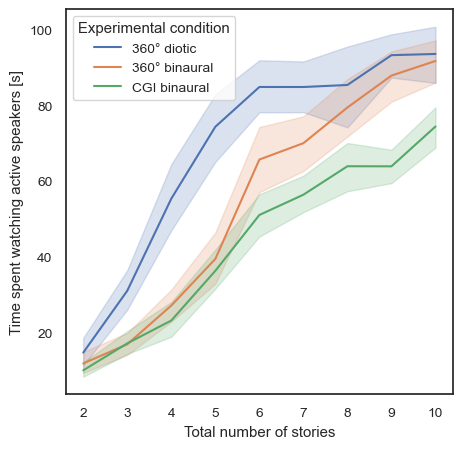

In [228]:
ax = sns.lineplot(x='total_stories_count', y='time_spent_watching_active_speakers', hue='test_id', data=headrotation_big_speaker_story_mapping_df, palette="deep")
ax.set_xlabel("Total number of stories")
ax.set_ylabel("Time spent watching active speakers [s]")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, title='Experimental condition', labels=['360° diotic', '360° binaural', 'CGI binaural'])
d(ax)

save_fig(ax, "", "plots/lineplot_timespentwatchingactivespeakers_per_test.pdf")
save_fig(ax, "", "plots/lineplot_timespentwatchingactivespeakers_per_test.png")
d(headrotation_big_speaker_story_mapping_df.groupby(["test_id", "total_stories_count"])["time_spent_watching_active_speakers"].mean().reset_index())

In [229]:
headrotation_big_speaker_story_mapping_df_aov_mod = headrotation_big_speaker_story_mapping_df[["subject_number", "test_id", "total_stories_count", "time_spent_watching_active_speakers_percentage"]]
headrotation_big_speaker_story_mapping_df_aov_mod['subject_number'] = (headrotation_big_speaker_story_mapping_df_aov_mod.index // 9) + 1

d(headrotation_big_speaker_story_mapping_df_aov_mod)

shapiro = pg.normality(headrotation_big_speaker_story_mapping_df_aov_mod, dv="time_spent_watching_active_speakers_percentage", group="test_id", method='shapiro', alpha=0.05)
d(shapiro)

levene = pg.homoscedasticity(headrotation_big_speaker_story_mapping_df_aov_mod, dv="time_spent_watching_active_speakers_percentage", group="test_id", method='levene', alpha=0.05)
d(levene)

aov = pg.mixed_anova(data=headrotation_big_speaker_story_mapping_df_aov_mod, dv="time_spent_watching_active_speakers_percentage", within="total_stories_count", subject="subject_number", between="test_id", correction='auto', effsize='np2')
d(aov)
aov.to_csv("data_eval/anova_time_spent_watching_active_speakers_per_test.csv")

post_hoc = pg.pairwise_tests(
    data=headrotation_big_speaker_story_mapping_df_aov_mod,
    dv="time_spent_watching_active_speakers_percentage",
    within="total_stories_count",
    between="test_id",
    subject="subject_number",
    padjust="bonf"
)
d(post_hoc)
post_hoc.to_csv("data_eval/post-hoc_time_spent_watching_active_speakers_per_test.csv")

C:\Users\sfremerey\AppData\Local\Temp\ipykernel_19644\1247045473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  headrotation_big_speaker_story_mapping_df_aov_mod['subject_number'] = (headrotation_big_speaker_story_mapping_df_aov_mod.index // 9) + 1


,subject_number,test_id,total_stories_count,time_spent_watching_active_speakers_percentage
0,1,1,10,58.000559
1,1,1,2,36.974790
2,1,1,3,43.810268
3,1,1,4,79.618154
4,1,1,5,75.847300
...,...,...,...,...
850,95,3,5,28.241966
851,95,3,6,46.432842
852,95,3,7,41.227364
853,95,3,8,58.263618


,W,pval,normal
test_id,,,
1,0.960045,0.000006,False
2,0.970637,0.000004,False
3,0.992353,0.117414,True


,W,pval,equal_var
levene,2.762186,0.063719,True


C:\Users\sfremerey\AppData\Roaming\Python\Python311\site-packages\pingouin\parametric.py:1572: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,test_id,76638.200832,2,92,38319.100416,58.720833,3.675685e-17,NaN,0.560737,NaN,NaN,NaN,NaN
1,total_stories_count,73620.058878,8,736,9202.507360,57.154568,2.871153e-72,3.368536e-61,0.383190,0.839665,False,0.463304,0.000395
2,Interaction,3057.656737,16,736,191.103546,1.186898,2.724618e-01,NaN,0.025153,NaN,NaN,NaN,NaN


,Contrast,total_stories_count,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,total_stories_count,-,2.0,3.0,True,True,-1.568042,94.000000,two-sided,1.202316e-01,1.000000e+00,bonf,0.369,-0.184889
1,total_stories_count,-,2.0,4.0,True,True,-4.208797,94.000000,two-sided,5.870526e-05,2.113389e-03,bonf,307.026,-0.445846
2,total_stories_count,-,2.0,5.0,True,True,-6.161870,94.000000,two-sided,1.774427e-08,6.387937e-07,bonf,6.467e+05,-0.738282
3,total_stories_count,-,2.0,6.0,True,True,-9.098181,94.000000,two-sided,1.520523e-14,5.473882e-13,bonf,4.575e+11,-1.118055
4,total_stories_count,-,2.0,7.0,True,True,-9.586304,94.000000,two-sided,1.392759e-15,5.013932e-14,bonf,4.665e+12,-1.174308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,total_stories_count * test_id,9,1,3,False,True,8.008785,47.928767,two-sided,2.157895e-10,5.826317e-09,bonf,9.877e+07,2.122700
62,total_stories_count * test_id,9,2,3,False,True,7.068776,62.686162,two-sided,1.552231e-09,4.191024e-08,bonf,7.597e+06,1.655061
63,total_stories_count * test_id,10,1,2,False,True,0.537206,52.153386,two-sided,5.934099e-01,1.000000e+00,bonf,0.298,0.137790
64,total_stories_count * test_id,10,1,3,False,True,5.002467,47.328821,two-sided,8.224940e-06,2.220734e-04,bonf,2744.799,1.329576


In [230]:
pandas2ri.activate()
r_df = pandas2ri.py2rpy(headrotation_big_speaker_story_mapping_df_aov_mod)
ro.globalenv['df'] = r_df
artool = importr('ARTool')
# Change the following to mixed somehow
ro.r('''
df$test_id <- factor(df$test_id)
df$total_stories_count <- factor(df$total_stories_count)
library(ARTool)
m <- art(time_spent_watching_active_speakers_percentage ~ test_id * total_stories_count  + (1|subject_number), data=df)
''')

anova_res = ro.r('anova(m)')
d(pandas2ri.rpy2py(anova_res))
pandas2ri.rpy2py(anova_res).to_csv("data_eval/art_anova_time_spent_watching_active_speakers_per_test.csv")
post_hoc_res = ro.r('''
res <- art.con(m, "test_id", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
d(pandas2ri.rpy2py(post_hoc_res))

post_hoc_res = ro.r('''
res <- art.con(m, "test_id:total_stories_count", adjust="none")
df_res <- as.data.frame(res)
df_res
''')
post_hoc_res_df = pandas2ri.rpy2py(post_hoc_res)
desired_contrasts = ['1,2 - 2,2',
'1,2 - 3,2',
'2,2 - 3,2',
 '1,3 - 2,3',
 '1,3 - 3,3',
 '2,3 - 3,3',
 '1,4 - 2,4',
 '1,4 - 3,4',
'2,4 - 3,4',
 '1,5 - 2,5',
 '1,5 - 3,5',
'2,5 - 3,5',
 '1,6 - 2,6',
 '1,6 - 3,6',
'2,6 - 3,6',
 '1,7 - 2,7',
 '1,7 - 3,7',
'2,7 - 3,7',
 '1,8 - 2,8',
 '1,8 - 3,8',
'2,8 - 3,8',
 '1,9 - 2,9',
 '1,9 - 3,9',
'2,9 - 3,9',
 '1,10 - 2,10',
 '1,10 - 3,10',
'2,10 - 3,10'
]
post_hoc_res_df_filtered = post_hoc_res_df[post_hoc_res_df['contrast'].isin(desired_contrasts)].copy()
pvals = post_hoc_res_df_filtered['p.value'].values
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')
post_hoc_res_df_filtered['p.value_corr'] = pvals_corrected

# sort "contrast" 
post_hoc_res_df_filtered['contrast'] = pd.Categorical(
    post_hoc_res_df_filtered['contrast'],
    categories=desired_contrasts,
    ordered=True
)
post_hoc_res_df_filtered.sort_values('contrast', inplace=True)

d(post_hoc_res_df_filtered)
post_hoc_res_df_filtered.to_csv("data_eval/art_post-hoc_time_spent_watching_active_speakers_per_test.csv")

,Term,F,Df,Df.res,Pr(>F)
test_id,test_id,62.711404,2.0,92.0,6.579689e-18
total_stories_count,total_stories_count,56.480242,8.0,736.0,1.488501e-71
test_id:total_stories_count,test_id:total_stories_count,1.515677,16.0,736.0,8.764871e-02


R[write to console]: NOTE: Results may be misleading due to involvement in interactions



,contrast,estimate,SE,df,t.ratio,p.value
1,test_id1 - test_id2,12.895679,31.641285,92.0,0.407559,6.845446e-01
2,test_id1 - test_id3,298.728105,32.020418,92.0,9.329301,5.884785e-15
3,test_id2 - test_id3,285.832426,29.064896,92.0,9.834284,5.094190e-16


,contrast,estimate,SE,df,t.ratio,p.value,p.value_corr
35,"1,2 - 2,2",-41.343333,47.374136,545.747536,-0.872698,3.832113e-01,1.000000e+00
44,"1,2 - 3,2",125.475294,47.941783,545.747536,2.617243,9.110167e-03,2.459745e-01
224,"2,2 - 3,2",166.818627,43.516699,545.747536,3.833439,1.410822e-04,3.809219e-03
60,"1,3 - 2,3",26.102222,47.374136,545.747536,0.550980,5.818726e-01,1.000000e+00
69,"1,3 - 3,3",204.585882,47.941783,545.747536,4.267382,2.331939e-05,6.296235e-04
240,"2,3 - 3,3",178.483660,43.516699,545.747536,4.101498,4.730677e-05,1.277283e-03
84,"1,4 - 2,4",48.423333,47.374136,545.747536,1.022147,3.071642e-01,1.000000e+00
93,"1,4 - 3,4",299.987059,47.941783,545.747536,6.257320,7.923624e-10,2.139379e-08
255,"2,4 - 3,4",251.563725,43.516699,545.747536,5.780855,1.251317e-08,3.378557e-07
107,"1,5 - 2,5",57.064444,47.374136,545.747536,1.204549,2.288998e-01,1.000000e+00


# Correlation matrices

In [231]:
columns_to_merge = ['test_id', 'subject_number', 'total_stories_count']
for col in columns_to_merge:
    headrotation_df[col] = headrotation_df[col].astype(int)
    speaker_story_mapping_df[col] = speaker_story_mapping_df[col].astype(int)
headrotation_speaker_story_mapping_df = pd.merge(headrotation_df, speaker_story_mapping_df, on=columns_to_merge)
headrotation_speaker_story_mapping_nasatlx_df = pd.merge(headrotation_speaker_story_mapping_df, nasatlx_df, on=['test_id', 'scene', 'subject_number'])
# d(headrotation_speaker_story_mapping_nasatlx_df)

columns_to_drop = [
    'chair_1.speaker', 'chair_1.story', 'chair_1.assigned_story',
    'chair_2.speaker', 'chair_2.story', 'chair_2.assigned_story',
    'chair_3.speaker', 'chair_3.story', 'chair_3.assigned_story',
    'chair_4.speaker', 'chair_4.story', 'chair_4.assigned_story',
    'chair_5.speaker', 'chair_5.story', 'chair_5.assigned_story',
    'chair_6.speaker', 'chair_6.story', 'chair_6.assigned_story',
    'chair_7.speaker', 'chair_7.story', 'chair_7.assigned_story',
    'chair_8.speaker', 'chair_8.story', 'chair_8.assigned_story',
    'chair_9.speaker', 'chair_9.story', 'chair_9.assigned_story',
    'chair_10.speaker', 'chair_10.story', 'chair_10.assigned_story',
    'chair_11.speaker', 'chair_11.story', 'chair_11.assigned_story',
    'chair_12.speaker', 'chair_12.story', 'chair_12.assigned_story',
    'chair_13.speaker', 'chair_13.story', 'chair_13.assigned_story',
    'chair_14.speaker', 'chair_14.story', 'chair_14.assigned_story',
    'chair_15.speaker', 'chair_15.story', 'chair_15.assigned_story',
    'chair_16.speaker', 'chair_16.story', 'chair_16.assigned_story',
    'chair_17.speaker', 'chair_17.story', 'chair_17.assigned_story',
    'chair_18.speaker', 'chair_18.story', 'chair_18.assigned_story',
    'chair_19.speaker', 'chair_19.story', 'chair_19.assigned_story',
    'chair_20.speaker', 'chair_20.story', 'chair_20.assigned_story'
]
headrotation_speaker_story_mapping_nasatlx_df_small = headrotation_speaker_story_mapping_nasatlx_df.drop(columns=columns_to_drop)
# d(headrotation_speaker_story_mapping_nasatlx_df_small)

weinstein_df_reduced = weinstein_df.loc[:, ['subject_number', 'test_id', 'mean_weinstein_score']]
# d(weinstein_df_reduced)

headrotation_speaker_story_mapping_nasatlx_weinstein_df_small = pd.merge(headrotation_speaker_story_mapping_nasatlx_df_small, weinstein_df_reduced, on=['test_id', 'subject_number'])
headrotation_speaker_story_mapping_nasatlx_weinstein_df_small = pd.merge(headrotation_speaker_story_mapping_nasatlx_weinstein_df_small, headrotation_big_speaker_story_mapping_df[['test_id', 'subject_number', 'total_stories_count', 'time_spent_watching_active_speakers']], on=['test_id', 'subject_number', 'total_stories_count'])
headrotation_speaker_story_mapping_nasatlx_weinstein_ssq_df_small = pd.merge(headrotation_speaker_story_mapping_nasatlx_weinstein_df_small, post_ssq_df[['test_id', 'subject_number', 'TS']].apply(pd.to_numeric), on=['test_id', 'subject_number'])
d(headrotation_speaker_story_mapping_nasatlx_weinstein_ssq_df_small)

,subject_number,test_id,total_stories_count,total_time_s,total_pitch_explored,total_yaw_explored,total_degrees_explored,delta_minmax_pitch,delta_minmax_yaw,number_yaw_direction_changes,number_yaw_direction_changes_per_s,scene,assigned_stories_count,correctly_assigned_stories_count,correctly_assigned_stories_percentage,wrongly_assigned_stories_count,no_assigned_stories_count,wrongly_assigned_stories_percentage,no_assigned_stories_percentage,number_of_trial_in_test,deviation_count,distance_between_speakers,rating_type,rating,mean_weinstein_score,time_spent_watching_active_speakers,TS
0,1,1,10,120.0,407.095176,2492.906113,2900.001289,48.16225,360.0,59,0.491667,12,1,0,0.000000,1,9,10.0,90.000000,8,72,270,nasatlx_effort,100.0,3.380952,86.972271,26.18
1,1,1,10,120.0,407.095176,2492.906113,2900.001289,48.16225,360.0,59,0.491667,12,1,0,0.000000,1,9,10.0,90.000000,8,72,270,nasatlx_frustration,100.0,3.380952,86.972271,26.18
2,1,1,10,120.0,407.095176,2492.906113,2900.001289,48.16225,360.0,59,0.491667,12,1,0,0.000000,1,9,10.0,90.000000,8,72,270,nasatlx_mental_demand,100.0,3.380952,86.972271,26.18
3,1,1,10,120.0,407.095176,2492.906113,2900.001289,48.16225,360.0,59,0.491667,12,1,0,0.000000,1,9,10.0,90.000000,8,72,270,nasatlx_performance,100.0,3.380952,86.972271,26.18
4,1,1,10,120.0,407.095176,2492.906113,2900.001289,48.16225,360.0,59,0.491667,12,1,0,0.000000,1,9,10.0,90.000000,8,72,270,nasatlx_temporal_demand,100.0,3.380952,86.972271,26.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263,36,2,9,120.0,1061.138321,1001.810155,2062.948476,49.49793,360.0,67,0.558333,8,8,8,88.888889,0,1,0.0,11.111111,4,0,306,nasatlx_mental_demand,76.0,2.380952,84.974421,3.74
2264,36,2,9,120.0,1061.138321,1001.810155,2062.948476,49.49793,360.0,67,0.558333,8,8,8,88.888889,0,1,0.0,11.111111,4,0,306,nasatlx_performance,56.0,2.380952,84.974421,3.74
2265,36,2,9,120.0,1061.138321,1001.810155,2062.948476,49.49793,360.0,67,0.558333,8,8,8,88.888889,0,1,0.0,11.111111,4,0,306,nasatlx_temporal_demand,58.0,2.380952,84.974421,3.74
2266,36,2,9,120.0,1061.138321,1001.810155,2062.948476,49.49793,360.0,67,0.558333,8,8,8,88.888889,0,1,0.0,11.111111,4,0,306,nasatlx_mental_workload_score,64.2,2.380952,84.974421,3.74


rating_type,total_time_s,time_spent_watching_active_speakers,total_stories_count,total_pitch_explored,total_yaw_explored,total_degrees_explored,number_yaw_direction_changes,number_yaw_direction_changes_per_s,correctly_assigned_stories_percentage,no_assigned_stories_percentage,mean_weinstein_score,TS,deviation_count,distance_between_speakers,listening_effort,nasatlx_effort,nasatlx_frustration,nasatlx_mental_demand,nasatlx_mental_workload_score,nasatlx_performance,nasatlx_temporal_demand
0,8.0,5.629426,2,40.060060,198.589978,238.650038,5,0.625000,100.000000,0.000000,2.095238,7.48,0,144,10.0,20.0,0.0,10.0,15.0,40.0,5.0
1,11.0,8.618944,2,75.239340,493.745310,568.984650,8,0.727273,100.000000,0.000000,2.047619,0.00,0,108,8.0,2.0,3.0,2.0,1.8,0.0,2.0
2,11.0,10.011884,2,110.397992,238.216016,348.614008,6,0.545455,100.000000,0.000000,2.380952,52.36,0,108,9.0,8.0,7.0,7.0,7.6,6.0,10.0
3,12.0,10.111189,2,68.342079,522.717710,591.059789,7,0.583333,100.000000,0.000000,2.666667,11.22,0,90,46.0,37.0,28.0,26.0,39.6,57.0,50.0
4,13.0,10.972039,2,52.930956,264.822660,317.753616,4,0.307692,100.000000,0.000000,1.571429,7.48,0,126,5.0,4.0,0.0,4.0,6.4,22.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,120.0,114.514541,7,322.823788,1022.496638,1345.320426,31,0.258333,14.285714,71.428571,2.095238,26.18,0,306,97.0,82.0,89.0,90.0,84.6,66.0,96.0
320,120.0,115.136642,9,439.837932,1366.411845,1806.249776,41,0.341667,22.222222,77.777778,2.095238,26.18,0,342,99.0,95.0,96.0,98.0,94.8,88.0,97.0
321,120.0,115.163812,9,850.572265,1672.571173,2523.143438,43,0.358333,77.777778,22.222222,2.380952,7.48,0,306,96.0,92.0,82.0,90.0,83.2,60.0,92.0
322,120.0,116.488621,10,290.443807,665.696979,956.140786,21,0.175000,0.000000,80.000000,2.142857,3.74,144,324,82.0,77.0,88.0,70.0,76.0,65.0,80.0


<Axes: xlabel='Dimension', ylabel='Dimension'>

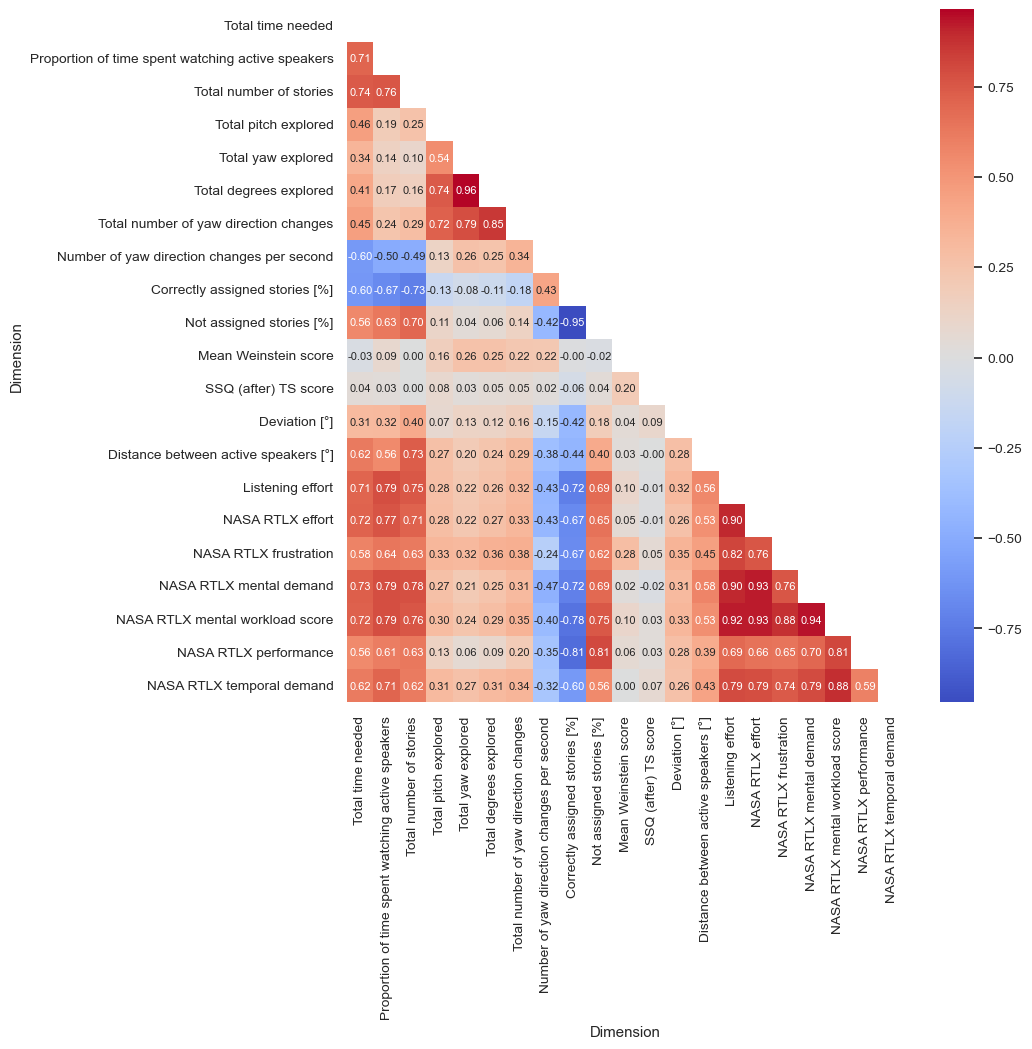

In [232]:
headrotation_speaker_story_mapping_nasatlx_weinstein_ssq_df_small_pivoted = headrotation_speaker_story_mapping_nasatlx_weinstein_ssq_df_small.pivot_table(index=['total_time_s', 'time_spent_watching_active_speakers', 'total_stories_count', 'total_pitch_explored', 'total_yaw_explored', 'total_degrees_explored', 'number_yaw_direction_changes', 'number_yaw_direction_changes_per_s', 'correctly_assigned_stories_percentage', 'no_assigned_stories_percentage', 'mean_weinstein_score', 'TS', 'deviation_count', 'distance_between_speakers'],
                          columns='rating_type', values='rating').reset_index()
d(headrotation_speaker_story_mapping_nasatlx_weinstein_ssq_df_small_pivoted)
correlation_matrix = headrotation_speaker_story_mapping_nasatlx_weinstein_ssq_df_small_pivoted.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(9, 9))
ax = sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 8})
ax.set_xlabel("Dimension")
ax.set_yticklabels(["Total time needed", "Proportion of time spent watching active speakers", "Total number of stories", "Total pitch explored", "Total yaw explored", "Total degrees explored", "Total number of yaw direction changes", "Number of yaw direction changes per second", "Correctly assigned stories [%]", "Not assigned stories [%]", "Mean Weinstein score", "SSQ (after) TS score", "Deviation [°]", "Distance between active speakers [°]", "Listening effort", "NASA RTLX effort", "NASA RTLX frustration", "NASA RTLX mental demand", "NASA RTLX mental workload score", "NASA RTLX performance", "NASA RTLX temporal demand"])
ax.set_ylabel("Dimension")
ax.set_xticklabels(["Total time needed", "Proportion of time spent watching active speakers", "Total number of stories", "Total pitch explored", "Total yaw explored", "Total degrees explored", "Total number of yaw direction changes", "Number of yaw direction changes per second", "Correctly assigned stories [%]", "Not assigned stories [%]", "Mean Weinstein score", "SSQ (after) TS score", "Deviation [°]", "Distance between active speakers [°]", "Listening effort", "NASA RTLX effort", "NASA RTLX frustration", "NASA RTLX mental demand", "NASA RTLX mental workload score", "NASA RTLX performance", "NASA RTLX temporal demand"])
d(ax)

save_fig(ax, "", "plots/correlation_matrix.pdf")
save_fig(ax, "", "plots/correlation_matrix.png")